__Author:__ Adam Bukowski

__Project:__ Churn prediction for bank customers

In [1]:
# core libraries for data analysis and visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, ParameterGrid
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
import shap # to look inside the black box

# additional 
from IPython.display import HTML # for code hide / show button
import pickle # saving and reading datasets / models
import types # for modifying existing object's method
from copy import deepcopy # to copy the model object, alter its method and not change the original
import warnings # for ignoring the warnings

# global settings
sns.set_context("talk")
warnings.filterwarnings("ignore", category = UserWarning)

In [3]:
print("list of used libraries along with their versions:")
!pip3 list | find "numpy "
!pip3 list | find "pandas "
!pip3 list | find "seaborn"
!pip3 list | find "matplotlib"
!pip3 list | find "scikit-learn"
!pip3 list | find "xgboost"
!pip3 list | find "shap "
print("pickle                            ", pickle.format_version)

list of used libraries along with their versions:
numpy                              1.19.5
pandas                             1.1.5
seaborn                            0.11.1
matplotlib                         3.3.4
scikit-learn                       0.24.2
xgboost                            1.5.2
shap                               0.40.0
pickle                             4.0


In [4]:
# Button to hide / show code in entire notebook
# always visible in the bottom right corner
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<button onclick="javascript:code_toggle()" 
style = "background-color: #4CAF50; /* Green */
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  position: fixed;
  bottom: 0px;
  right: 20px;">
Hide / Show code
</button>
''')

# Contents
- [Project description](#Project-description)
- [Data import and description](#Data-import-and-description)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature engineering](#Feature-engineering)
- [Feature selection](#Feature-selection)
- [Train / Test split](#Train-/-Test-split)
- [Modelling](#Modelling)
    - [Logistic Regression](#Logistic-Regression)
    - [SVM](#SVM)
    - [Random Forest](#Random-Forest)
    - [XGBoost](#XGBoost)
- [Models comparison](#Models-comparison)
    - [ROC curve and AUC](#ROC-curve-and-AUC)
    - [Precision-recall curve](#Precision-recall-curve)
    - [Cut-off-selection](#Cut-off-selection)
    - [Selected model](#Selected-model)
- [Understanding the model](#Understanding-the-model)
- [Final thoughts](#Final-thoughts)
- [Appendix - neural network tuning](#Appendix---neural-network-tuning)
- [Appendix II - costs based cut-off selection](#Appendix-II---costs-based-cut-off-selection)

# Project description
<a href="#Contents"><button type="button";>Back to ToC</button></a>

The aim of the project is to build a good quality model predicting customer churn from the bank. This is a supervised classification problem.

During the project we will:
* import and explore appropriate dataset
* perform data cleaning, feature engineering and feature selection
* use several modelling techniques: logistic regression, SVM, random forest and XGBoost
* perform hyperparameters tunning
* select best model and justify our choice
* propose the best cut-off point for prediction label
* show the main drivers of the model

# Data import and description
<a href="#Contents"><button type="button";>Back to ToC</button></a>

We will use the dataset publicly available on Kaggle website: https://www.kaggle.com/mathchi/churn-for-bank-customers

In [4]:
# reading the downloaded file
df = pd.read_csv('./Churn_Modelling.csv')
print("There are {} observations in the dataset".format(df.shape[0]))
print("There are {} features in the dataset".format(df.shape[1]))

There are 10000 observations in the dataset
There are 14 features in the dataset


In [5]:
print("Here are the first 5 rows of the data (transponed):")
df.head().T

Here are the first 5 rows of the data (transponed):


0         1         2         3         4
RowNumber               1         2         3         4         5
CustomerId       15634602  15647311  15619304  15701354  15737888
Surname          Hargrave      Hill      Onio      Boni  Mitchell
CreditScore           619       608       502       699       850
Geography          France     Spain    France    France     Spain
Gender             Female    Female    Female    Female    Female
Age                    42        41        42        39        43
Tenure                  2         1         8         1         2
Balance                 0   83807.9    159661         0    125511
NumOfProducts           1         1         3         2         1
HasCrCard               1         0         1         0         1
IsActiveMember          1         1         0         0         1
EstimatedSalary    101349    112543    113932   93826.6   79084.1
Exited                  1         0         1         0         0

In [6]:
print("We can see 3 text features:")
df.describe(include = "object").T

We can see 3 text features:


count unique     top  freq
Surname    10000   2932   Smith    32
Geography  10000      3  France  5014
Gender     10000      2    Male  5457

In [7]:
print("And 11 numeric features:")

# We will supress scientific notation for more clear picture
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

And 11 numeric features:


count         mean       std          min          25%  \
RowNumber        10000.00      5000.50   2886.90         1.00      2500.75   
CustomerId       10000.00  15690940.57  71936.19  15565701.00  15628528.25   
CreditScore      10000.00       650.53     96.65       350.00       584.00   
Age              10000.00        38.92     10.49        18.00        32.00   
Tenure           10000.00         5.01      2.89         0.00         3.00   
Balance          10000.00     76485.89  62397.41         0.00         0.00   
NumOfProducts    10000.00         1.53      0.58         1.00         1.00   
HasCrCard        10000.00         0.71      0.46         0.00         0.00   
IsActiveMember   10000.00         0.52      0.50         0.00         0.00   
EstimatedSalary  10000.00    100090.24  57510.49        11.58     51002.11   
Exited           10000.00         0.20      0.40         0.00         0.00   

                         50%          75%          max  
RowNumber            5000.50      7500.25     10000.00  
CustomerId       15690738.00  15753233.75  15815690.00  
CreditScore           652.00       718.00       850.00  
Age                    37.00        44.00        92.00  
Tenure                  5.00         7.00        10.00  
Balance             97198.54    127644.24    250898.09  
NumOfProducts           1.00         2.00         4.00  
HasCrCard               1.00         1.00         1.00  
IsActiveMember          1.00         1.00         1.00  
EstimatedSalary    100193.91    149388.25    199992.48  
Exited                  0.00         0.00         1.00

It is worth pointing out right away that we have __no missing values__ in our data (count 10000 for each variable in both summary tables and number of observations in our dataset is 10000). It means one less step in our analysis as typicaly we would have to treat missing values somehow before modelling (usually by mean / median / most frequent category imputation)

Some of these numeric variables should rather be considered as categorical variables which we can observe by looking at the number of unique values for each feature:

In [8]:
df.apply(lambda s: s.nunique()).to_frame("unique")

unique
RowNumber         10000
CustomerId        10000
Surname            2932
CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2

For 10000 observations we see 10000 different __CustomerId__ so we should expect 10000 distinct customers being described by the data. On the other hand, we see 2932 unique surnames which in theory could mean that one customer is described by more than one row (although of course surname is not a unique identifier of a person). 

To be certain that each row describes different customer we took a subset of features (other than CustomerId) and showed below that each unique combination of these features occurs only once in our dataset:

In [9]:
df.groupby(['Surname','Age','Tenure','Geography','CreditScore']).size().value_counts().to_frame("#")

#
1  10000

After first independent verification of the features and their types and values we can prepare a brief description of the features (also utilising information about the data from Kaggle website):

* __RowNumber__: exactly as expected from the name, numbers from 1 to 10000 iterating over all rows in the dataset. It will not be useful for modelling and we can stop analysing it from this point forward
* __CustomerId__: numeric unique identifier of a customer with no valuable meaning for our analysis
* __Surname__: surname of the customer. Customers surely not take into account their own name while they are deciding whether to leave the bank or not, therefore we will drop this feature aswell.
* __CreditScore__: name of the feature suggests it is the bank's assesment of the customer in terms of a potential credit decision. It may be possible that customers with lower scores have harder time getting new products in the bank therefore from their perspective their relation with the bank may not be too profitable - they may be more likely to leave the bank
* __Geography__: one of 3 countries, presumably where the customers live. It is possible that the churn rates differ across these countries
* __Gender__: gender of the customer. We will verify whether it has any value for predicting churn (definitely it is not too actionable from the bank's perspective)
* __Age__: customer's age in years. We may expect that younger customers are more keen to changes in general so the decision to leave the bank if they are unhappy with something may be easier for them. Also it seems sensible to consider customer's age while prepering actions aiming to prevent churn for customers with high risk from our model
* __Tenure__: How long (in years - according to data description on Kaggle) given person is the customer of the bank. It is reasonable to expect customers with longer relationship with the bank being less likely to leave (they would probably need a really good reason to do it)
* __Balance__: It is not certain whether it refers to customer's credit or account balance (we will assume account balance) but either way it should be useful for churn modelling (customers heavily invested in bank's products may be less likely to leave)
* __NumOfProducts__: How many of the bank's products are owned by the customer. We expect that customers with more products turn out being less likely to churn
* __HasCrCard__: 1/0 flag whether the customer owns the bank's credit card or not. Credit card owners may be more likely to continue their relationship with the bank
* __IsActiveMember__: 1/0 flag whether the customer is active. It may be defined by the bank in many ways, however general intuition is that if the customer is not active in this bank then he/she may be active in another one (and sooner or later we may be seeing him/her closing remaining unused products)
* __EstimatedSalary__: excactly as the name of the feature suggests. This can definitely have an impact on decision to churn but the direction of this feature's impact is not so obvious (low salary customers may be more likely to search for one-time bonuses while opening new accounts in other banks but high salary customers are more valuable for other banks and they may be potentially targeted by tailored offers allowing more effective growth of their savings)
* __Exited__: 1/0 flag whether the customer left the bank or not. This will be the target variable for our supervised classification modelling task

# Exploratory Data Analysis
<a href="#Contents"><button type="button";>Back to ToC</button></a>

After some initial EDA in the previous section we already know quite a lot about feature types and have some idea about their distribution. Here we will look for some insights in terms of potential usefulness of these features for churn modelling

First of all, we will drop __CustomerId__ and __Surname__ which as we already justified will not be useful. We will keep __RowNumber__ as unique identifier of observations for potential future joins but we will not analyse it nor take into account during modelling 

In [10]:
# dropping not neeeded columns
df.drop(['CustomerId', 'Surname'], axis = 1, inplace = True)

Then we will look on our target variable - __Exited__. As we can see on the figure below, we have slightly over 20% churners in our dataset. This means we have a class imbalance and we will have to be careful during modelling. For example, without any effort we can have a model with almost 80% accuracy just by always predicting "no churn" class. Of course such model is not useful at all. We will have to focus on positive class which is especially important modelling churn considering that most often it is easier / cheaper to prevent customer from leaving the bank than to acquire a new one. We will discuss it further deciding how to measure performance of our models

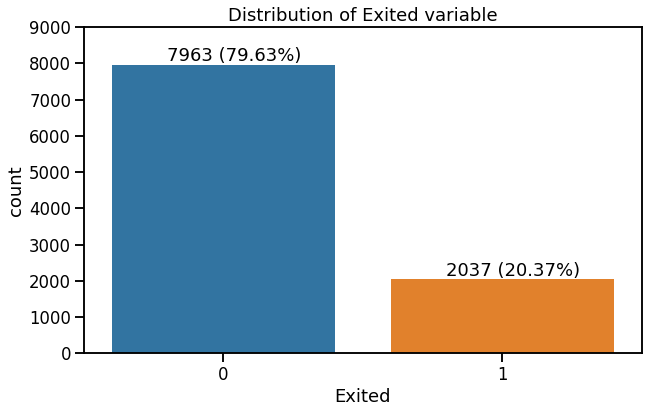

In [11]:
plt.figure(figsize=(10,6))

# calculating % of each class for labels over bars
labels = df.groupby('Exited').size().to_frame("cnt").assign(pr = lambda x: x.cnt / sum(x.cnt))
f = sns.countplot(x = 'Exited', data = df)

# adding labels over bars
for i, p in enumerate(f.patches):
    f.annotate('{:.0f} ({:.2%})'.format(p.get_height(), labels.pr[i]), (p.get_x()+0.2, p.get_height()+100))
    
f.set(ylim=(0, 9000))
plt.title('Distribution of Exited variable')
plt.show()

Then we will analyse variables that can be considered categorical.

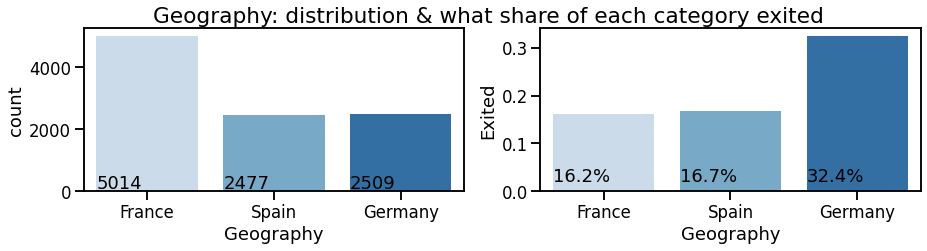

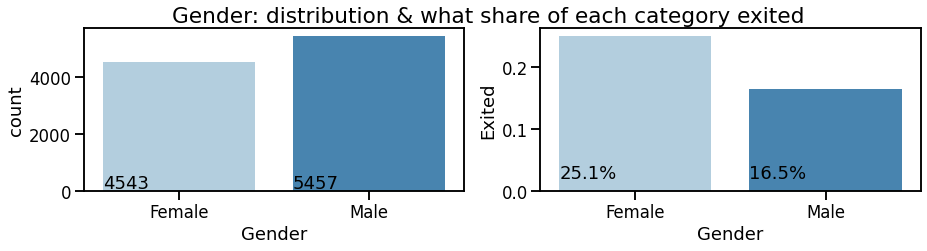

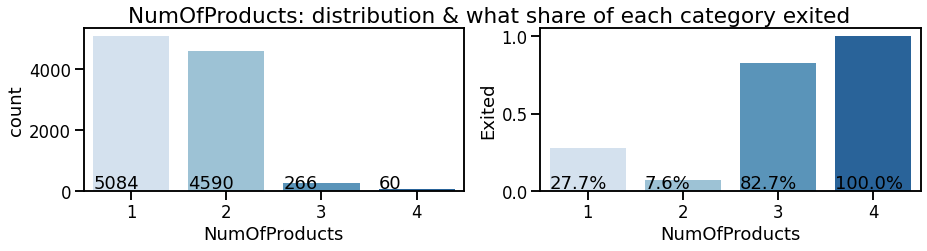

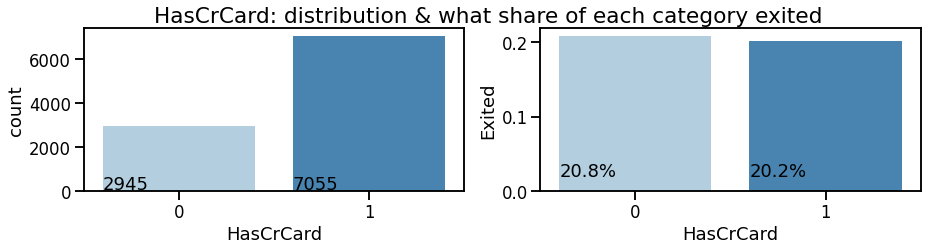

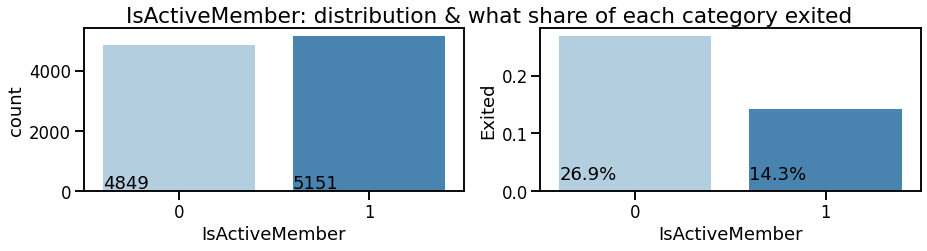

In [12]:
def EDA_categorical(data, variable, target):
    '''Function producing two side by side plots for categorical variable:
        - countplot to show distribution between all categories
        - share of positive values of target variable for each category
    
     Args:
         data, dataframe: data with at least two columns - specified variable and target 0/1 column
         variable, string: name of the categorical variable we want to analyse
         target, string: name of the 0/1 target variable

     Returns:
         Nothing
    ''' 
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 3))
    sns.countplot(x = v, data = data, ax = ax1, palette = 'Blues')
    sns.barplot(x = variable, y = target, data = data, ax = ax2, ci = None, palette = 'Blues')
    # adding labels for bars
    for p in zip(ax1.patches,ax2.patches):
        ax1.annotate('{:.0f}'.format(p[0].get_height()), (p[0].get_x(), 100))
        ax2.annotate('{:.1%}'.format(p[1].get_height()), (p[1].get_x(), 0.02))
    plt.suptitle(variable + ": distribution & what share of each category exited")
    plt.show()
    
categorical = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard','IsActiveMember']

for v in categorical:
    EDA_categorical(df, v, 'Exited')

From the set of plots above we can draw the following conclusions:
* about half of the customers are from France, quarter from Spain and quarter from Germany. In Germany the share of churners is two times higher than in France and Spain.
* there are almost 1000 more male customers than female customers in our dataset, but women churn visibly more often than men
* most customers have either 1 or 2 products and customers with 1 product churn close to 4 times more often than customers with 2 products. Interestingly, vast majority of customers with 3 or 4 products exited the bank (100% churn rate for customers with 4 products!) but customers with that many products are only about 3% of our whole dataset
* About 70% customers has credit card but the shares of customers who exited the bank are almost identical in both groups meaning that this variable will not be useful for predicting churn
* About half customers are active and their churn rate is about two times lower than in case of inactive members

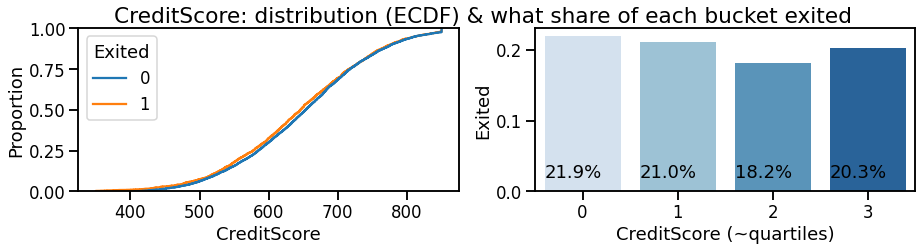

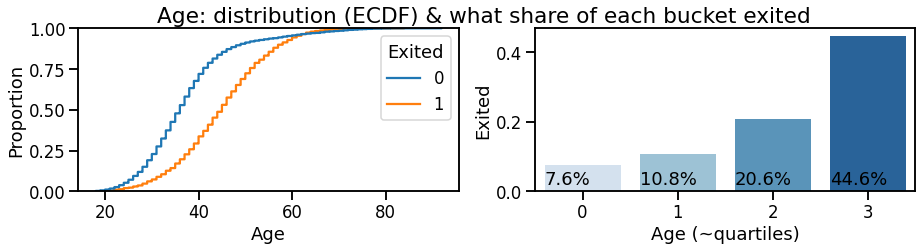

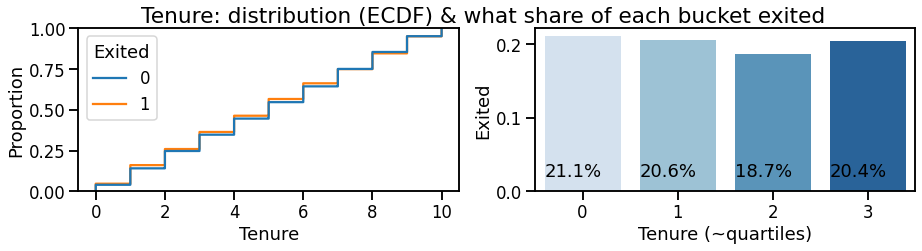

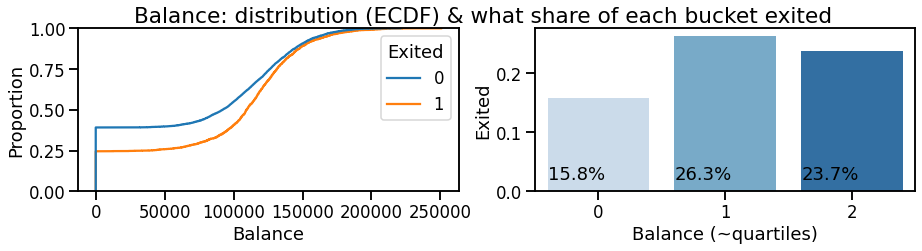

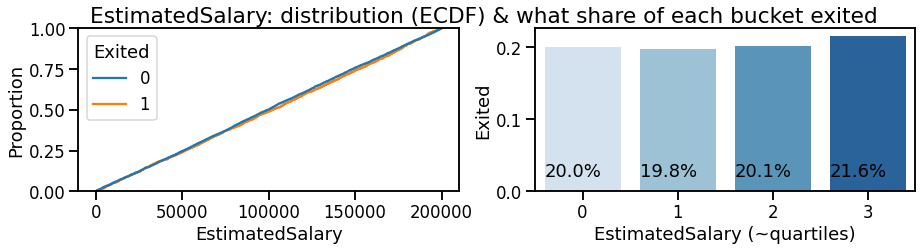

In [13]:
def bucket_continuous(data, v, no_buckets):
    '''Function adding to data additional variable - buckets of supplied 
    continuous variable. Buckets are generated based on quartiles. Name of the new variable is the 
    original name with the prefix 'CAT__'. It is worth to note that if we divde given variable into 4 
    buckets and one value of given variable is observed on > 25% of whole dataset we do not raise the
    error. Instead we drop duplicated bucket boundry (thus in fact we merge 2 buckets)
    
     Args:
         data, dataframe: data with column v
         v, string: name of the presumably continuous column existing in data.
         no_buckets, integer: number of buckets we want to achieve after grouping variable v based on quantiles

     Returns:
         dataframe: data with column name 'CAT__{v}' with enumerated buckets calculated based on variable v
    ''' 
    return data.assign(**{"CAT__"+v: lambda x: pd.qcut(x[v], no_buckets, labels=False, duplicates = 'drop')})


def EDA_continuous(data, variable, target):
    '''Function producing two side by side plots for continuous variable:
        - ECDF to show distribution - separately for both values of target variable
        - share of positive values of target variable for each of the automatically generated buckets of supplied 
          continuous variable. Buckets are generated based on quartiles
    
     Args:
         data, dataframe: data with at least two columns - specified variable and target 0/1 column
         variable, string: name of the continuous variable we want to analyse
         target, string: name of the 0/1 target variable

     Returns:
         Nothing
    ''' 
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 3))
    sns.ecdfplot(x = variable, data = data, ax = ax1, hue = target)
    sns.barplot(x = variable+" (~quartiles)", y = target, 
                data = bucket_continuous(data, variable, 4). \
                    rename({"CAT__"+variable: variable+" (~quartiles)"}, axis = 1), 
                ax = ax2, ci = None, palette = 'Blues')

    # adding labels for bars
    for p in ax2.patches:
        ax2.annotate('{:.1%}'.format(p.get_height()), (p.get_x(), 0.02))
    plt.suptitle(variable + ": distribution (ECDF) & what share of each bucket exited")
    plt.show()

continuous = ['CreditScore', 'Age', 'Tenure', 'Balance','EstimatedSalary']

for v in continuous:
    EDA_continuous(df,v,'Exited')

In [14]:
print("Additional check for Balance 0 vs >0: ")
df.assign(Balance = lambda x: ['Balance = 0' if b == 0 else 'Balance > 0' for b in x.Balance]). \
    groupby('Balance'). \
    agg(cnt = ('Balance','size'), exited = ('Exited', sum)). \
    assign(**{"% exited" : lambda x: ['{:.2%}'.format(p) for p in x.exited / x.cnt]})

Additional check for Balance 0 vs >0: 


cnt  exited % exited
Balance                           
Balance = 0  3617     500   13.82%
Balance > 0  6383    1537   24.08%

For each continuous variable we presented two plots:
* on the left - ECDF (empirical cumulative distribution function) which is calculated as follows:
\begin{equation}
ECDF(x) = \frac{\#\ observations\ where\ Variable\ <=\ x}{Total\ number\ of\ observations}
\end{equation}
which is a nice alternative to histogram for showing a distribution. It also allows easy comparison between two subgroups - especially relevant differences can easily be spotted
* on the right - bar chart showing churn rate on buckets calculated based on quartiles. In case of the Balance variable, where there is ~36% of observations with 0 value, we presented 3 buckets: [min, median] (50% of data), [median, Q3] (25% of data), [Q3, max] (25% of data)

From these plots we draw the following conclusions:
* CreditScore variable does not seem to be useful for our task - the distribution observed for churners and non-churners is really similar
* Substantial difference between churners and non-churners can be observed looking at their age - contrary to our initial intuition we see that older customers churn much more often than the younger customers
* Similarily as in case of CreditScore - the Tenure variable does not seem to have visibly different distribution whether the customer churn or not. We expected that customers with longer relationship with the bank turn out to be more loyal but looking at this particular dataset - it is not the case
* Balance variable also defies our expectation - customers with lower balance churn less than those with higher balance. Slightly over one third of all customers have balance 0 and churn rate on this group is lower than 14%. Meanwhile customers with balance between median and 3rd quartile have over 26% churn rate so close to twice as high
* Estimated salary turns out not to have an impact on churn. One thing to notice is that the ECDF function is basically a straight line from (0,0%) to (200000,100%) - this is exactly what we would observe for randomly generated values from uniform distribution between 0 and 200000 which we verified in the figure below. With publicaly available dataset we cannot be certain as to how the data were prepared and in this case it does not look as a legitimate data.

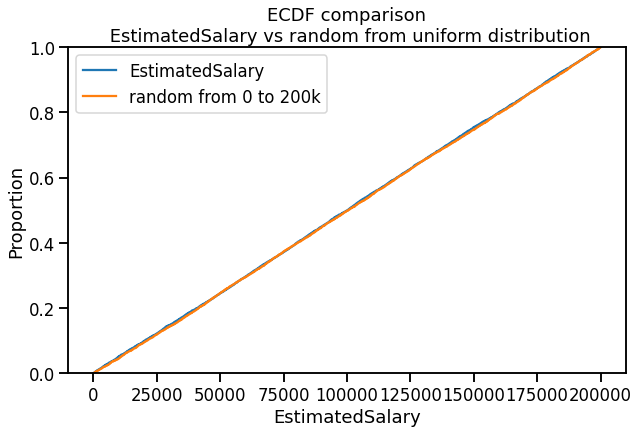

In [15]:
# setting the seed for reproducibility
np.random.seed(3103)

plt.figure(figsize=(10,6))
sns.ecdfplot(x = 'EstimatedSalary', data = df)
sns.ecdfplot(x = 'random from 0 to 200k', 
             # adding 10000 values randomly generated from uniform distribution between 0 and 200000 as new variable
             data = df.assign(**{'random from 0 to 200k': lambda x: np.random.rand(10000,1)*200000}))
plt.legend(labels = ["EstimatedSalary", "random from 0 to 200k"])
plt.title("ECDF comparison\n EstimatedSalary vs random from uniform distribution")
plt.show()

In fact we can also see regular behaviour of ECDF for Tenure variable which along with the fact that it basically does not differentiate churners and non-churners raises some suspisions regarding legitimacy of this variable. Below we looked at the distribution of Tenure and in our opinion it is not unlikely that it was generated from discrete distribution where 0 and 10 have about 5% probability each and values from 1 to 9 have about 10% probability each. While it would be rather rare to draw only 413 instances of 0 values in such case, our simulation gave quite similar results

In [16]:
def summarise_discrete_dist(data, variable):
    '''Function summarising data by presumably discrete variable and presenting useful distribution information
    in the context of this churn analysis
    
     Args:
         data, dataframe: data with at least two columns - specified variable and Exited numeric column
         variable, string: name of the variable by which we want to group

     Returns:
         dataframe: counts, number and % of exited and % of total for each value of supplied variable
    '''
    return data.groupby(variable). \
            agg(cnt = (variable,'size'), exited = ('Exited', sum)). \
            assign(**{"% of total" : lambda x: ['{:.1%}'.format(p) for p in x.cnt / sum(x.cnt)],
                      "% of bucket exited": lambda x: ['{:.1%}'.format(p) for p in x.exited / x.cnt]}).T

display(summarise_discrete_dist(df,'Tenure'))

# setting the seed for reproducibility
np.random.seed(3103)
# possible discrete values - from 0 to 10
elements = list(range(11))
# probabilities for each value - 5% for 0 and 10, 10% for 1 to 9
probabilities = [0.05] + list(np.ones(9)*0.1) + [0.05]

display(summarise_discrete_dist(
    # adding 10000 values from discrete distribution with parameters defined above
    df.assign(**{'Tenure (simulated)': lambda x: np.random.choice(elements, 10000, p=probabilities)}),
    'Tenure (simulated)'))

Tenure                 0      1      2      3      4      5      6      7   \
cnt                   413   1035   1048   1009    989   1012    967   1028   
exited                 95    232    201    213    203    209    196    177   
% of total           4.1%  10.3%  10.5%  10.1%   9.9%  10.1%   9.7%  10.3%   
% of bucket exited  23.0%  22.4%  19.2%  21.1%  20.5%  20.7%  20.3%  17.2%   

Tenure                 8      9      10  
cnt                  1025    984    490  
exited                197    213    101  
% of total          10.2%   9.8%   4.9%  
% of bucket exited  19.2%  21.6%  20.6%

Tenure (simulated)     0      1      2      3      4      5      6      7   \
cnt                   449    982   1027   1001   1018   1005   1036    951   
exited                105    193    191    206    199    214    218    192   
% of total           4.5%   9.8%  10.3%  10.0%  10.2%  10.1%  10.4%   9.5%   
% of bucket exited  23.4%  19.7%  18.6%  20.6%  19.5%  21.3%  21.0%  20.2%   

Tenure (simulated)     8      9      10  
cnt                  1010   1008    513  
exited                206    216     97  
% of total          10.1%  10.1%   5.1%  
% of bucket exited  20.4%  21.4%  18.9%

It is worth noting that after exploring the variables we can say that all their __values seems reasonable__ (given the variables meaning - for example no 200 years old customers). We also did not spot any values that we think should be considered as outliers therefore we will not perform any actions to treat the potential outliers (which is often one of the data preprocessing steps)

One last thing to notice from our EDA is that it seems that our data about customers represents values from one point of time while the information whether customer exited or not comes from some later point in time. Otherwise we would rather not see customers who exited the bank but still are active or have a credit card. Of course data prepared in that way are resonable as we want to predict the future churn to be able to prevent it.

# Feature engineering
<a href="#Contents"><button type="button";>Back to ToC</button></a>

Typically, the feature engineering is a vital part of any data science modelling project. In our case we are heavily limited by small number of original features available in the dataset. Typically for churn modelling the most useful insights comes from observing changes in behaviour over time but this would require having several observations from different points in time for each customer (which we do not have). 

We will construct some ratio type variables and one-hot encode our categorical variables

In [211]:
def add_new_features(data):
    '''Function adding new features designed for the dataset analysed in this project
    
     Args:
         data, dataframe: dataset analysed in this project

     Returns:
         dataframe: dataframe extended by new features
    '''   
    return data.assign(
        # ratios 
        NumOfProductsByAge = lambda x: x.NumOfProducts / x.Age,
        CreditScoreByAge = lambda x: x.CreditScore / x.Age,
        BalanceByAge = lambda x: x.Balance / x.Age,
        BalanceBySalary = lambda x: [250000 if b < 1 else a/b for a,b in zip(x.Balance, x.EstimatedSalary)],
        BalanceByTenure = lambda x: [a if b < 1 else a/b for a,b in zip(x.Balance, x.Tenure)],
        BalanceByCreditScore = lambda x: x.Balance / x.CreditScore,
        TenureByAge = lambda x: x.Tenure / x.Age,
        SalaryByAge = lambda x: x.EstimatedSalary / x.Age,
        SalaryByCreditScore = lambda x: x.EstimatedSalary / x.CreditScore,
        # one-hot encoding
        FromGermany = lambda x: [1 if g == 'Germany' else 0 for g in x.Geography],
        FromSpain = lambda x: [1 if g == 'Spain' else 0 for g in x.Geography],
        IsFemale = lambda x: [1 if g == 'Female' else 0 for g in x.Gender],
        NumOfProductsTwo = lambda x: [1 if n == 2 else 0 for n in x.NumOfProducts],
        NumOfProductsMany = lambda x: [1 if n > 2 else 0 for n in x.NumOfProducts]
    )

In [17]:
df_fe = add_new_features(df)

print("Number of columns before feature engineering: ", df.shape[1])
print("Number of columns after: ", df_fe.shape[1])

Number of columns before feature engineering:  12
Number of columns after:  26


Let us first do some quick EDA of our new ratios

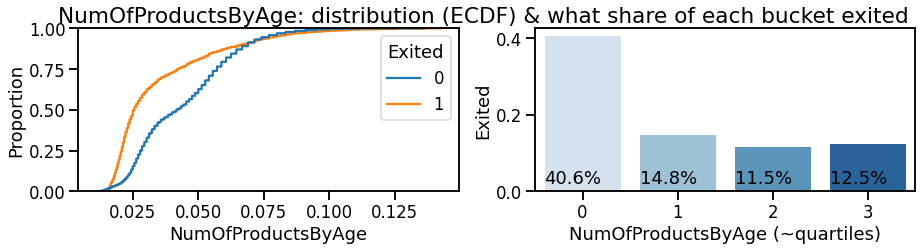

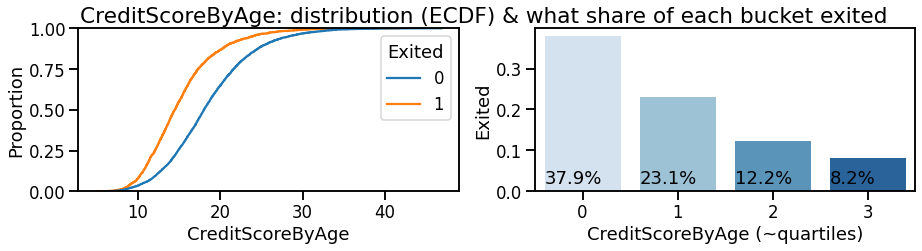

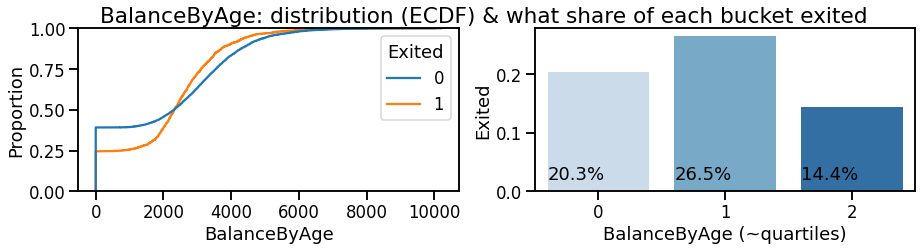

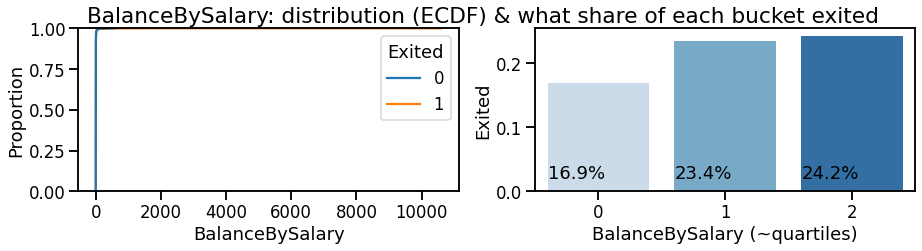

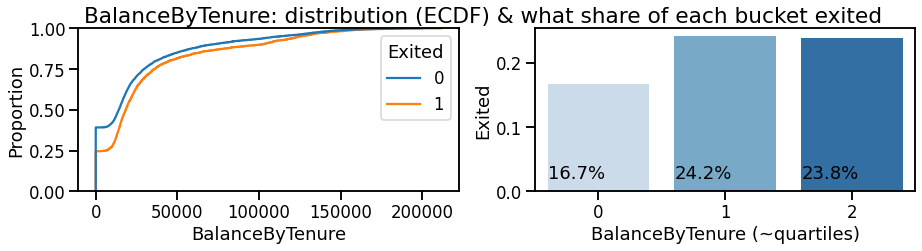

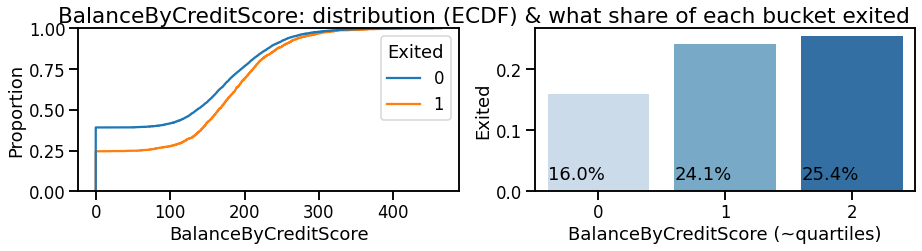

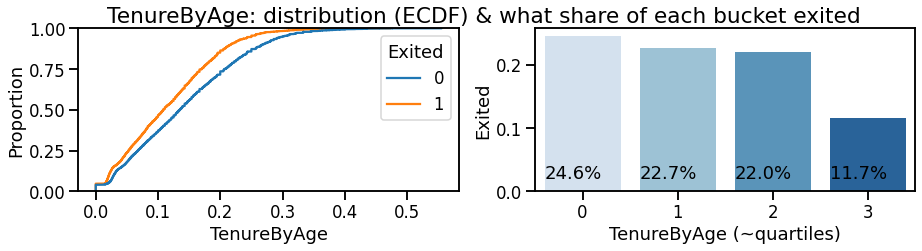

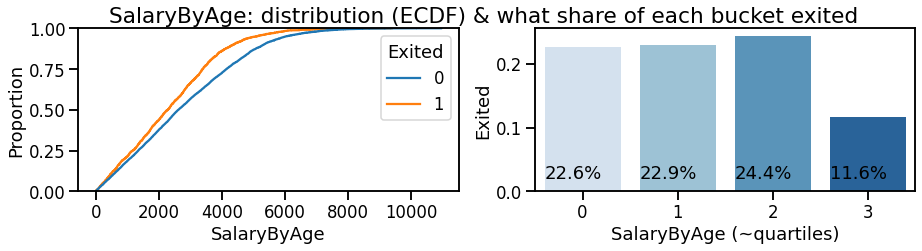

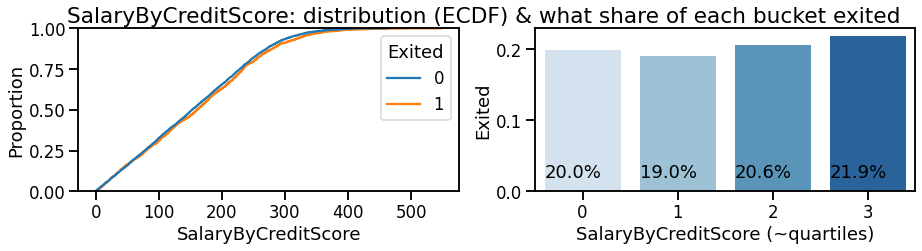

In [18]:
new_continuous = df_fe.loc[:,"NumOfProductsByAge":"SalaryByCreditScore"].columns.to_list()

for v in new_continuous:
    EDA_continuous(df_fe,v,'Exited')

As it can be seen, some of these ratios are potentially impactful for our modelling task and some are not. We will not focus now on interpretation of these features (especially that behaviour of some of the original features is not entirely intuitive as we mentioned in the EDA section) as some of them will probably be dropped during the feature selection part of the project 

Let us also inspect the 1/0 variables we got from One-Hot encoding of categorical variables:

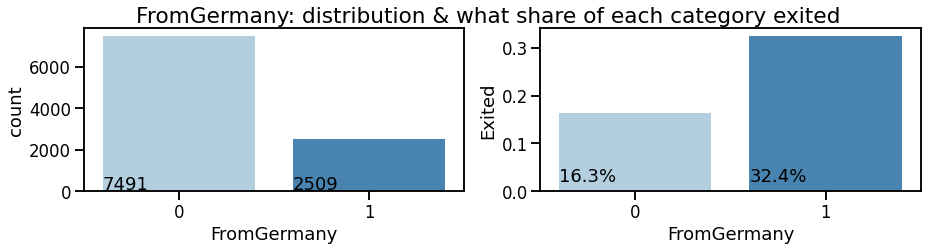

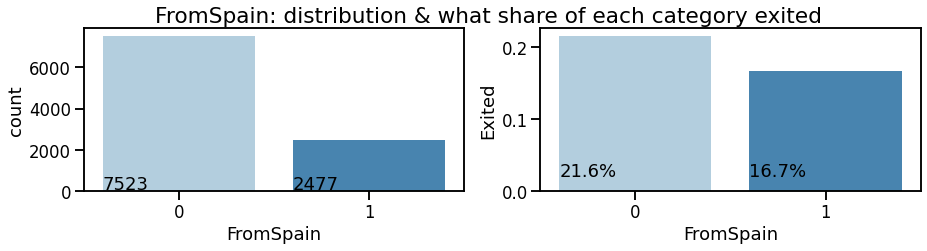

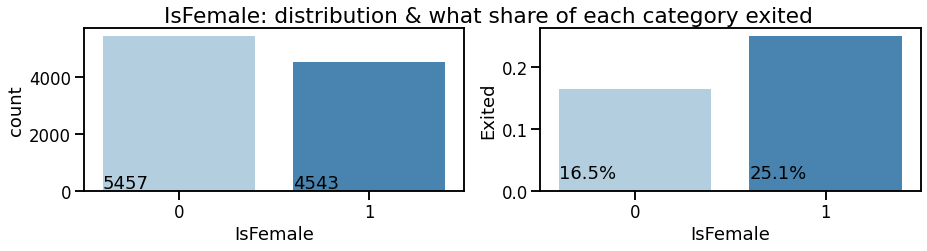

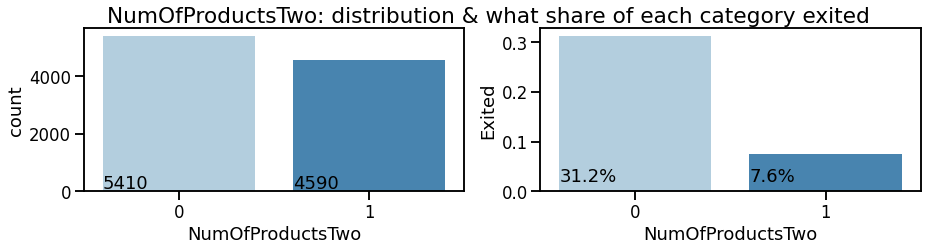

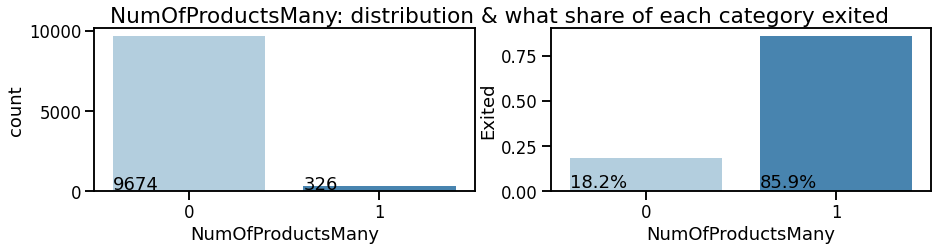

In [19]:
one_hot_encoded = df_fe.loc[:,"FromGermany":"NumOfProductsMany"].columns.to_list()

for v in one_hot_encoded:
    EDA_categorical(df_fe,v,'Exited')

It can be seen  that all of them are potentially useful. It is worth to make some justification here:
* For __Geography__ and __Gender__ variables we produced 1 less variable than the number of categories (as the remaining one is implied by 0 values in all generated variables). That way we limit collineariaty which is important for some modelling algorithms
* Due to the fact that __NumOfProducts__ has only 4 observed values and the fact it provides good differentiation between churners and non-churners but it is not monotonic (sort of v-shape: high churn rate for 1 product, low for 2 products, highest for 3-4 products), we decided to treat it as a categorical variable and also One-Hot encode its values. As values 3 and 4 in this variable are very rare and have similar, very high churn rate, we produced one flag for them - __NumOfProductsMany__. For 2 products we also created separate variable - __NumOfProductsTwo__. We then can deduce that customer has one product if both NumOfProductsMany and NumOfProductsTwo are equal 0

# Feature selection
<a href="#Contents"><button type="button";>Back to ToC</button></a>

Feature selection is also important step in any modelling task. By excluding features that have very little predictive value we can significantly reduce the computation time in modelling phase (which is especially important if we want to tune the model's hyperparameters) and usually obtain better models.

There are many techniques to select the features. Several examples would be:
* running Lasso logistic regression on all features and excluding those for which coefficient ends up to be 0 (property of Lasso regression - it shrinks coefficients to 0 for least impactful features instead of leaving them on some very low, but higher than 0 level)
* calculating feature importance for example on random forest built on all features and excluding those with importance below some threshold
* calculating Information Value (IV) for each feature and excluding ones with very low IV

In this project we will show the last one. But first of all we will show how to calculate IV:
* the first step is to divide variables' range of values into several buckets in case of continuous variables. For categorical variables with few categories we treat each category as a separate bucket
* for each bucket we calculate Weight of Evidence (Woe):
\begin{equation}
WoE(b) = log\left(\frac{(N(b)+c)(P+c)}{(N+c)(P(b)+c)}\right)
\end{equation}
where 
    * b - bucket
    * N(b) - number of observations from negative (in our case non-churners) class in bucket b
    * P(B) - number of observations from positive (in our case churners) class in bucket b
    * N - total number of observations from negative class in sample
    * P - total number of observations from positive class in sample
    * c - correction, usually equals 0.5
* it is worth to note that WoE(b) > 0 indicates that the share of negative class in bucket b is higher than on whole dataset (the higher the WoE the more the bucket's share of negatives surpasses the dataset's share of negatives). Conversly, WoE(b) < 0 indicates that the share of positive class in bucket b is higher then on whole dataset
* then for each bucket we calculate its contribution to IV:
\begin{equation}
IV(b) = \left(\frac{N(b)}{N} - \frac{P(b)}{P}\right)WoE(b)
\end{equation}
* Total IV for given feature is the sum of IV(b) for all defined buckets b for this feature
* The benchmark values for IV are usually as follows:
    * below 0.02: variable is not usufel as a predictor (we can drop it)
    * 0.02 - 0.1: weak predictor
    * 0.1 - 0.3: moderate predictor
    * 0.3 - 0.5: strong predictor
    * over 0.5: suspicious predictor (we should verify whether variable is not calculated partially based on predicted target, although from our experience it is definitely possible to achieve such results for legitimate variables)

In [20]:
# Definition of functions for WoE and IV calculation and summary
def woe(Nb,Pb,N,P,c = 0.5):
    '''Function calculating WoE values based on supplied parameters
     
     Args:
         Nb, integer or array / series of integers: number of observations from negative class in bucket
         Pb, integer or array / series of integers: number of observations from positive class in bucket
         N, integer or array / series of integers: total number of observations from negative class in whole dataset
         P, integer or array / series of integers: total number of observations from positive class in whole dataset
         c, float: correction parameter, typically 0.5
         
     Returns:
         float or array / series of floats: calculated WoE value
    
    '''
    return np.log((Nb+c)*(P+c)/((N+c)*(Pb+c)))

def woe_transform(data,target,v):
    '''Function adding to data additional variable - calculated WoE values for groups defined by supplied 
    variable v.
    
     Args:
         data, dataframe: data with column target and v
         target, string: name of the 0/1 target variable
         v, string: name of the column existing in data WoE will be calculated for buckets defined by each 
                    distinct value of v so v is expected to be categorical with low number of categories.

     Returns:
         dataframe: data with column name 'WOE__{v}' with WoE values calculated for buckets defined by v
    '''
    # calculating total number of observations for each class
    N = df_fe.query(target + " == 0").shape[0]
    P = df_fe.query(target + " == 1").shape[0]
    # typical correction parameter for WoE
    c = 0.5
    
    return data.assign(**{"WOE__"+v: lambda x: [woe(Tb-Pb,Pb,N,P,c) for Pb, Tb in 
                                        zip(x.groupby(v)[target].transform('sum'),
                                            x.groupby(v)[target].transform('count')
                                           )
                                       ]
                         }
                      )

def calculate_woe(data, target, v_categorical = None, v_continuous = None, no_buckets = 4):
    '''Function ustilising function woe_transform to calculate WoE variables for supplied variables
    
     Args:
         data, dataframe: data with column target and columns specified in lists v_categorical and v_continuous
         target, string: name of the 0/1 target variable
         v_categorical, list of strings: names of the categorical columns for which we want to calculate corresponding
             WoE variables. Each distinct value of given column will define separate bucket
         v_continuous, list of strings: names of the continuous columns. First for each column the corresponding
             bucketed version will be calculated using function bucket_continuous. These new columns will define buckets
             on which corresponding WoE variables will be calculated
        no_bucketes, integer: number of buckets we want to achieve after grouping each of the continuous variables

     Returns:
         dataframe: data with columns 'CAT__{v}' for each variable v from v_continuous representing their bucketed
             versions and columns 'WOE__{v}' for each of these bucketed variables and for each variable from list
             v_categorical
    '''
    
    result = data.copy()
    
    if v_categorical is not None:
        for v in v_categorical:
            result = woe_transform(result,target,v)
            
    if v_continuous is not None:
        for v in v_continuous:
            result = bucket_continuous(result, v, no_buckets)
            result = woe_transform(result, target, 'CAT__'+v)
                   
    return result

def woe_summary(data, target):
    '''Function to calculate woe summary for whole dataset
    
     Args:
         data, dataframe: data with column target
         target, string: name of the 0/1 target variable

     Returns:
         df_summary, dataframe: summary of WoE calculation. It is created for variables with name starting with "WOE__"
             (therefore it will work well with previously developed functions). "P" means positive class of target variable
             (where it equals 1) and "N" means negative class of target variable (where it equals 0)
    '''
    
    # find all WoE_variables and corresponding original variables
    WOE_variables = [col for col in data if col.startswith('WOE__')]
    bucket_variables = [col.replace('WOE__','',1) for col in WOE_variables]
    original_variables = [col.replace('CAT__','',1) for col in bucket_variables]
    
    # initialize empty dataframe
    df_summary = pd.DataFrame()
    
    for v, b, w in zip(original_variables, bucket_variables, WOE_variables):
        df_buckety = data.assign(
                variable = v,
                bucket = lambda x: x[b],
                woe = lambda x: x[w],
                N = lambda x: 1-x[target]
            ).groupby(["variable", "bucket", "woe"], as_index = False).agg(
                min = (v, min),
                max = (v, max),
                total = ("bucket", 'count'),
                P = (target, sum),
                N = ("N", sum)
            ).assign(**{
                "% total": lambda x: ['{:.2%}'.format(y) for y in x.total / sum(x.total)],
                "% all P": lambda x: x.P / sum(x.P),
                "% all N": lambda x: x.N / sum(x.N),
                "P rate": lambda x: ['{:.2%}'.format(y) for y in x.P / x.total],
                "IV": lambda x: (x["% all N"] - x["% all P"])*x["woe"],
            }).assign(**{
                "% all P": lambda x: ['{:.2%}'.format(y) for y in x["% all P"]],
                "% all N": lambda x: ['{:.2%}'.format(y) for y in x["% all N"]]
            })
        df_summary = df_summary.append(df_buckety)
    return df_summary

def print_woe_details(data_summary):
    '''Function printing separate tabular summary for each variable based on summary prepared by function woe_summary
    
     Args:
         data_summary, dataframe: result of function woe_summary

     Returns:
         Nothing
    '''
    # get list of all variables included in the woe summary
    v_list = data_summary.variable.unique()
    
    for v in v_list:
        print(v, ":")
        df_buckety = data_summary[data_summary.variable == v]
        
        # add one row for each variable with aggregates for whole dataset
        total = pd.DataFrame({
            "variable": df_buckety['variable'].max(),
            "bucket": "TOTAL",
            "woe": "",
            "min": df_buckety['min'].min(),
            "max": df_buckety['max'].max(),
            "total": df_buckety['total'].sum(),
            "P": df_buckety['P'].sum(),
            "N": df_buckety['N'].sum(),
            "% total": "100.00%",
            "% all P": "100.00%",
            "% all N": "100.00%",
            "P rate": '{:.2%}'.format(df_buckety['P'].sum() / df_buckety['total'].sum()),
            "IV":  df_buckety.IV.sum()
            }, index = [0])
        display(df_buckety.append(total).reset_index().drop('index', axis = 1))
        
def iv_barplot(data_summary, title = ""):
    '''Function printing barplot with IV values for each variable summarised in data_summary
    
     Args:
         data_summary, dataframe: result of function woe_summary
         title, string: custom title of the plot

     Returns:
         Nothing
    '''
    
    # calculate Information Value of variable and apply groups based on one of typical benchmarks
    plot_data = data_summary.groupby('variable', as_index = False)["IV"].sum().assign(
        benchmark = lambda x: pd.cut(x.IV, [0,0.02,0.1,0.3,0.5,np.Inf], 
                                 labels = ['not useful','weak','moderate','strong', 'susp. strong'] )
    ).sort_values('IV', ascending = False)
    
    fig, ax = plt.subplots(figsize=(13,9))
    sns.barplot(y = 'variable', x = 'IV', hue = 'benchmark', data = plot_data, palette = 'RdYlGn', dodge=False, ax = ax)
    # adding IV values next to the bars
    for index, value in enumerate(plot_data.IV):
        ax.annotate('{:.2}'.format(value), xy=(value+0.01, index+0.3))
    ax.set_title(title)
    ax.set(xlim=(0, plot_data.IV.max()+0.15))
    plt.show()

The figure below shows the results of out Information Value calculation

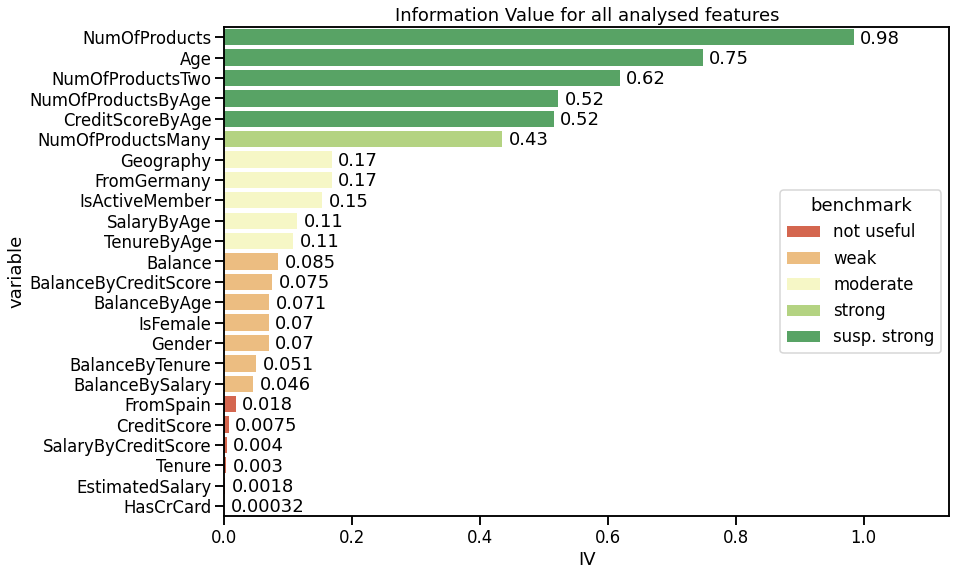

In [21]:
df_fe_woe = calculate_woe(df_fe,'Exited',
                  # original treated as categorical + One-Hot encodings of some of them
                  v_categorical = categorical + one_hot_encoded, 
                  # original treated as continuous + engineered ratios
                  v_continuous = continuous + new_continuous)

df_woe_summary = woe_summary(df_fe_woe, 'Exited')

iv_barplot(df_woe_summary, "Information Value for all analysed features")

Based on the obtained IV values:
* we will exclude the following features from modelling: 
    * __HasCrCard__, __EstimatedSalary__, __Tenure__ and __CreditScore__ - they have low predictive power which we already identified during our EDA
    * __SalaryByCreditScore__ - no suprise that our engineered ratio based on 2 weak variables turned out to also be weak
    * __FromSpain__ - It is worth to notice, that original __Geography__ variable has the same predictive power as __FromGermany__ which One-Hot encodes the Germany category. During our EDA we saw that Spain and France have virtually the same churn rate so it is enough to only check whether the customer is from Germany or not to fully utilize what the __Geography__ variable has to offer
* __Geography__ and __Gender__ were presented here only to have a reference for engineered One-Hot encodings for these variables. We will not use them from this point forward
* As justified during feature enginnering, we decided to One-Hot encode the variable __NumOfProducts__. On the figure above we see the highest IV for __NumOfProducts__ but we can also see that __NumOfProductsTwo__ and __NumOfProductsMany__ are also very strong. We will not us the __NumOfProducts__ in our remaining analyses
* Some variables based on age and number of products scored very high Information Value which according to provided benchmark is suspicious. We do not have the possibility to verify whether these variables were calculated correctly and there is no information leakage from the target variable. However from our experience it is totally possible to achieve that high results for perfectly legitimate variables

Below we additionally present the details for IV and woe calculation (it can also be seen how the continuous features were divided into buckets - these are the same buckets as during our EDA):

In [22]:
print_woe_details(df_woe_summary)

Geography :


variable   bucket       woe      min      max  total     P     N  % total  \
0  Geography   France  0.283114   France   France   5014   810  4204   50.14%   
1  Geography  Germany -0.629987  Germany  Germany   2509   814  1695   25.09%   
2  Geography    Spain  0.244841    Spain    Spain   2477   413  2064   24.77%   
3  Geography    TOTAL             France    Spain  10000  2037  7963  100.00%   

   % all P  % all N  P rate        IV  
0   39.76%   52.79%  16.15%  0.036889  
1   39.96%   21.29%  32.44%  0.117649  
2   20.27%   25.92%  16.67%  0.013821  
3  100.00%  100.00%  20.37%  0.168359

Gender :


variable  bucket       woe     min     max  total     P     N  % total  \
0   Gender  Female -0.268637  Female  Female   4543  1139  3404   45.43%   
1   Gender    Male  0.261097    Male    Male   5457   898  4559   54.57%   
2   Gender   TOTAL            Female    Male  10000  2037  7963  100.00%   

   % all P  % all N  P rate        IV  
0   55.92%   42.75%  25.07%  0.035374  
1   44.08%   57.25%  16.46%  0.034381  
2  100.00%  100.00%  20.37%  0.069754

NumOfProducts :


variable bucket       woe min max  total     P     N  % total  \
0  NumOfProducts      1 -0.404691   1   1   5084  1409  3675   50.84%   
1  NumOfProducts      2   1.13612   2   2   4590   348  4242   45.90%   
2  NumOfProducts      3  -2.91959   3   3    266   220    46    2.66%   
3  NumOfProducts      4  -6.15894   4   4     60    60     0    0.60%   
4  NumOfProducts  TOTAL             1   4  10000  2037  7963  100.00%   

   % all P  % all N   P rate        IV  
0   69.17%   46.15%   27.71%  0.093157  
1   17.08%   53.27%    7.58%  0.411134  
2   10.80%    0.58%   82.71%  0.298456  
3    2.95%    0.00%  100.00%  0.181412  
4  100.00%  100.00%   20.37%  0.984160

HasCrCard :


variable bucket        woe min max  total     P     N  % total  % all P  \
0  HasCrCard      0 -0.0276294   0   0   2945   613  2332   29.45%   30.09%   
1  HasCrCard      1  0.0114099   1   1   7055  1424  5631   70.55%   69.91%   
2  HasCrCard  TOTAL              0   1  10000  2037  7963  100.00%  100.00%   

   % all N  P rate        IV  
0   29.29%  20.81%  0.000223  
1   70.71%  20.18%  0.000092  
2  100.00%  20.37%  0.000315

IsActiveMember :


variable bucket       woe min max  total     P     N  % total  \
0  IsActiveMember      0 -0.361187   0   0   4849  1302  3547   48.49%   
1  IsActiveMember      1  0.429407   1   1   5151   735  4416   51.51%   
2  IsActiveMember  TOTAL             0   1  10000  2037  7963  100.00%   

   % all P  % all N  P rate        IV  
0   63.92%   44.54%  26.85%  0.069976  
1   36.08%   55.46%  14.27%  0.083193  
2  100.00%  100.00%  20.37%  0.153170

FromGermany :


variable bucket       woe min max  total     P     N  % total  % all P  \
0  FromGermany      0  0.270676   0   0   7491  1223  6268   74.91%   60.04%   
1  FromGermany      1 -0.629987   1   1   2509   814  1695   25.09%   39.96%   
2  FromGermany  TOTAL             0   1  10000  2037  7963  100.00%  100.00%   

   % all N  P rate        IV  
0   78.71%  16.33%  0.050548  
1   21.29%  32.44%  0.117649  
2  100.00%  20.37%  0.168197

FromSpain :


variable bucket        woe min max  total     P     N  % total  % all P  \
0  FromSpain      0 -0.0734775   0   0   7523  1624  5899   75.23%   79.73%   
1  FromSpain      1   0.244841   1   1   2477   413  2064   24.77%   20.27%   
2  FromSpain  TOTAL              0   1  10000  2037  7963  100.00%  100.00%   

   % all N  P rate        IV  
0   74.08%  21.59%  0.004148  
1   25.92%  16.67%  0.013821  
2  100.00%  20.37%  0.017969

IsFemale :


variable bucket       woe min max  total     P     N  % total  % all P  \
0  IsFemale      0  0.261097   0   0   5457   898  4559   54.57%   44.08%   
1  IsFemale      1 -0.268637   1   1   4543  1139  3404   45.43%   55.92%   
2  IsFemale  TOTAL             0   1  10000  2037  7963  100.00%  100.00%   

   % all N  P rate        IV  
0   57.25%  16.46%  0.034381  
1   42.75%  25.07%  0.035374  
2  100.00%  20.37%  0.069754

NumOfProductsTwo :


variable bucket       woe min max  total     P     N  % total  \
0  NumOfProductsTwo      0 -0.573451   0   0   5410  1689  3721   54.10%   
1  NumOfProductsTwo      1   1.13612   1   1   4590   348  4242   45.90%   
2  NumOfProductsTwo  TOTAL             0   1  10000  2037  7963  100.00%   

   % all P  % all N  P rate        IV  
0   82.92%   46.73%  31.22%  0.207517  
1   17.08%   53.27%   7.58%  0.411134  
2  100.00%  100.00%  20.37%  0.618652

NumOfProductsMany :


variable bucket       woe min max  total     P     N  % total  \
0  NumOfProductsMany      0  0.142038   0   0   9674  1757  7917   96.74%   
1  NumOfProductsMany      1  -3.16027   1   1    326   280    46    3.26%   
2  NumOfProductsMany  TOTAL             0   1  10000  2037  7963  100.00%   

   % all P  % all N  P rate        IV  
0   86.25%   99.42%  18.16%  0.018704  
1   13.75%    0.58%  85.89%  0.416145  
2  100.00%  100.00%  20.37%  0.434849

CreditScore :


variable bucket         woe  min  max  total     P     N  % total  \
0  CreditScore      0  -0.0947179  350  584   2534   556  1978   25.34%   
1  CreditScore      1  -0.0408196  585  652   2501   526  1975   25.01%   
2  CreditScore      2    0.139834  653  718   2502   455  2047   25.02%   
3  CreditScore      3  0.00373124  719  850   2463   500  1963   24.63%   
4  CreditScore  TOTAL              350  850  10000  2037  7963  100.00%   

   % all P  % all N  P rate        IV  
0   27.30%   24.84%  21.94%  0.002325  
1   25.82%   24.80%  21.03%  0.000416  
2   22.34%   25.71%  18.19%  0.004712  
3   24.55%   24.65%  20.30%  0.000004  
4  100.00%  100.00%  20.37%  0.007458

Age :


variable bucket        woe min max  total     P     N  % total  % all P  \
0      Age      0    1.12779  18  32   2790   213  2577   27.90%   10.46%   
1      Age      1   0.742259  33  37   2297   249  2048   22.97%   12.22%   
2      Age      2 -0.0169184  38  44   2573   531  2042   25.73%   26.07%   
3      Age      3   -1.14702  45  92   2340  1044  1296   23.40%   51.25%   
4      Age  TOTAL             18  92  10000  2037  7963  100.00%  100.00%   

   % all N  P rate        IV  
0   32.36%   7.63%  0.247050  
1   25.72%  10.84%  0.100169  
2   25.64%  20.64%  0.000072  
3   16.28%  44.62%  0.401186  
4  100.00%  20.37%  0.748477

Tenure :


variable bucket         woe min max  total     P     N  % total  % all P  \
0   Tenure      0  -0.0472051   0   3   3505   741  2764   35.05%   36.38%   
1   Tenure      1  -0.0142065   4   5   2001   412  1589   20.01%   20.23%   
2   Tenure      2     0.10566   6   7   1995   373  1622   19.95%   18.31%   
3   Tenure      3 -0.00535676   8  10   2499   511  1988   24.99%   25.09%   
4   Tenure  TOTAL               0  10  10000  2037  7963  100.00%  100.00%   

   % all N  P rate        IV  
0   34.71%  21.14%  0.000787  
1   19.95%  20.59%  0.000039  
2   20.37%  18.70%  0.002174  
3   24.97%  20.45%  0.000006  
4  100.00%  20.37%  0.003006

Balance :


variable bucket       woe      min      max  total     P     N  % total  \
0  Balance      0  0.312534        0  97188.6   5000   788  4212   50.00%   
1  Balance      1 -0.332169  97208.5   127642   2500   657  1843   25.00%   
2  Balance      2 -0.193423   127650   250898   2500   592  1908   25.00%   
3  Balance  TOTAL                  0   250898  10000  2037  7963  100.00%   

   % all P  % all N  P rate        IV  
0   38.68%   52.89%  15.76%  0.044412  
1   32.25%   23.14%  26.28%  0.030256  
2   29.06%   23.96%  23.68%  0.009868  
3  100.00%  100.00%  20.37%  0.084536

EstimatedSalary :


variable bucket        woe      min      max  total     P     N  \
0  EstimatedSalary      0  0.0223998    11.58  50974.6   2500   500  2000   
1  EstimatedSalary      1  0.0349363  51011.3   100187   2500   495  2005   
2  EstimatedSalary      2  0.0149229   100200   149384   2500   503  1997   
3  EstimatedSalary      3 -0.0723231   149400   199992   2500   539  1961   
4  EstimatedSalary  TOTAL               11.58   199992  10000  2037  7963   

   % total  % all P  % all N  P rate        IV  
0   25.00%   24.55%   25.12%  20.00%  0.000128  
1   25.00%   24.30%   25.18%  19.80%  0.000307  
2   25.00%   24.69%   25.08%  20.12%  0.000057  
3   25.00%   26.46%   24.63%  21.56%  0.001326  
4  100.00%  100.00%  100.00%  20.37%  0.001819

NumOfProductsByAge :


variable bucket       woe        min        max  total     P  \
0  NumOfProductsByAge      0 -0.984089  0.0108696  0.0263158   2690  1093   
1  NumOfProductsByAge      1  0.383633  0.0266667   0.037037   2360   350   
2  NumOfProductsByAge      2  0.672563  0.0377358  0.0555556   2566   296   
3  NumOfProductsByAge      3  0.581328  0.0566038   0.142857   2384   298   
4  NumOfProductsByAge  TOTAL            0.0108696   0.142857  10000  2037   

      N  % total  % all P  % all N  P rate        IV  
0  1597   26.90%   53.66%   20.06%  40.63%  0.330674  
1  2010   23.60%   17.18%   25.24%  14.83%  0.030919  
2  2270   25.66%   14.53%   28.51%  11.54%  0.093995  
3  2086   23.84%   14.63%   26.20%  12.50%  0.067241  
4  7963  100.00%  100.00%  100.00%  20.37%  0.522830

CreditScoreByAge :


variable bucket       woe      min      max  total     P     N  \
0  CreditScoreByAge      0 -0.871459  4.85714  14.0889   2501   949  1552   
1  CreditScoreByAge      1 -0.159952  14.0909  17.2857   2500   577  1923   
2  CreditScoreByAge      2  0.605347  17.2889  20.9615   2500   306  2194   
3  CreditScoreByAge      3   1.04968  20.9667  46.8889   2499   205  2294   
4  CreditScoreByAge  TOTAL            4.85714  46.8889  10000  2037  7963   

   % total  % all P  % all N  P rate        IV  
0   25.01%   46.59%   19.49%  37.94%  0.236148  
1   25.00%   28.33%   24.15%  23.08%  0.006681  
2   25.00%   15.02%   27.55%  12.24%  0.075852  
3   24.99%   10.06%   28.81%   8.20%  0.196756  
4  100.00%  100.00%  100.00%  20.37%  0.515437

BalanceByAge :


variable bucket         woe      min      max  total     P     N  \
0  BalanceByAge      0  0.00413664        0  2315.47   5000  1015  3985   
1  BalanceByAge      1    -0.34246  2315.68  3450.84   2500   662  1838   
2  BalanceByAge      2    0.418158  3451.26  10211.2   2500   360  2140   
3  BalanceByAge  TOTAL                    0  10211.2  10000  2037  7963   

   % total  % all P  % all N  P rate        IV  
0   50.00%   49.83%   50.04%  20.30%  0.000009  
1   25.00%   32.50%   23.08%  26.48%  0.032250  
2   25.00%   17.67%   26.87%  14.40%  0.038476  
3  100.00%  100.00%  100.00%  20.37%  0.070734

BalanceBySalary :


variable bucket       woe       min       max  total     P     N  \
0  BalanceBySalary      0  0.227692         0  0.746989   5000   846  4154   
1  BalanceBySalary      1 -0.180106  0.747016   1.51395   2500   586  1914   
2  BalanceBySalary      2 -0.221962   1.51423   10614.7   2500   605  1895   
3  BalanceBySalary  TOTAL                   0   10614.7  10000  2037  7963   

   % total  % all P  % all N  P rate        IV  
0   50.00%   41.53%   52.17%  16.92%  0.024214  
1   25.00%   28.77%   24.04%  23.44%  0.008522  
2   25.00%   29.70%   23.80%  24.20%  0.013102  
3  100.00%  100.00%  100.00%  20.37%  0.045838

BalanceByTenure :


variable bucket       woe      min      max  total     P     N  \
0  BalanceByTenure      0  0.240545        0  15070.9   5000   837  4163   
1  BalanceByTenure      1 -0.219781  15073.3  30962.4   2500   604  1896   
2  BalanceByTenure      2 -0.202249  30963.3   211774   2500   596  1904   
3  BalanceByTenure  TOTAL                  0   211774  10000  2037  7963   

   % total  % all P  % all N  P rate        IV  
0   50.00%   41.09%   52.28%  16.74%  0.026916  
1   25.00%   29.65%   23.81%  24.16%  0.012838  
2   25.00%   29.26%   23.91%  23.84%  0.010817  
3  100.00%  100.00%  100.00%  20.37%  0.050570

BalanceByCreditScore :


variable bucket       woe      min      max  total     P     N  \
0  BalanceByCreditScore      0  0.296065        0  144.491   5000   799  4201   
1  BalanceByCreditScore      1 -0.215413  144.492  199.575   2500   602  1898   
2  BalanceByCreditScore      2 -0.288381  199.592  464.805   2500   636  1864   
3  BalanceByCreditScore  TOTAL                  0  464.805  10000  2037  7963   

   % total  % all P  % all N  P rate        IV  
0   50.00%   39.22%   52.76%  15.98%  0.040064  
1   25.00%   29.55%   23.84%  24.08%  0.012317  
2   25.00%   31.22%   23.41%  25.44%  0.022534  
3  100.00%  100.00%  100.00%  20.37%  0.074916

TenureByAge :


variable bucket       woe        min        max  total     P     N  \
0  TenureByAge      0 -0.241696          0  0.0645161   2524   620  1904   
1  TenureByAge      1 -0.139578  0.0649351   0.129032   2478   563  1915   
2  TenureByAge      2 -0.100151    0.12963        0.2   2614   576  2038   
3  TenureByAge      3   0.66022   0.204082   0.555556   2384   278  2106   
4  TenureByAge  TOTAL                    0   0.555556  10000  2037  7963   

   % total  % all P  % all N  P rate        IV  
0   25.24%   30.44%   23.91%  24.56%  0.015774  
1   24.78%   27.64%   24.05%  22.72%  0.005011  
2   26.14%   28.28%   25.59%  22.04%  0.002688  
3   23.84%   13.65%   26.45%  11.66%  0.084507  
4  100.00%  100.00%  100.00%  20.37%  0.107979

SalaryByAge :


variable bucket       woe       min      max  total     P     N  \
0  SalaryByAge      0 -0.135018  0.257333  1315.88   2500   566  1934   
1  SalaryByAge      1  -0.14866   1315.89  2535.82   2500   572  1928   
2  SalaryByAge      2 -0.230659   2535.85  3979.22   2500   609  1891   
3  SalaryByAge      3  0.666225   3979.27  10962.3   2500   290  2210   
4  SalaryByAge  TOTAL            0.257333  10962.3  10000  2037  7963   

   % total  % all P  % all N  P rate        IV  
0   25.00%   27.79%   24.29%  22.64%  0.004724  
1   25.00%   28.08%   24.21%  22.88%  0.005751  
2   25.00%   29.90%   23.75%  24.36%  0.014185  
3   25.00%   14.24%   27.75%  11.60%  0.090052  
4  100.00%  100.00%  100.00%  20.37%  0.114711

SalaryByCreditScore :


variable bucket        woe        min      max  total     P  \
0  SalaryByCreditScore      0  0.0248995  0.0163329  78.0595   2500   499   
1  SalaryByCreditScore      1  0.0834653    78.0607  154.479   2500   476   
2  SalaryByCreditScore      2 -0.0146563     154.49  229.869   2500   515   
3  SalaryByCreditScore      3 -0.0911296    229.883  548.496   2500   547   
4  SalaryByCreditScore  TOTAL             0.0163329  548.496  10000  2037   

      N  % total  % all P  % all N  P rate        IV  
0  2001   25.00%   24.50%   25.13%  19.96%  0.000157  
1  2024   25.00%   23.37%   25.42%  19.04%  0.001711  
2  1985   25.00%   25.28%   24.93%  20.60%  0.000052  
3  1953   25.00%   26.85%   24.53%  21.88%  0.002121  
4  7963  100.00%  100.00%  100.00%  20.37%  0.004041

Below we listed the variables we keep after verifying Information Values:

In [23]:
predictive_features = [x for x in df_woe_summary.variable.unique() if x not in 
                        ['HasCrCard','EstimatedSalary','Tenure','CreditScore','SalaryByCreditScore','FromSpain',
                        'Geography','Gender','NumOfProducts']
                    ]
predictive_features

['IsActiveMember',
 'FromGermany',
 'IsFemale',
 'NumOfProductsTwo',
 'NumOfProductsMany',
 'Age',
 'Balance',
 'NumOfProductsByAge',
 'CreditScoreByAge',
 'BalanceByAge',
 'BalanceBySalary',
 'BalanceByTenure',
 'BalanceByCreditScore',
 'TenureByAge',
 'SalaryByAge']

The next step is verification of correlations between these features. For some modelling techniques we will apply (for example logistic regression) it is important not to have to higly correlated features as it may limit model's performance. We will look both at the Pearson correlations (capturing linear association) and Spearman correlation (capturing any monotonic association). The threshold above which (in terms of absolute value) we consider the correlation is strong is usually selected from range 0.7-0.9. We will choose threshold = __0.8__.

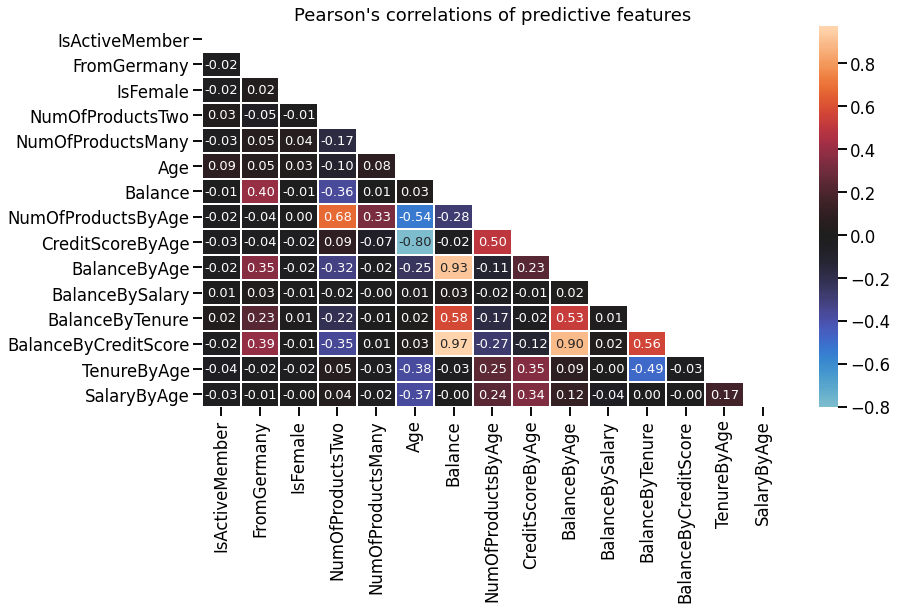

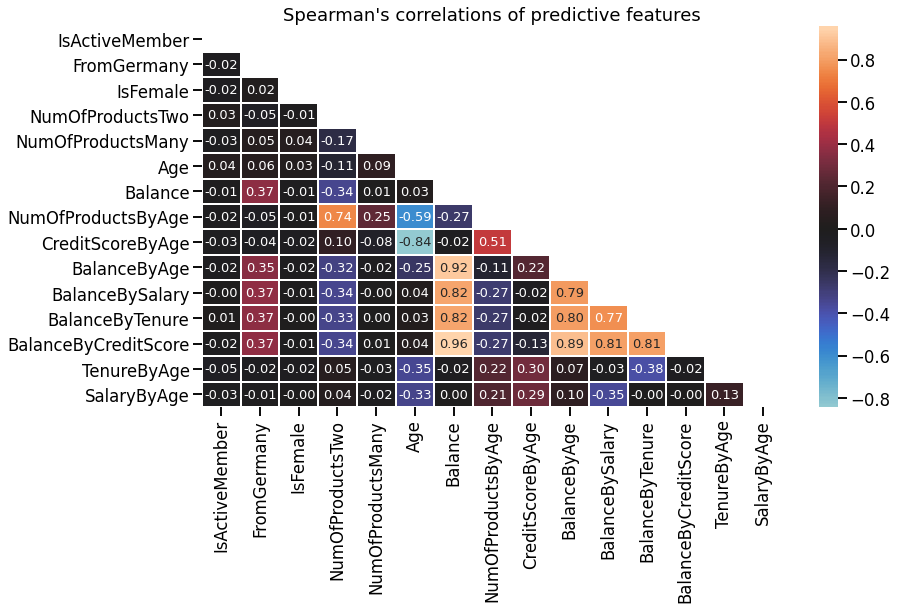

In [24]:
def correlation_plot(data, features = None, method = 'pearson', title = ""):
    '''Function printing correlation heatmap based on correlations of each possible pair of features
    
     Args:
         data, dataframe: dataset with features between which we want assess the correlations
         features, list of strings: list of features names on which we want to perform correlation analysis.
             By default None - all collumns from data will be used then
         method, string: argument passed to corr method of dataframe. Should be 'pearson', 'spearman' or 'kendall'
         title, string: custom title of the plot

     Returns:
         Nothing
    '''
    if features is not None:
        data_to_cor = data[features]
    else:
        data_to_cor = data
    
    corr = data_to_cor.corr(method = method)
    # Generate a mask for the upper triangle 
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Add the mask to the heatmap
    fig, ax = plt.subplots(figsize=(13,7))
    sns.heatmap(corr, mask=mask, center=0, linewidths=1, annot=True, fmt=".2f", annot_kws={"size":13})
    ax.set_title(title)
    plt.show()
    
correlation_plot(df_fe, predictive_features, title = "Pearson's correlations of predictive features")
correlation_plot(df_fe, predictive_features, method = 'spearman', title = "Spearman's correlations of predictive features")

Based on the results above and selected threshold of 0.8 we will exclude the following features:
* __BalanceByAge__, __BalanceBySalary__, __BalanceByTenure__, __BalanceByCreditScore__ - all of them are too highly correlated with original __Balance__ feature. It is not a big loss as all of them were rather weak in our Information Value assesment
* __CreditScoreByAge__ as it is too higly correlated (negatively) with __Age__. It is a strong variable looking at its Information Value but we expect that this strength comes from using the __Age__ in denominator which itself is very predictive while __CreditScore__ was excluded due to its low IV

Our final set of variables for modelling is therefore as follows:

In [25]:
selected_features = [x for x in predictive_features if x not in 
                        ['BalanceByAge', 'BalanceBySalary', 'BalanceByTenure', 'BalanceByCreditScore', 'CreditScoreByAge']
                    ]
selected_features

['IsActiveMember',
 'FromGermany',
 'IsFemale',
 'NumOfProductsTwo',
 'NumOfProductsMany',
 'Age',
 'Balance',
 'NumOfProductsByAge',
 'TenureByAge',
 'SalaryByAge']

We will take one final look on selected features' Information Values and correlations to make sure that we did not miss anything:

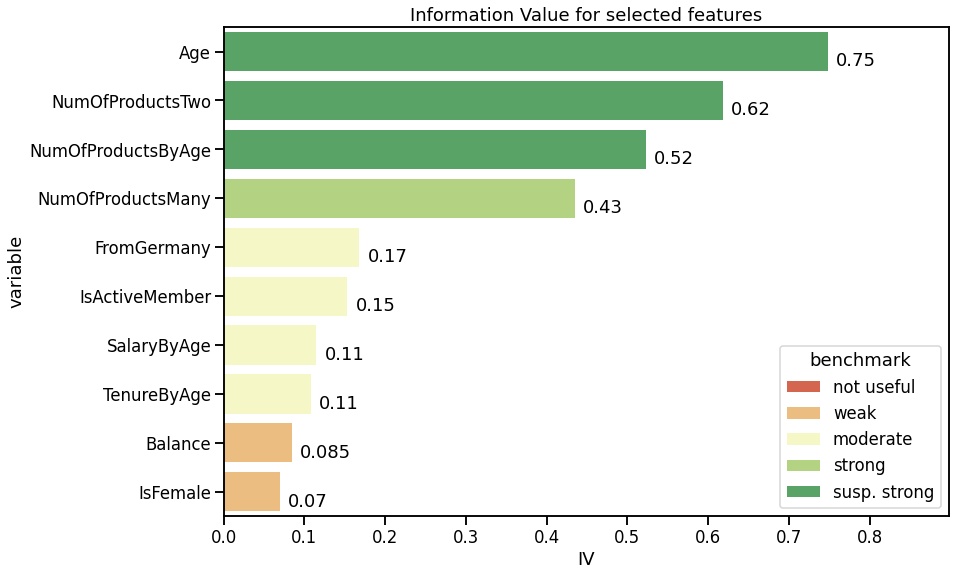

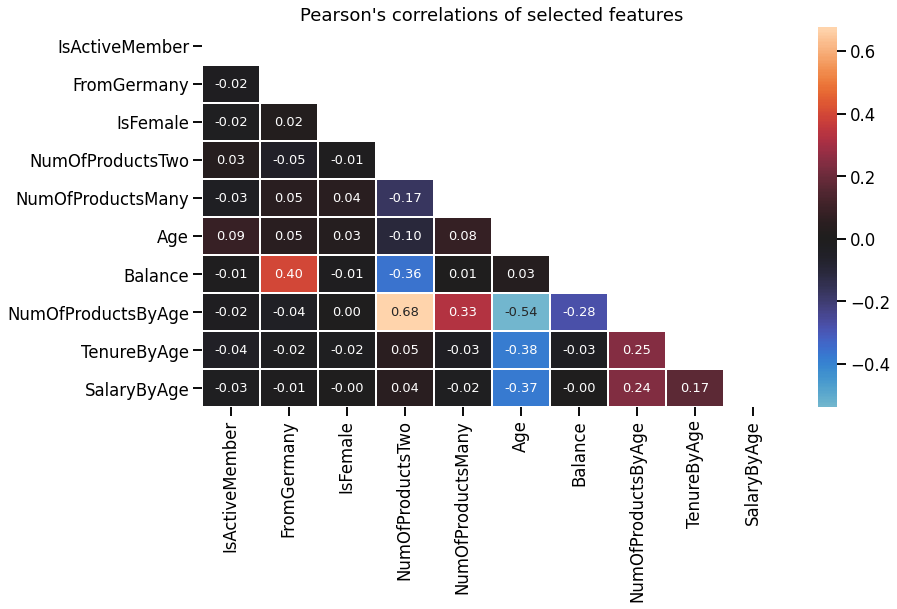

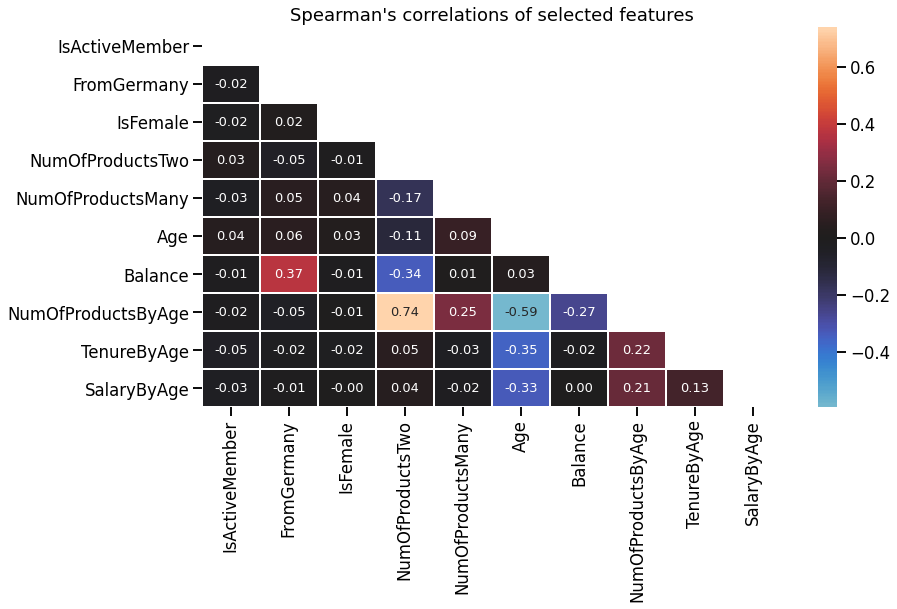

In [26]:
iv_barplot(df_woe_summary[df_woe_summary.variable.isin(selected_features)], "Information Value for selected features")
correlation_plot(df_fe, selected_features, title = "Pearson's correlations of selected features")
correlation_plot(df_fe, selected_features, method = 'spearman', title = "Spearman's correlations of selected features")

# Train / Test split
<a href="#Contents"><button type="button";>Back to ToC</button></a>

Before starting the modelling we will split our data into train and test set (with 70:30 proportion which is a common choice). We will train models (and perform hyperparameter tuning using cross-validation) on the train set and verify the final candidates on the test set. We will stratify the split by target variable to guarantee that the proportion of customers who exited is equal on train and test sets

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df_fe[selected_features], df_fe.Exited, test_size = 0.3, 
                                                   stratify = df_fe.Exited, random_state = 3103)

print("train set: ")
display(y_train.value_counts().to_frame("cnt").assign(pr = lambda x: ['{:.2%}'.format(p) for p in x.cnt / sum(x.cnt)]))
print("test set: ")
display(y_test.value_counts().to_frame("cnt").assign(pr = lambda x: ['{:.2%}'.format(p) for p in x.cnt / sum(x.cnt)]))

train set: 


cnt      pr
0  5574  79.63%
1  1426  20.37%

test set: 


cnt      pr
0  2389  79.63%
1   611  20.37%

In [2]:
# save and load python data structers to / from pickle files

def save_data(data, filename):
    '''Saves almost any data structure into <filename>.pkl in working directory
    
     Args:
         data, any type: any data structure to save
         filename, string: name of the file in which data will be saved

     Returns:
         Nothing
    '''
    pkl_file = open('./'+filename+'.pkl', 'wb')
    pickle.dump(data, pkl_file)
    pkl_file.close()
    
def load_data(filename):
    '''Loads contents of the pkl file in working directory
    
     Args:        
         filename, string: name of the file in which data will be loaded

     Returns:
         data, any type: any data structure saved in the chosen pkl file
    '''
    pkl_file = open('./'+filename+'.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [ ]:
# saving data preperation and split for further use
save_data([X_train, X_test, y_train, y_test], "train_test_split_list")

# Modelling
<a href="#Contents"><button type="button";>Back to ToC</button></a>

As we mentioned in the EDA, we have a case of class imbalance in our data - there are about 4 times more non-churners than churners. There are several ways of dealing with class imbalance. We can for example:
* downsample more frequent class
* upsample (by boostrap) less frequent class
* perform SMOTE (Synthetic Minority Oversampling Technique) i.e. generate new observations from less frequent class with similar feature values as in observations from this class
* mix techniques above

As the class imbalance is not that extreme in our case (like in for example detecting frauds where you can often see for example 1% of frauds, 99% non-frauds) we will not use any of these methods. We will, however, not use the default classes predicted by our models. We will be interested only in probabilities produced by these models and we will analyse what threshold would be the best in our case. Additinally, as part of our hyperparameters tuning we will test whether it is beneficial to increase the weights of observations from less frequent class.

We will use AUC (area under ROC curve) as the metric for scoring during hyperparameters tuning. We do not want to use accuracy because in case of class imbalance it is not a recommended metric. For each type of the model we will define grid of its hyperparameters to test and each set of parameters will be tested performing cross validation on training set. Parameters with the highest average AUC (across the folds playing role of test sets) will be selected for our best model from each type. 

In [4]:
# loading the saved, prepared data for modelling and evaluation
[X_train, X_test, y_train, y_test] = load_data("train_test_split_list")

## Logistic Regression
<a href="#Contents"><button type="button";>Back to ToC</button></a>

In case of logistic regression it is advisable to scale the features first in order to make their magnitude comparable. We will do it on the train set as part of our modelling pipeline, therefore when we will later use our model to predict on the unseen data, the scaling will be applied based on means and standard deviations from the train set. Other preprocessing steps can be also applied this way, for instance if we had missing data (fortunately it is not the case here) we would also be able to impute it directly in the modelling pipeline

In [5]:
def hyperparameter_tuning(X, y, model, grid, folds, repeats, scale = False, n_jobs = None, n_iter = None):
    '''Performs hyperparameter tuning for supplied model type. Uses stratified cross validation, which means
    that each fold contains approximately the same percentage of samples of each target class as the complete set.
    
     Args:
         X, dataframe: dataframe with features
         y, 0/1 series: series representing target variable
         model, sklearn model class: model type we want to tune and fit
         grid, dictionary: dictionary of parameters for model we want to test
         folds, integer: number of folds we will use in cross validation
         repeats, integer: number of times we want to rerun splitting to folds. 
             Thus for each set of hyperparameters we fit folds * repeats models
         scale, bool: whether to scale the features prior to fitting
         n_jobs, integer: Number of jobs to run in parallel. None means 1, -1 means all processors
         n_iter, integer: if None, we will apply GridSearchCV. Otherwise - RandomizedSearchCV with n_iter tested sets
             of hyperparameters

     Returns:
         tuner, GridSearchCV / RandomizedSearchCV object: SearchCV object fitted to supplied X and y
    '''

    # setup the pipeline steps. We want to use pipeline to potentially add the scaling of features as part of 
    # fitting the model to the training data
    steps = []
    if (scale == True):
        steps.append(('scaler',StandardScaler()))
    steps.append(('model',model))
    # create the pipeline
    pipeline = Pipeline(steps)
    # correct the grid to include modelling step name
    parameters = { ("model__"+k).replace(':', ''): v for k, v in grid.items() }
    # define cross validation strategy
    cv = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=3103)
    # create GridSearchCV / RandomizedSearchCV object
    if (n_iter is None):
        tuner = GridSearchCV(pipeline, parameters, 
                             cv = cv, verbose = 1,scoring='roc_auc', n_jobs = n_jobs)
    else:
        tuner = RandomizedSearchCV(pipeline, parameters, 
                             cv = cv, verbose = 1,scoring='roc_auc', n_jobs = n_jobs, random_state = 3103, n_iter = n_iter)
    # fit to the supplied X, y
    tuner.fit(X,y)
    return tuner


def show_best_params(tuner):
    '''Reads best hyperparameters from GridSearchCV / RandomizedSearchCV fitted object. 
    Removes the added "model__" from the hyperparameter_tuning function representing the 
    name of modelling step in that function
    
     Args:
         tuner, GridSearchCV / RandomizedSearchCV object: SearchCV object already fitted to some data

     Returns:
         dictionary: dictionary with original names of hyperparameters
    '''
    return { ("model__"+k).replace(':', '').replace('model__',''): v for k, v in tuner.best_params_.items() }

In [91]:
# logistic regression hyperparameters we want to test
hyperparams = {
    # we allow both L1 and L2 regularization
    "penalty": ['elasticnet'],
    # Inverse of regularization strength
    "C": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10],
    # l1_ratio = 0 => L2 regularization, l1_ratio=1 => L1 regularization. 
    # For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.
    "l1_ratio": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    # The balanced mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
    "class_weight": [None,'balanced'],
    # we need to choose this solver if we want to use elasticnet
    "solver": ['saga'],
    "random_state": [3103]
}

logistic_tuned = hyperparameter_tuning(X_train, y_train, LogisticRegression(), hyperparams, 
                                       folds = 5, repeats = 1, scale = True, n_jobs = 2)
save_data(logistic_tuned, "logistic_tuned")

Fitting 5 folds for each of 154 candidates, totalling 770 fits


The tunning process took about 25 seconds on our mediocre computer. Best hyperparameters from cross validation are as follows:

In [6]:
logistic_tuned = load_data("logistic_tuned")

In [93]:
show_best_params(logistic_tuned)

{'C': 0.01,
 'class_weight': 'balanced',
 'l1_ratio': 0.4,
 'penalty': 'elasticnet',
 'random_state': 3103,
 'solver': 'saga'}

The figure below summarises the results obtained during tunning:

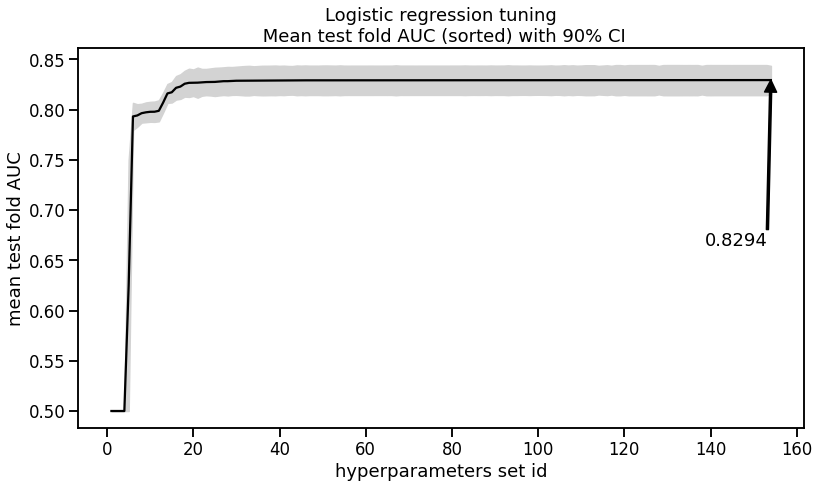

In [7]:
def plot_hyperparameters_impact(tuner, title):
    '''Summary of the mean scores obtained during hyperparameter tuning. Best mean AUC is printed on the plot
    
     Args:
         tuner, GridSearchCV / RandomizedSearchCV object: fitted SearchCV object with AUC scoring
         title, string: custom title of the plot

     Returns:
         Nothing
    '''
    
    y = tuner.cv_results_['mean_test_score']
    std = tuner.cv_results_['std_test_score']
    
    # 90% confidence interval (with normality assumption) based on the mean and std of observed AUC values
    data = pd.DataFrame({"y": y,"std": std}).sort_values(['y','std'], ascending = [True,False]).assign(
        x = list(range(1,len(y)+1)), 
        y_upper = lambda d: d['y']+1.67*d['std'], 
        y_lower = lambda d: d['y']-1.67*d['std'])

    fig, ax = plt.subplots(figsize=(13,7))
    sns.lineplot(y = "y", x = "x", data = data, ax = ax, color = 'black')
    plt.fill_between(x = 'x', y1 = 'y_lower', y2 = 'y_upper', data = data, color = 'lightgrey')
    ax.set_xlabel("hyperparameters set id")
    ax.set_ylabel("mean test fold AUC")
    ax.set_title(title)
    ax.annotate('{:.4}'.format(data.y.max()), 
                xy=(data.x.max(), data.y.max()),
                xytext =(0.9*data.x.max(),(data.y.min()+data.y.max())/2),
                arrowprops = {'facecolor':'black', 'width': 2})
    #plt.grid() 
    plt.show()

plot_hyperparameters_impact(logistic_tuned, 
                            'Logistic regression tuning\n Mean test fold AUC (sorted) with 90% CI')

## SVM
<a href="#Contents"><button type="button";>Back to ToC</button></a>

Similarly as in case of logistic regression we will scale the features as part of our modelling pipeline as it is also beneficial for this method

In [14]:
# SVM hyperparameters we want to test
hyperparams = {
    "kernel": ['rbf','sigmoid'],
    # Inverse of regularization strength
    "C": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10],
    # kernel coefficient
    'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    # The balanced mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
    "class_weight": [None,'balanced']
}

SVM_tuned = hyperparameter_tuning(X_train, y_train, SVC(), hyperparams, 
                                       folds = 5, repeats = 1, scale = True, n_jobs = 2)
save_data(SVM_tuned, "SVM_tuned")

Fitting 5 folds for each of 140 candidates, totalling 700 fits


The tunning process took almost 18 minutes on our mediocre computer. Best hyperparameters from cross validation are as follows:

In [15]:
SVM_tuned = load_data("SVM_tuned")

In [62]:
best_params_SVM = show_best_params(SVM_tuned)
best_params_SVM

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}

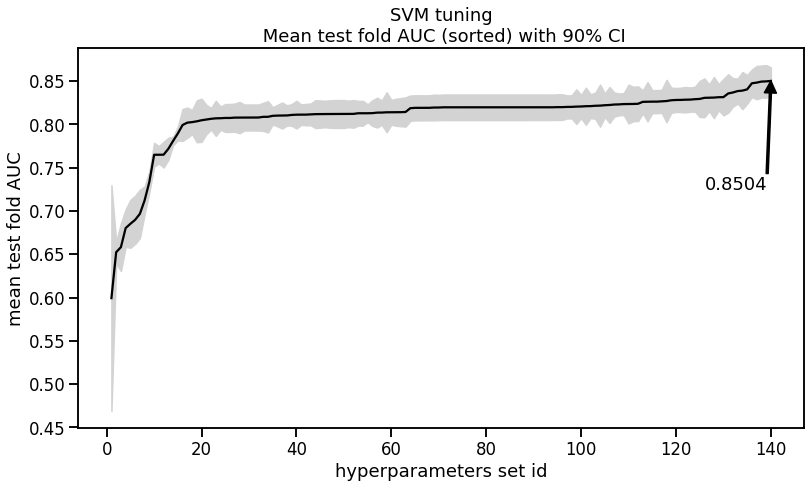

In [56]:
plot_hyperparameters_impact(SVM_tuned, 
                            'SVM tuning\n Mean test fold AUC (sorted) with 90% CI')

By default the SVM does not output probabilities. In scikit-learn we can allow it, although the docummentation states that it will slow down the fitting. That is why for the purpose of hyperparameter tunning we did not allow it. However, for our best model we would like to have the probabilities as they will be necessary to test various possible thresholds for our classification. For that reason, we will use our function designed for tunning but we will provide only one set of hyperparameters - the one that turned out the best out of tested grid but with probability calculation enabled

In [35]:
best_params_prob = { k.replace(':', ''): [v] for k, v in best_params_SVM.items() }
best_params_prob['probability'] = [True]
best_params_prob['random_state'] = [3103]
SVM_best_prob = hyperparameter_tuning(X_train, y_train, SVC(), best_params_prob, 
                                       folds = 2, repeats = 1, scale = True, n_jobs = 2)
save_data(SVM_best_prob, "SVM_best_prob")

Fitting 2 folds for each of 1 candidates, totalling 2 fits


## Random Forest
<a href="#Contents"><button type="button";>Back to ToC</button></a>

For tree-based methods the prior scaling of features is not necessary therefore we will skip that step this time

In [49]:
# Random forest hyperparameters we want to test
hyperparams = {
    # number of trees in the forest
    "n_estimators": [100,300,500],
    # number of features to consider when looking for the best split
    "max_features": ['sqrt',0.5,0.7],
    # minimum number of samples required to be at a leaf node
    "min_samples_leaf" : [2,10,30],
    # maximum depth of each tree
    "max_depth": [None,3,6],
    # The balanced mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
    "class_weight": [None,'balanced','balanced_subsample'],
    "random_state": [3103]
}

random_forest_tuned = hyperparameter_tuning(X_train, y_train, RandomForestClassifier(), hyperparams, 
                                       folds = 5, repeats = 1, scale = False, n_jobs = 2)
save_data(random_forest_tuned, "random_forest_tuned")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


The tunning process took about 24 minutes on our mediocre computer. Best hyperparameters from cross validation are as follows:

In [ ]:
random_forest_tuned = load_data("random_forest_tuned")

In [63]:
best_params_rf = show_best_params(random_forest_tuned)
best_params_rf

{'class_weight': None,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'n_estimators': 300,
 'random_state': 3103}

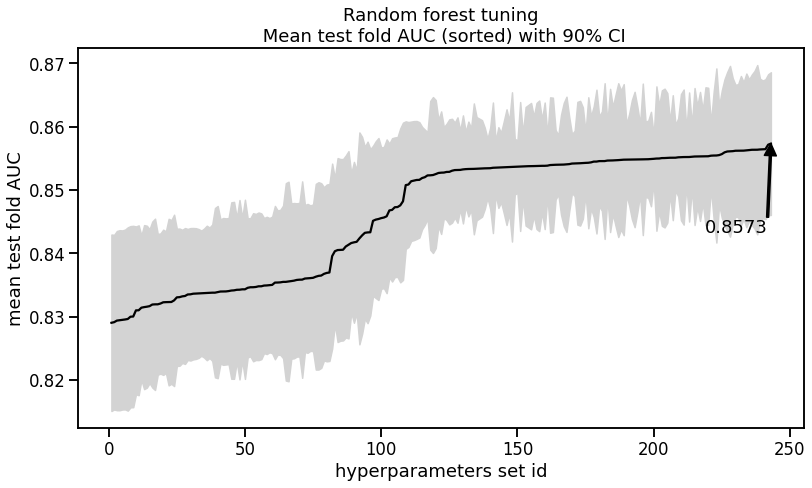

In [64]:
plot_hyperparameters_impact(random_forest_tuned, 
                            'Random forest tuning\n Mean test fold AUC (sorted) with 90% CI')

## XGBoost
<a href="#Contents"><button type="button";>Back to ToC</button></a>

XGBoost as a tree-based method also does not require scaling of features prior to fitting the model - therefore we will skip that step. XGBoost is one of the most effective classifiers and it has many interesting hyperparameters to specify. Consequently, it is also challenging to effectively search for the best hyperparameters (in terms of required computational time). We defined a relatively small dictionary with up to 4 values to try for each of the selected hyperparameters. As it can be seen from our calculation below, the number of unique combinantions grows exponentially with each added hyperparameter and it can quickly get overwhelmingly high

In [8]:
# XGBoost hyperparameters we want to test
hyperparams = {
    # number of boosting rounds = number of trees
    "n_estimators": [100,300,500,1000],
    # max depth of individual trees
    "max_depth": [None,3,8],
    # learning rates (eta)
    "learning_rate": [0.001,0.01,0.1,0.3],
    # minimum loss reduction required to make a further partition on a leaf
    "gamma": [0,1,5,10],
    # minimum sum of instance weight(hessian) needed in a child
    "min_child_weight": [0,1,5],
    # what share of training data use for each tree
    "subsample": [0.7,1],
    # what share of features use for each tree
    "colsample_bytree": [0.7,1],
    # L1 regularization of weights
    "reg_alpha": [0, 1, 5],
    # L2 regularization of weights
    "reg_lambda": [1, 2, 5],
    # obs. weights - 1 by default, in case of class imbalance the following is recommended :
    # (num. obs. from more frequent class) / (num. obs. from less frequent class) ,
    "scale_pos_weight": [1, sum(1-y_train) / sum(y_train) ],
    "random_state": [3103],
    "use_label_encoder": [False],
    # starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' 
    # was changed from 'error' to 'logloss'. We set it directly to prevent the warning
    "eval_metric": ["logloss"]
}
    
print("size of the grid (number of all combinations):", len(ParameterGrid(hyperparams)))

size of the grid (number of all combinations): 41472


For this reason, for XGBoost we will use Random Search, which will drow specified number of sets of hyperparameters from our grid

In [9]:
## time testing - 105 seconds for 10 iterations of RandomSearch
## it means ~ 175 minutes for 1000 iterations (roughly 3 hours) 
# XGBoost_tuned = hyperparameter_tuning(X_train, y_train, xgb.XGBClassifier(), hyperparams, 
#                                        folds = 5, repeats = 1, scale = False, n_jobs = 2, n_iter = 10)

XGBoost_tuned = hyperparameter_tuning(X_train, y_train, xgb.XGBClassifier(), hyperparams, 
                                        folds = 5, repeats = 1, scale = False, n_jobs = 2, n_iter = 4000)
save_data(XGBoost_tuned, "XGBoost_tuned")

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits


The tunning process took about __9.5 hours__ on our mediocre computer. Best hyperparameters from cross validation are as follows:

In [74]:
XGBoost_tuned = load_data("XGBoost_tuned")

In [80]:
best_params_xgboost = show_best_params(XGBoost_tuned)
best_params_xgboost

{'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'gamma': 10,
 'learning_rate': 0.1,
 'max_depth': None,
 'min_child_weight': 1,
 'n_estimators': 1000,
 'random_state': 3103,
 'reg_alpha': 0,
 'reg_lambda': 2,
 'scale_pos_weight': 1,
 'subsample': 0.7,
 'use_label_encoder': False}

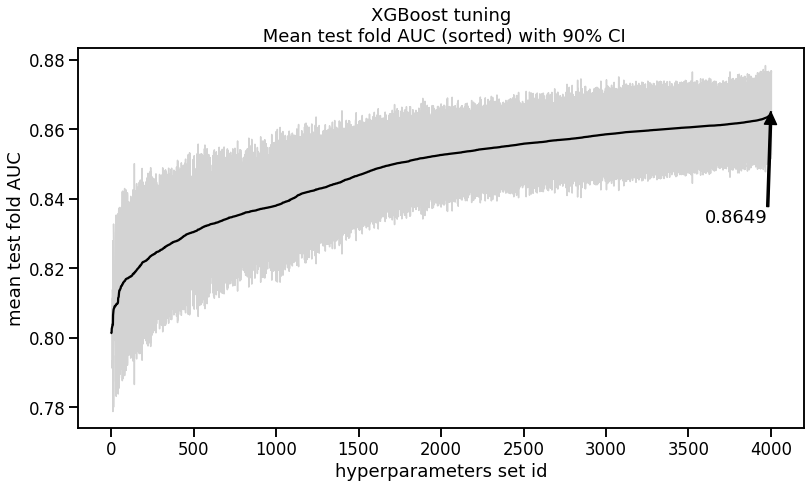

In [76]:
plot_hyperparameters_impact(XGBoost_tuned, 
                            'XGBoost tuning\n Mean test fold AUC (sorted) with 90% CI')

We tested 4000 hyperparameters which is less than 10% of our defined grid which itself is only a tiny part of whole hyperparameters space for XGBoost. If we were to contiunue our search for hyperparameters allowing for even better results, we could analyse what information we have already gathered. For example we can compare the distributions of obtained test scores from cross validation for selected pairs of tested hyperparameters. Several examples can be seen on figures below. Such analysis can often show the regions of hyperparameters space it is worth to explore.

In [73]:
def plot_params_comparison(tuner, p1, p2):
    '''Plots distribution of the AUC test scores from cross-validation (boxplots) separately for each combination
    of hyperparameters p1 and p2
    
     Args:
         tuner, GridSearchCV / RandomizedSearchCV object: fitted SearchCV object with AUC scoring
         p1, string: name of first hyperparameter (X axis)
         p2, string: name of second hyperparameter (hue)

     Returns:
         Nothing
    '''
    
    data = pd.DataFrame(tuner.cv_results_)
    # formatting scale_pos_weight for better looking legend on plots
    data.param_model__scale_pos_weight = ['{:.2f}'.format(x) for x in data.param_model__scale_pos_weight]
    # get the names of columns with test scores (5-fold cv -> 5 columns, 10-fold cv -> 10 columns, etc.)
    test_scores = [col for col in data if (col.startswith('split') & col.endswith('_test_score'))]
    # transform the data into long format
    # note1: we are using individual scores from each test fold, not the mean test score used to select best parameters
    # note2: this code is specific for tuners obtained by our function, where we used Pipeline and named modelling step
    #        'model'. That is why we need to add not only 'param_' but also 'model__' to the name of parameter
    melted_data = data.melt(id_vars = ['param_model__'+p1, 'param_model__'+p2], value_vars = test_scores).fillna(value='None')
    melted_data.columns = [p1,p2,'var','test AUC']

    sns.catplot(data = melted_data, kind = 'box', y = 'test AUC', x = p1, hue = p2, legend_out = True,
               height = 7, aspect = 12/7, palette = 'Blues')
    plt.title('boxplot: cross validation test AUC distribution - ' + p1 +' vs ' + p2)
    plt.show()    

We can clearly see which values of learning_rate and n_estimators works best for our data (although it is interesting that the box for combination that won our cross validatation - learning rate 0.1 and n_estimators = 1000 - is not the best in general)

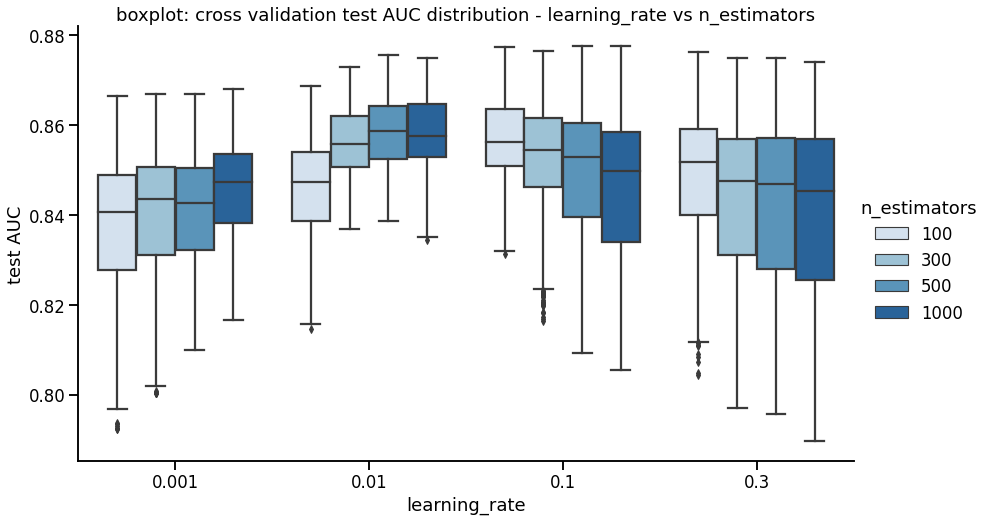

In [61]:
plot_params_comparison(XGBoost_tuned, "learning_rate", "n_estimators")

Scale_pos_weight appropriate for our classes proportion if anything hindered the performance. Higher gamma values are better on our data:

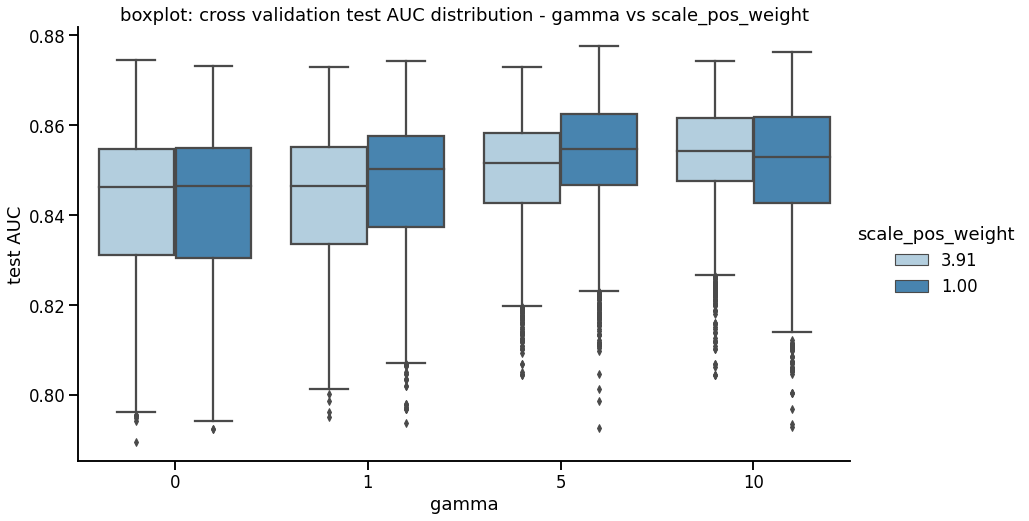

In [72]:
plot_params_comparison(XGBoost_tuned, "gamma", "scale_pos_weight")

Regularization parameters did not have visible impact on performance (it may be because we have only 10 features. Typically the more features we use the higher the risk of picking up the noise instead and overfitting - this is when the regularization is needed the most)

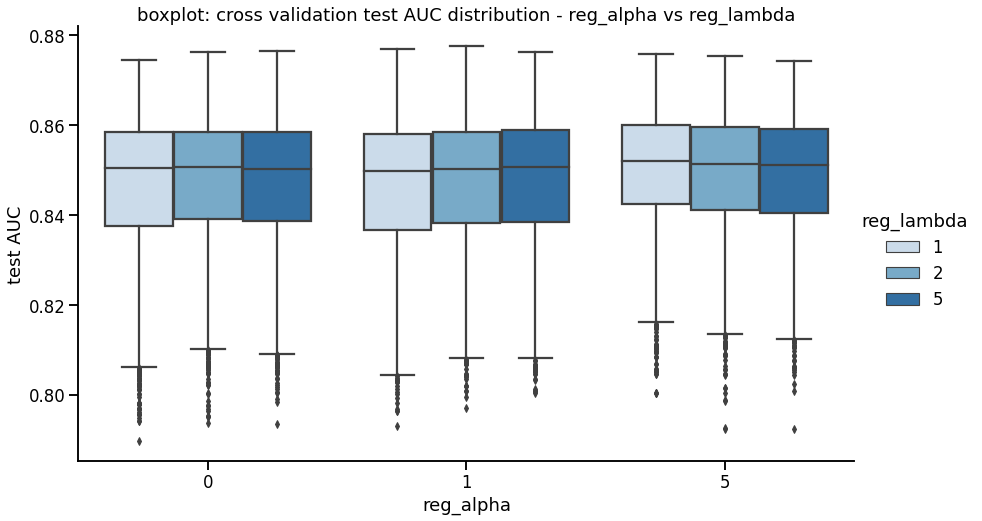

In [63]:
plot_params_comparison(XGBoost_tuned, "reg_alpha", "reg_lambda")

We can see that the impact of min_child_weight is marginal while judging by the spread of results it seems to better leave max_depth without limit

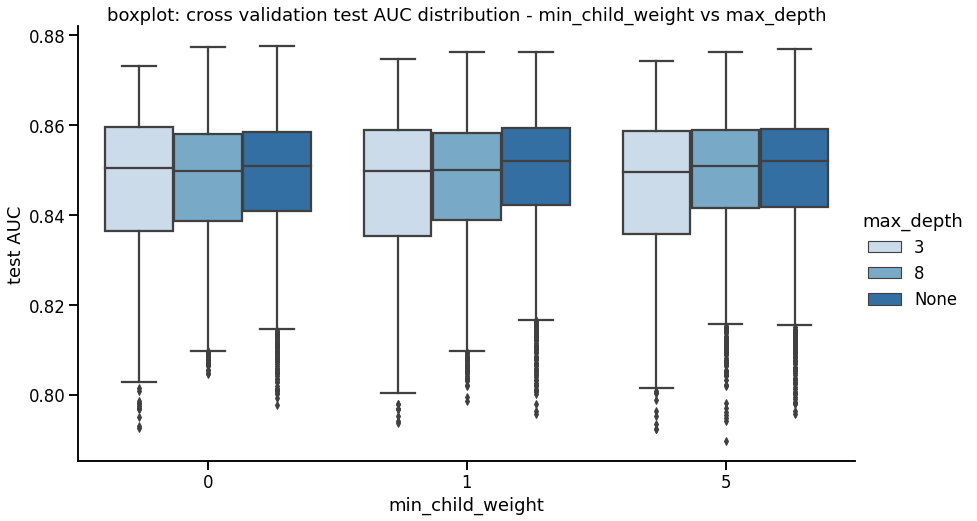

In [79]:
plot_params_comparison(XGBoost_tuned, "min_child_weight", "max_depth")

From the figure below it seems that subsample = 1 and colsample_bytree = 0.7 have the slight edge in terms of observed models' performance (however for our cross validation winner both equaled 0.7)

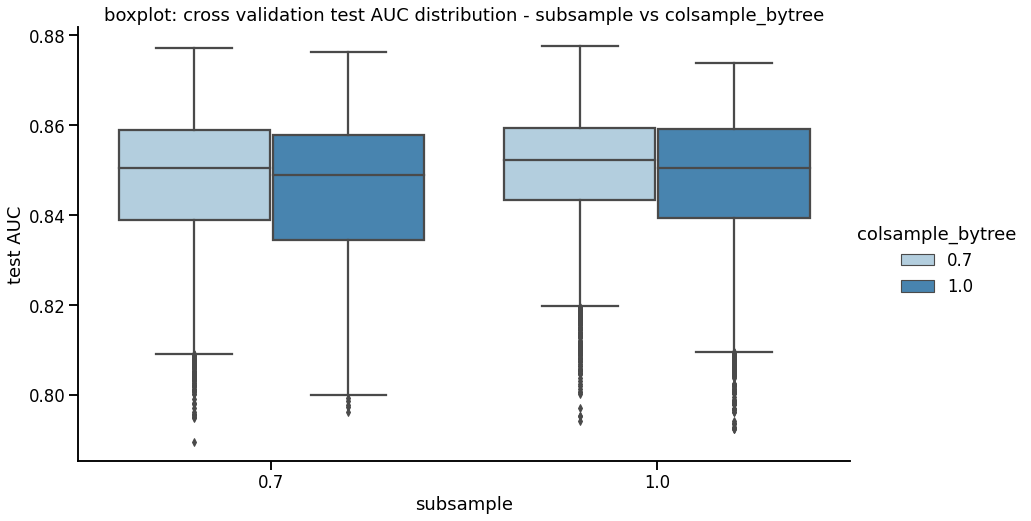

In [95]:
plot_params_comparison(XGBoost_tuned, "subsample", "colsample_bytree")

The figures above showed that in case of our data if there is something worth exploring it is learning_rate and n_estimators parameters. We will define new small grid with some additional values of these parameters around currently selected as best. Other parameters will be set to the optimal values from our initial search

In [81]:
# additional XGBoost hyperparameters we want to test
hyperparams = {
    # number of boosting rounds = number of trees
    "n_estimators": [800,1000,1200],
    # max depth of individual trees
    "max_depth": [None],
    # learning rates (eta)
    "learning_rate": [0.005,0.008,0.01,0.012,0.015,0.02, 0.05,0.08,0.1,0.12,0.15,0.2],
    # minimum loss reduction required to make a further partition on a leaf
    "gamma": [10],
    # minimum sum of instance weight(hessian) needed in a child
    "min_child_weight": [1],
    # what share of training data use for each tree
    "subsample": [0.7],
    # what share of features use for each tree
    "colsample_bytree": [0.7],
    # L1 regularization of weights
    "reg_alpha": [0],
    # L2 regularization of weights
    "reg_lambda": [2],
    # obs. weights - 1 by default, in case of class imbalance the following is recommended :
    # (num. obs. from more frequent class) / (num. obs. from less frequent class) ,
    "scale_pos_weight": [1],
    "random_state": [3103],
    "use_label_encoder": [False],
    # starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' 
    # was changed from 'error' to 'logloss'. We set it directly to prevent the warning
    "eval_metric": ["logloss"]
}
    
print("size of the additional grid (number of all combinations):", len(ParameterGrid(hyperparams)))

size of the additional grid (number of all combinations): 36


As the number of combinations is small, this time we will use grid search and verify all possibilities

In [82]:
XGBoost_grid2_tuned = hyperparameter_tuning(X_train, y_train, xgb.XGBClassifier(), hyperparams, 
                                        folds = 5, repeats = 1, scale = False, n_jobs = 2)
save_data(XGBoost_grid2_tuned, "XGBoost_grid2_tuned")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


The tunning process took about 11 miutes on our mediocre computer. Best hyperparameters from cross validation are as follows:

In [88]:
best_params_xgboost = show_best_params(XGBoost_grid2_tuned)
best_params_xgboost

{'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'gamma': 10,
 'learning_rate': 0.1,
 'max_depth': None,
 'min_child_weight': 1,
 'n_estimators': 1200,
 'random_state': 3103,
 'reg_alpha': 0,
 'reg_lambda': 2,
 'scale_pos_weight': 1,
 'subsample': 0.7,
 'use_label_encoder': False}

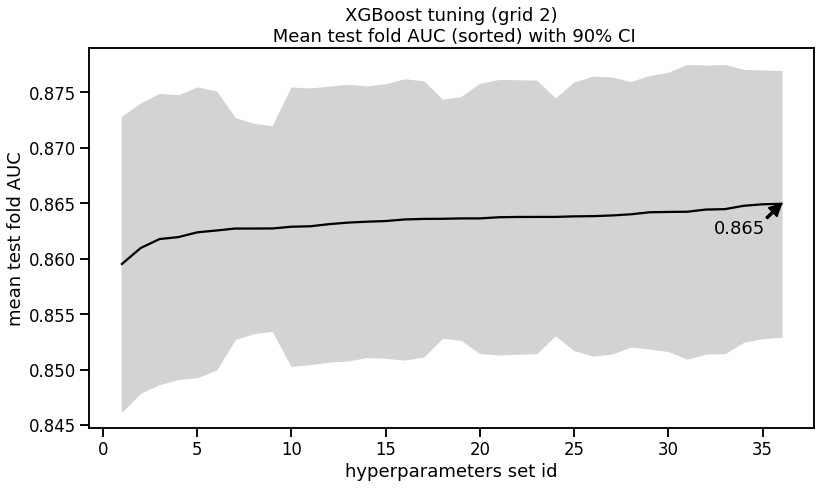

In [92]:
plot_hyperparameters_impact(XGBoost_grid2_tuned, 
                            'XGBoost tuning (grid 2)\n Mean test fold AUC (sorted) with 90% CI')

As it can be seen, we obtained marginally better result by adding additional 200 trees to our model but the best learning_rate remained the same. With more time and computational power we would probably be able to get even better results, however for the purpose of this project we will assess these results as sufficient - winner from grid 2 will advance to the next step of our project

# Models comparison
<a href="#Contents"><button type="button";>Back to ToC</button></a>

## ROC curve and AUC
<a href="#Contents"><button type="button";>Back to ToC</button></a>

In this section we will be comparing our models (best ones from each type obtained through hyperparameters tuning with cross validation on training set). Comparisons will be done on the test set which up to now was left completly aside and this will be first time our models will "see" these data

In [99]:
# loading the saved, prepared data for modelling and evaluation
[X_train, X_test, y_train, y_test] = load_data("train_test_split_list")
# loading the saved best models from each type
LR = load_data("logistic_tuned").best_estimator_
SVM = load_data("SVM_best_prob")
RF = load_data("random_forest_tuned").best_estimator_
XGB = load_data("XGBoost_grid2_tuned").best_estimator_

We will start by looking at the ROC curves and calculating the AUC for these models on the test set. The results are presented on the figures below

In [3]:
def compare_ROC_curve(models, models_names, X, y, FPR_range = (0,1)):
    '''Function plotting ROC curves for provided list of models based on supplied data and targets.
    Additionally AUC is calculated and presented in the legend
    
     Args:
         models, list: list of models (from class with method predict_proba)
         models_names, list of strings: list of names to show on the legend
         X, dataframe: dataframe with features used by supplied models
         y, series with 0/1 values: list with values of target variable (for corresponding rows of X)
         FPR_range, tuple: range of FPR values we want to see (it allows to zoom the plot on interesting range of FPR)
         
     Returns:
         Nothing
    '''
    
    # initialize empty dataframe
    plot_data = pd.DataFrame()
    
    # loop through models list
    for i, m in enumerate(models):
        # predict and gather probabilities for class 1
        try:
            y_pred_proba = m.predict_proba(X)[:,1]
        # except added for a function to work with deep learning models and their predict method
        # (with sigmoid activation for final layer with 1 unit)
        except: 
            y_pred_proba = m.predict(X)
        # calculate points for roc curve
        fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_proba)
        # calculate AUC
        auc = metrics.roc_auc_score(y, y_pred_proba)
        # add the results to data for plot (long format to hue by model)
        plot_data = plot_data.append(
            pd.DataFrame({"FPR" : fpr, "TPR" : tpr}).assign(
                model = models_names[i] + ' (AUC = {:.4f})'.format(auc)
            ))
    
    fig, ax = plt.subplots(figsize=(13,9))
    sns.lineplot(x = 'FPR', y = 'TPR', hue = 'model', style = 'model', data = plot_data, ax = ax)
    plt.plot([0, 1], [0, 1], "k--")
    ax.set_title('ROC curves for compared models')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set(xlim=FPR_range)
    plt.yticks(np.linspace(0,1,11))
    plt.grid(linestyle='dotted', linewidth=1)
    plt.show()

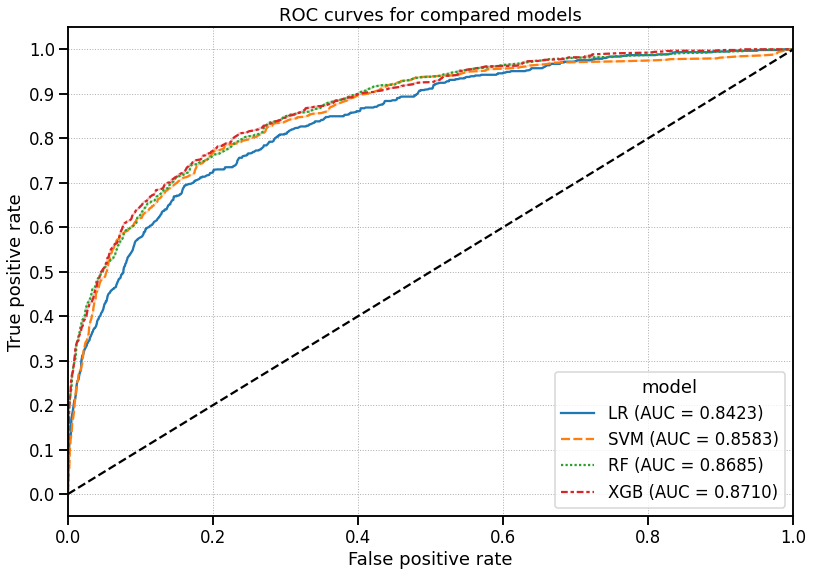

In [100]:
compare_ROC_curve([LR, SVM, RF, XGB], ["LR", "SVM", "RF", "XGB"], X_test,y_test)

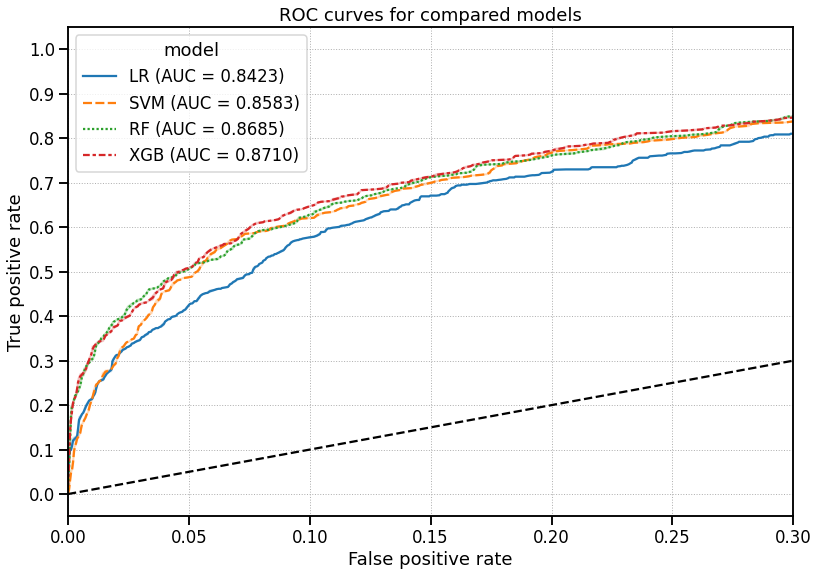

In [121]:
compare_ROC_curve([LR, SVM, RF, XGB], ["LR", "SVM", "RF", "XGB"], X_test,y_test, (0,0.3))

There are several observations to make here:
* first of all - good job! All 4 models representing 4 different methods works well on data they did not "see" before. Common benchmark is that AUC > 0.85 means high classification performance and 3 of our models suprasses this threshold and 1 is really close
* the observed performance on the unseen data is similar to performance noted during cross validation and the order of obtained results is the same (logistic regression - lowest AUC, XGBoost - highest AUC)
* the inspection of ROC curves reveals why AUC is not the only thing worth checking. For example:
    * even though XGBoost scored highest AUC, for some low values of False positive rate we achieve higher True positive rate with our Random Forest (and the area of relatively low False positive rates is the most important for us when it comes to real world usage of models)
    * Although the logistic regression is worse by less then 0.03 in terms of AUC from XGBoost, for low values of False positive rates we see about 10 percentage points lower True positive rates for logistic regression than in case of XGBoost! That is a really material difference!

## Precision-recall curve
<a href="#Contents"><button type="button";>Back to ToC</button></a>

As we already hinted when noticing class imbalance - we would like to focus on positive class, i.e. churners. Instead of looking at the False positive rate, where in denominator we have the total number of Negative class, we may want to inspect precision which is % of true positives in all predicted positive. Typically curve after such change on X axis is called precision-recall curve (as other name for True positive rate is recall). Additionally we will calculate 2 measures connected with precision and recall:
* max value of F1 score (which is a harmonic mean of precision and recall)
* average precision which summarises precision-recall curve - it is the mean of precisions for each threshold weighted by the increase in recall from the previous threshold. Although it is not exactly area under the precision-recall curve, it is summary of it in one number, similarily as AUC for ROC curve. 

In [139]:
def compare_PR_curve(models, models_names, X, y, P_range = (0,1)):
    '''Function plotting precision-recall curves for provided list of models based on supplied data and targets.
    Additionally max(F1_score) and average precision is calculated
    
     Args:
         models, list: list of models (from class with method predict_proba)
         models_names, list of strings: list of names to show on the legend
         X, dataframe: dataframe with features used by supplied models
         y, series with 0/1 values: list with values of target variable (for corresponding rows of X)
         P_range, tuple: range of precision values we want to see 
             (it allows to zoom the plot on interesting range of precision)
         
     Returns:
         Nothing
    '''
    
    # initialize empty dataframe
    plot_data = pd.DataFrame()
    
    # loop through models list
    for i, m in enumerate(models):
        # predict and gather probabilities for class 1
        y_pred_proba = m.predict_proba(X)[:,1]
        # calculate points for roc curve
        precision, recall, thresholds = metrics.precision_recall_curve(y, y_pred_proba)
        # calculate max f1 score
        f1 = max(2*precision*recall/(precision + recall))
        # calculate average precision
        ap = metrics.average_precision_score(y, y_pred_proba)
        # add the results to data for plot (long format to hue by model)
        plot_data = plot_data.append(
            pd.DataFrame({"precision" : precision, "recall" : recall}).assign(
                model = models_names[i] + ' (max(F1) = {:.2%}, AP = {:.2%})'.format(f1, ap)
            ))
    
    fig, ax = plt.subplots(figsize=(13,9))
    sns.lineplot(x = 'precision', y = 'recall', hue = 'model', style = 'model', data = plot_data, ax = ax)
    ax.set_title('Precision-recall curves for compared models')
    ax.set_xlabel('Precision (% true positives in all predicted positive)')
    ax.set_ylabel('Recall (% true positives in all actually positive)')
    ax.set(xlim=P_range)
    plt.yticks(np.linspace(0,1,11))
    plt.grid(linestyle='dotted', linewidth=1)
    plt.show()

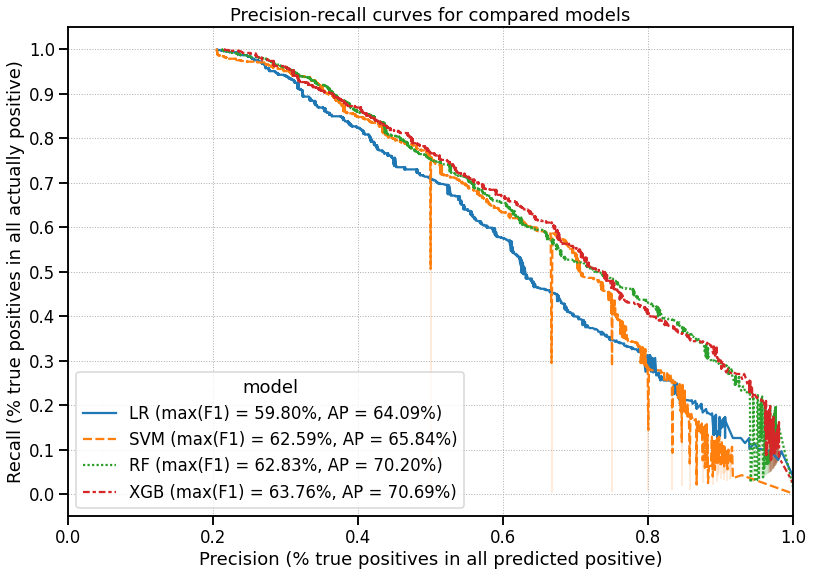

In [141]:
compare_PR_curve([LR, SVM, RF, XGB], ["LR", "SVM", "RF", "XGB"], X_test,y_test)

On the figure above we can see the same ranking of our models as in case of AUC and ROC (in general LR < SVM < RF < XGB in terms of predictive power). It supports the argument that the AUC metric is not a wrong choice for cross validation even in case of class imbalance. Of course one could argue it would be better to use average precision for cross validation but the fact that ranking of our models remains the same makes us believe we would not get considerably better models that way (at least not in case of this dataset)

## Cut-off selection
<a href="#Contents"><button type="button";>Back to ToC</button></a>

After implementing the classification model we always have to decide how it will be making decisions. The default classes predicted by models are based on cut-off 50% i.e if the probability of class 1 is higher than 50% then the model will predict class 1. But we are not forced to use this default threshold given that we can calculate the probabilities. It is especially crucial for data with class imbalance such as in case of this project (as it may to be simply too rare for our data to achieve probability higher than 50% and the model would predict class 1 too rare for our needs). 

The important factor here are our costs - does treating the observation from positive class as negative costs us as much as falsely saying that observation from negative class is in positive (and thus making some actions)? In case of churn problem the cost of acquiring a new customer is usually higher than the cost of keeping the current one (which can often be a matter of phone call and identifying the customer's problems / needs). It may especially be the case for smaller portfolios of rich customers. For such cases we would like to see high recall (we want to capture as many observations from positive class - here churners - as possible) and we can allow some share of false positives i.e. we can accept lower precision (we can afford the call for some customers who would not churn even without our action).

One way of selecting the cut-off would be for example stating that we can handle up to 15% of false positive rate and reading from ROC curve what true positive rate we can get (but it would require some cost assesment for our particular problem). We will test and present here 3 ways of calculating "optimal" cut-off:
* using Matthews correlation coeffictient calculated as follows:
\begin{equation}
{\displaystyle \mathrm {MCC} ={\frac {\mathrm {TP} \times \mathrm {TN} -\mathrm {FP} \times \mathrm {FN} }{\sqrt {(\mathrm {TP} +\mathrm {FP} )(\mathrm {TP} +\mathrm {FN} )(\mathrm {TN} +\mathrm {FP} )(\mathrm {TN} +\mathrm {FN} )}}}}
\end{equation}
we will select the threshold which maximizes MCC. To quote the wikipedia: _"While there is no perfect way of describing the confusion matrix of true and false positives and negatives by a single number, the Matthews correlation coefficient is generally regarded as being one of the best such measures"_
* using already mentioned F1 score - harmonic mean of precision and recall:
\begin{equation}
{\displaystyle F1=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}}
\end{equation}
we will select the threshold which maximizes F1.
* if for our purposes high recall is more important than high precision we can use generalised version of F1 score:
\begin{equation}
F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}
\end{equation}
we will select the threshold which maximizes F_beta. Typically used beta values are 2 and 0.5. We will focus on recall so we will choose beta = 2 (we could give even more importance to recall if we want but we will test it with standard value)

We will compare these 3 approaches on the test set (we assume that cut-off value assesment performed on the test set will yield similar results as we will observe on new data after model's implementation)

In [8]:
def MCC(TP,TN,FP,FN):
    '''Calculates Matthews correlation coefficients
    
     Args:
         TP, array / series: True positive counts
         TN, array / series: True negative counts
         FP, array / series: False positive counts
         FN, array / series: False negative counts
         
     Returns:
         array / series: calculated MCC values
    '''  
    return ((TP*TN)-(FP*FN))/(np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))

def cutoff_assesment(models, models_names, thresholds, X, y, beta):
    '''Produce classification diagnostics for given models, probability thresholds, features data and target
    
     Args:
         models, list: list of models (from class with method predict_proba)
         models_names, list of strings: list of names to add to the dataframe
         thresholds, array: list of probability thresholds above which we will predict positive class
         X, dataframe: dataframe with features used by supplied models
         y, series with 0/1 values: list with values of target variable (for corresponding rows of X)
         beta, float: one of calculated measures is Fbeta which uses this parameter. For values > 1,
             Fbeta will treat recall as more important than precision
         
     Returns:
         results, dataframe: dataframe with row for each model and threshold with the following 
             classification diagnostics: TP, FN, FP, TN, precision, recall, accuracy, MCC, F1, Fbeta.
             There are 3 additional columns indicating the rows with maximal MCC, F1 and Fbeta for each model           
    '''   
    # initialize empty dataframe for results
    results = pd.DataFrame()
    for i, m in enumerate(models):
        # predict and gather probabilities for class 1
        y_pred_proba = m.predict_proba(X)[:,1]
        # dataframe with column for each threshold and row for each observation 
        # with True if predicted probability > threshold and False otherwise
        preds_matrix = pd.DataFrame(np.array([(y_pred_proba > x) for x in thresholds]), index = thresholds).T
        # combine results for each model
        results = results.append(
            # dataframe with row for each threshold and classification diagnostics in columns
            pd.concat(
                [pd.DataFrame({"model" : models_names[i],
                               "cut_off" : x,
                               "TP" : [sum(np.array(preds_matrix[x] == True)*np.array(y == 1))],
                               "FN" : [sum(np.array(preds_matrix[x] == False)*np.array(y == 1))],
                               "FP" : [sum(np.array(preds_matrix[x] == True)*np.array(y == 0))],
                               "TN" : [sum(np.array(preds_matrix[x] == False)*np.array(y == 0))]}) 
                 for x in preds_matrix]).reset_index(drop = True).assign(
                precision = lambda x: x.TP / (x.TP + x.FP),
                recall = lambda x: x.TP / (x.TP + x.FN),
                accuracy = lambda x: (x.TP + x.TN)/(x.TP+x.FN+x.FP+x.TN),
                MCC = lambda x: MCC(x.TP,x.TN,x.FP,x.FN),
                F1 = lambda x: 2*(x.precision*x.recall)/(x.precision+x.recall),
                Fbeta = lambda x: (1+beta**2)*(x.precision*x.recall)/((beta**2)*x.precision+x.recall),
                max_MCC = lambda x: x.MCC == np.max(x.MCC),
                max_F1 = lambda x: x.F1 == np.max(x.F1),
                max_Fbeta = lambda x: x.Fbeta == np.max(x.Fbeta)
            )
        )
    return results  
    
def plot_best_cutoff(cutoff_assesment_df, method = "max_MCC"):
    '''Produce bar plots of classification diagnostics based on data from cutoff_assesment function.
    Diagnostics are based on the best (in terms of selected method) probability threshold for each model
    
     Args:
         cutoff_assesment_df, dataframe: dataframe produced by cutoff_assesment function
         method, string: Has to be one of "max_MCC", "max_F1" or "max_Fbeta"
         
     Returns:
         Nothing         
    ''' 
    plots_data = cutoff_assesment_df.query(method + " == True"). \
        drop_duplicates(subset = [n for n in list(cutoff_assesment_df.columns) if (n != 'cut_off')])
    fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (15, 12), sharex = True)
    for i, y in enumerate([method.replace("max_",""), "accuracy", "precision", "recall", "TP", "FN", "FP", "TN"]):
        a = ax[int(np.floor(i/2))][int(i-np.floor(i/2)*2)]
        sns.barplot(x = "model", y = y, data = plots_data, ax = a)
        a.set_title(y)
        a.set_xlabel("")
        a.set_ylabel("")
        # adding labels for bars
        for p in a.patches:
            if (i < 4):
                a.annotate('{:.2%}'.format(p.get_height()), (p.get_x()+0.1, 0.05), fontsize = 15)
            else:
                a.annotate(int(p.get_height()), (p.get_x()+0.2, 40), fontsize = 15)
    plt.suptitle(method + ": obtained max value + other classification diagnostics")
    plt.show()

In [9]:
cutoff_data = cutoff_assesment([LR, SVM, RF, XGB], ["LR", "SVM", "RF", "XGB"], 
                               # 1000 possible cut-off values
                               np.linspace(0,1,1000), 
                               X_test, y_test, beta = 2)

Figure below shows the results for cut-off value based on maximising MCC. XGBoost achieved the highest MCC and recall and SVM scored best precision and accuracy marginally higher than XGBoost (which was second best in terms of precision and accuracy). Given that we mostly cared about highest MCC, XGBoost is our winner here.

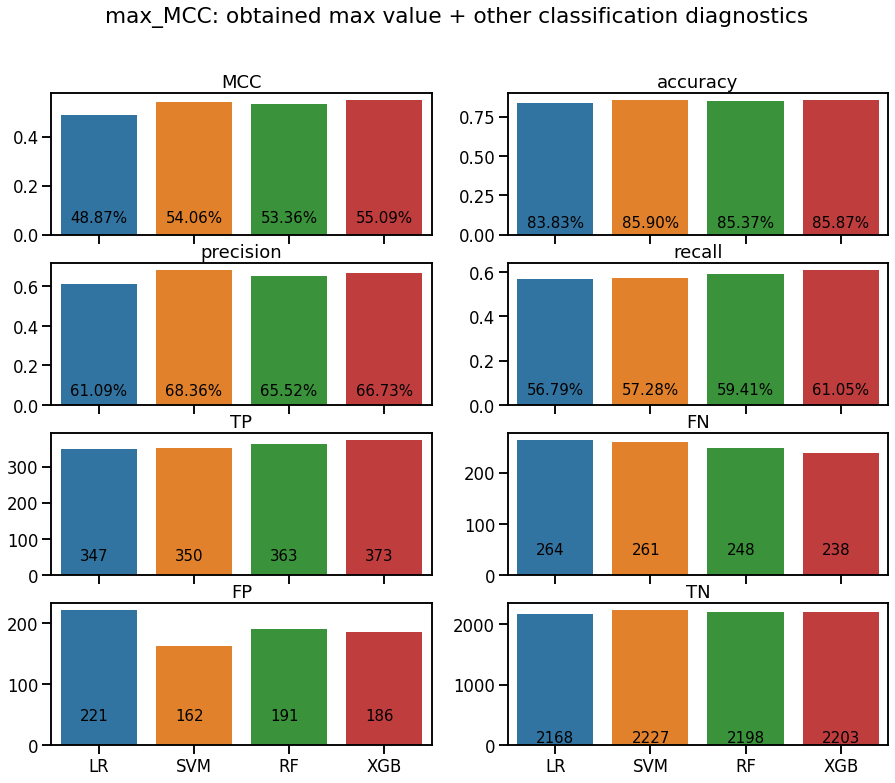

In [334]:
plot_best_cutoff(cutoff_data, "max_MCC")

Selecting cut-offs maximising F1 we obtained interesting differences between the models:
* for logistic regression we got visibly highest recall at the cost of much lower precision (and consequently highest number of False positives). F1 and accuracy was the lowest out of 4 models
* SVM again won in terms of precision and scored second highest accuracy but its recall was the lowest
* for random forest we got second best recall and F1
* XGBoost again won in terms of the measure we were interested in this time - F1. It can be noticed that in fact we ended up with the same threshold as in case of maximising MCC. We also got highest accuracy

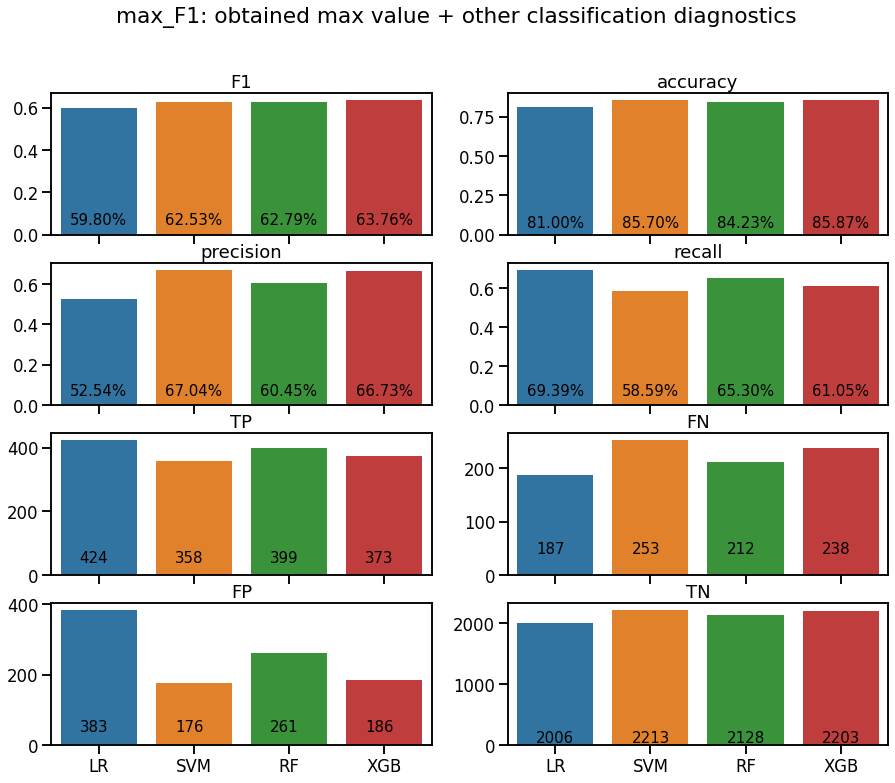

In [335]:
plot_best_cutoff(cutoff_data, "max_F1")

Fbeta with beta = 2 is not as balanced as F1 and MCC but this is our intention as we want to indicate the importance of recall (easier and cheaper to retain customer than acquire a new one). Although XGBoost scored the lowest recall here, it allowed for highest precision and overall highest Fbeta (closely followed by random forest), so it is again a winner for a measure we wanted to maximise. Going back to our precision-recall plot we see that if we were to state the minimal precision we can afford (in terms of costs of additional work with false positives) then XGBoost most often would allow us to get highest recall (for some precision values random forest is better in terms of recall). We also see the highest accuracy for XGBoost although it should be reminded that if we care only about accuracy even predicting "no churn" for all customers would have higher accuracy (as we have almost 80% of customers who did not churn). If we want to maximise accuracy, with XGBoost and Random forest we could exceed 86% (random forest slightly outperforms XGBoost in that regard)

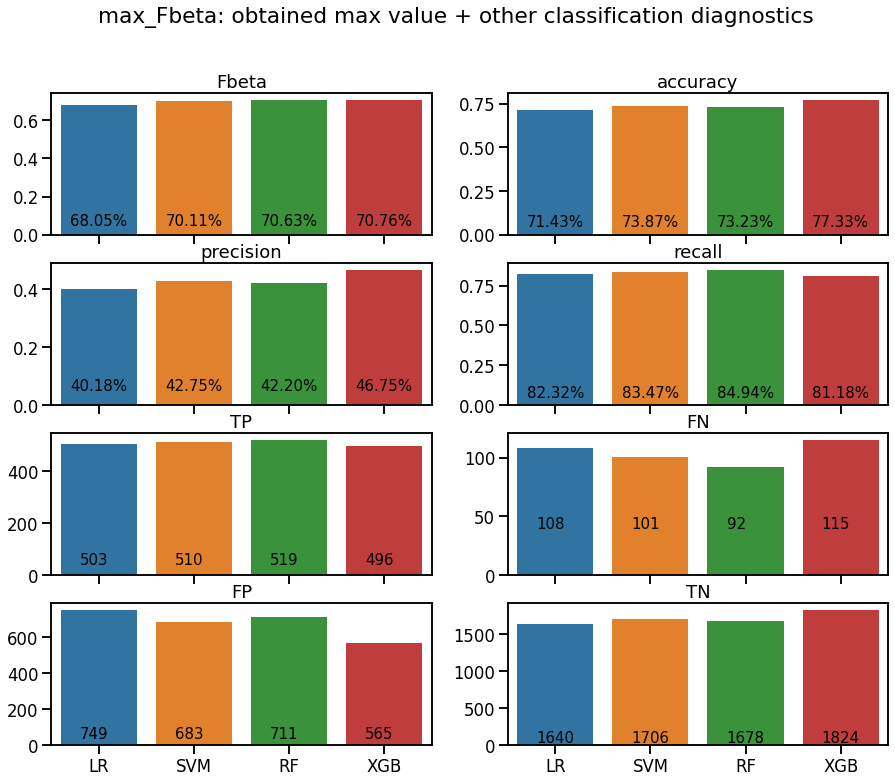

In [336]:
plot_best_cutoff(cutoff_data, "max_Fbeta")

In [12]:
# verifying maximal accuracy of our models
cutoff_data.groupby('model', as_index = False).agg(max_accuracy = ('accuracy',max)).sort_values('max_accuracy')

model  max_accuracy
0    LR      0.844667
2   SVM      0.859667
3   XGB      0.862333
1    RF      0.863667

## Selected model
<a href="#Contents"><button type="button";>Back to ToC</button></a>

In the previous subsections we showed that out of 4 models chosen as the best of their kind after some amount of hyperparameters tuning with cross validation, our XGBoost model has overall the highest performance. As we discussed, cut-off value above which we would predict positive class (here churn) can be selected in many ways. It is all a matter of stating what is the most important for us and analysing the costs of false positives vs false negatives. Because in churn problems often high recall is what we need, we will choose the cut-off maximising Fbeta with beta = 2 out of tested ones.

In [30]:
# cut-offs we calculated - we select one with max_Fbeta but will show other tested for reference
cutoff_data.query("model == 'XGB' & (max_Fbeta == True | max_MCC == True | max_F1 == True)"). \
    drop_duplicates(subset = ['TP', 'TN'])

model   cut_off   TP   FN   FP    TN  precision    recall  accuracy  \
162   XGB  0.162162  496  115  565  1824   0.467484  0.811784  0.773333   
357   XGB  0.357357  373  238  186  2203   0.667263  0.610475  0.858667   

          MCC        F1     Fbeta  max_MCC  max_F1  max_Fbeta  
162  0.484578  0.593301  0.707561    False   False       True  
357  0.550877  0.637607  0.621046     True    True      False

We will modify the predict method of our XGBoost model to implement the cut-off we chose. Below we can see the results which are in accordance with summary above when it comes to prediction with custom cut-off. We can see that:
* instead of predicting only half of customers who exited correctly we caught over 80% of them with a new cut-off
* it comes as a cost of treating over 23% of customers who stayed as churners while with default cut-off we did that to less than 5% of them
* this is exactly what we signed for deciding how much more important for us is high recall insted of high precission (beta = 2, Fbeta as cut-off selection method)

In [88]:
# we are doing a deepcopy to change only final_model's predict method
# we additionally get the model out of the Pipeline object so it will be the XGBClassifier object
# (as for this type of model we did not preprocess the data as part of the Pipeline and modelling step was the only one)
final_model = deepcopy(XGB.named_steps.model)

# custom predict method with cut_off we selected
def predict(self, X):
    preds = self.predict_proba(X)[:,1]
    return (preds > 0.162162)*1

# this is how we can override class method for existing object
final_model.predict = types.MethodType(predict, final_model)

th = ["default", "custom"]
for t in th:
    print("classification with", t, "predict:")
    m = XGB if t == "default" else final_model
    display(pd.DataFrame({"exited": y_test, t+" prediction": m.predict(X_test)}). \
        groupby(["exited", t+" prediction"]).size().to_frame("cnt"). \
        assign(pr = lambda x: ['{:.2%}'.format(p) for p in x.cnt / sum(x.cnt)],
               pr_per_exited = lambda x: ['{:.2%}'.format(p) for p in x.cnt / x.groupby("exited")["cnt"].transform('sum')]))

classification with default predict:


cnt      pr pr_per_exited
exited default prediction                            
0      0                   2280  76.00%        95.44%
       1                    109   3.63%         4.56%
1      0                    305  10.17%        49.92%
       1                    306  10.20%        50.08%

classification with custom predict:


cnt      pr pr_per_exited
exited custom prediction                            
0      0                  1824  60.80%        76.35%
       1                   565  18.83%        23.65%
1      0                   115   3.83%        18.82%
       1                   496  16.53%        81.18%

In [76]:
# saving the final model
save_data(final_model, "final_model")

Last test would be simulation of what we have to do to use our model on raw data. Luckily it is not much. Below we can see the code and results of predicting with our model on our whole dataset

In [212]:
# reading the downloaded file
df = pd.read_csv('./Churn_Modelling.csv')
# getting feature names
features = final_model.get_booster().feature_names
# how to predict on new data. We use add_new_features function from Feature engineering section
pd.Series(final_model.predict(add_new_features(df)[features])).value_counts()

0    6492
1    3508
dtype: int64

# Understanding the model
<a href="#Contents"><button type="button";>Back to ToC</button></a>

One final thing worth discussing is interpretability of our model. We know it predicts probabilities whether the customer will churn or not, we selected the cut-off value which reflect our effort to catch as many churners as we can while still maintaining affordable number of false positives. But do we know why the model gave this particular probability to a given customer? Not yet.

XGBoost is so called black-box method which means it is hard to directly show how it derived given result from data. Our particular model consists of 1200 individual decision trees and is impossible to present it in understandable manner. But we want that! In case of attrition problem we would probably use our model to identify potential churners and then contact with them and make some actions. It would be useful for person contacting the customer to know why the model thinks this customer will end relationship with our company. It may be a vital help to define potential actions which will change our client's mind. In case of attrition problem we can have 100% accurate model but without our actions to counter churn we could as well not bother developing the model at all.

There are some methods to understand what drives the model's decisions (even so complicated as XGBoost with so many trees). For example we can analyse Shapley values originating from game theory implemented in the _shap_ library. There are other techniques implemented in libraries like _Dalex_ and _Lime_ but we will focus only on _shap_.

Let's start with importing our test set and our final model

In [86]:
# loading the saved, prepared data for modelling and evaluation
[X_train, X_test, y_train, y_test] = load_data("train_test_split_list")
final_model = load_data("final_model")

# unfortunately we verified that default saving with pickle.dump did not save our override of predict method
# while this is something definitely worth to look into we will not do it as part of this project and simply
# repeat the code of overriding the predict method to use our selected cut-off
def predict(self, X):
    preds = self.predict_proba(X)[:,1]
    return (preds > 0.162162)*1

final_model.predict = types.MethodType(predict, final_model)

We will use _TreeExplainer_ as our model is tree based but there are options available also for other types of models. Then based on explainer object we can calculate Shapley values for our test set

In [88]:
# our model is in fact Pipeline object - if we want to use TreeExplainer we need to directly access the modelling step
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)
explained_vals = explainer(X_test)

We will start from one summary picture which contains huge amount of useful information. This is how to interpret it:
* The variables are ordered from the most important (top of the figure) to the least important (bottom of the figure). When we go back to our IV figure at the end of feature selection section we can see that the order is quite similar with notable difference that according to Shapley values __IsActiveMember__ is second most important feature. It is entirely possible as here we are looking at what is important for a particular model while the IV values are simple calculations on our data before any modelling
* The points represents observations from our test set. Positive Shapley values represents the instances where the value of given variable contributed to increasing probability of churn (conversly, negative values indicates decresing the probability). The higher the Shaply value (absolute) the higher the impact.
* Color of the points indicates the variables values. The closer to red the higher the value, the closer to blue the lower the value
* We can look for example on some 0/1 flags. During EDA we've seen that for __NumOfProductsMany__ = 1 we observe very high churn rate and our model captured that - we can see the highest positive shapley values (indicating major increase in the risk of churn) for red points (for 0/1 flags 1 is red and 0 is blue). On the other hand when __NumOfProductsTwo__ = 1 we've seen considerably lower churn rate than on average and our model also picked that up - we see negative Shapley values for red points

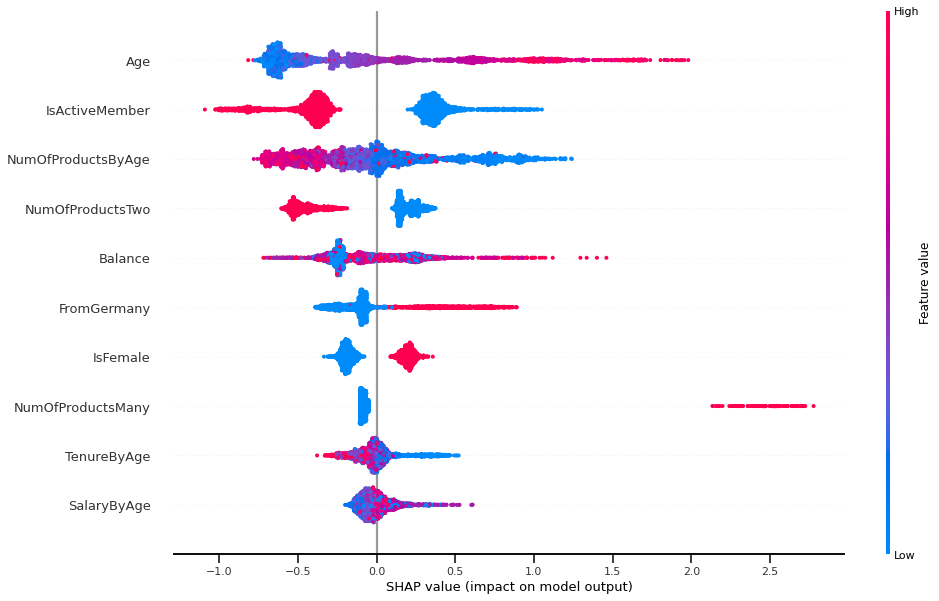

In [95]:
shap.summary_plot(shap_values, X_test, plot_size = (15,10))

Feature importance can be assesed in various ways, for example for XGBoost directly using the funtion plot_importance from _xgboost_ library. We can use various types of importance - below we chose __gain__ which is based on average gain of splits which use given feature. We can see that the order is similar but not identical - especially when we look at __NumOfProductsMany__. This feature rarely has values other than 0 but when it has it provides great differentiation between customers (hence the average gain of not that many splits that use it is high)

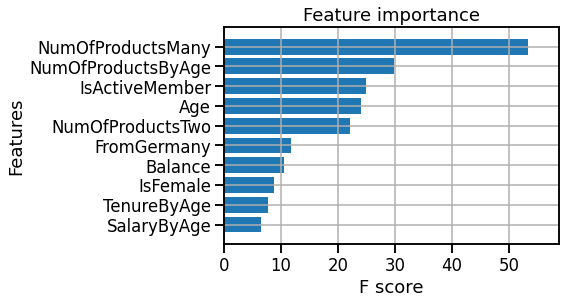

In [202]:
xgb.plot_importance(final_model, importance_type  = 'gain', show_values = False, height = 0.8)
plt.show()

Using __weight__ which summarises the number of times the feature appears in the trees visibly changes the picture for some features (like __NumOfProcutsMany__ and __Balance__)

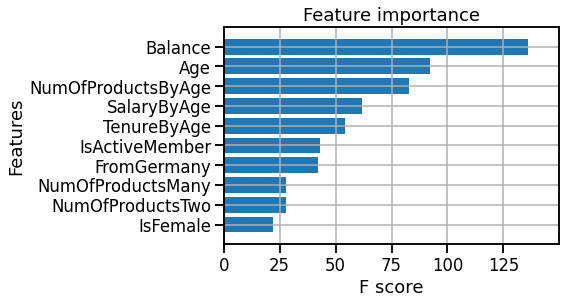

In [209]:
xgb.plot_importance(final_model, importance_type  = 'weight', show_values = False, height = 0.8)
plt.show()

Going back to _shap_ - we can also look at the impact of each individual feature with more details. Below we presented dependence plots from _shap_ library. On these scatter plots for each observation we see:
* on X axis - value of the given feature
* on Y axis - Shapley value (interpretation exactly as before)
* color - based on values of another feature which was automatically assessed as having the strongest interaction with analysed feature. It does not necessary has to be the same feature as the one with the strongest correlation - here we look as these features interacts with each other in our model

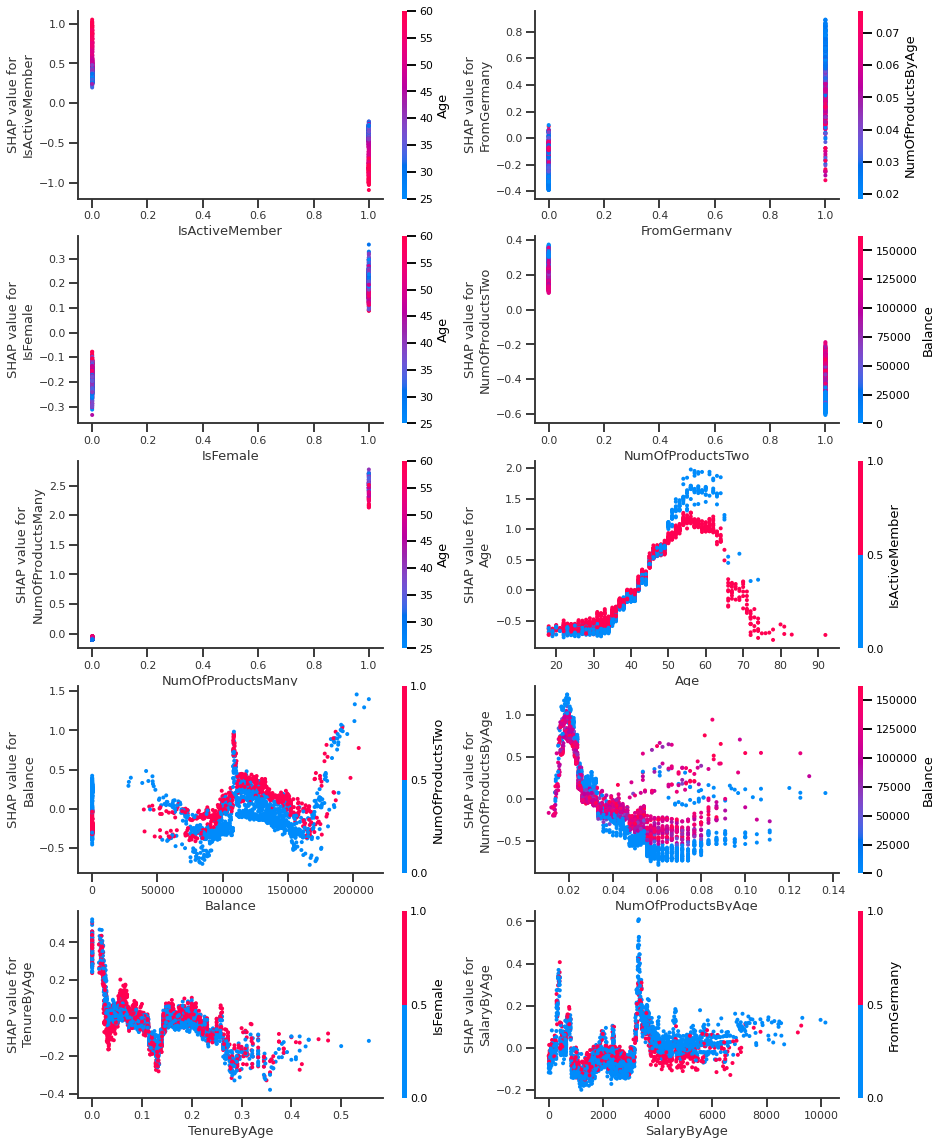

In [96]:
# we will not make this code into a function - we use it one time and subplots' nrow and ncols are designed 
# for our dataset with 10 features
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (15, 20), sharex = False)
f = X_test.columns
for i in range(10):
    a = ax[int(np.floor(i/2))][int(i-np.floor(i/2)*2)]
    shap.dependence_plot(f[i], shap_values, X_test, ax = a, show = False)
plt.show()

We can also play with interactive force plot (look at the html version of this notebook to experience interactivity). While we will not explain this plot in details, we can get potential insights while selecting the same variable on both axes

In [89]:
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values, X_test))

One final look inside our model, potentially the most useful one in terms of choosing our actions to prevent customer from churning, would be to analyse the results obtained for particular customers. Let us select various customers and inspect what are the drivers of their predicted probability of churn

In [213]:
X_test_plus_prediction = X_test.reset_index(drop = True).assign(
    pred = final_model.predict(X_test), 
    prob = final_model.predict_proba(X_test)[:,1],
    cust_no = lambda x: x.index)

# during this "sanity check" we noticed that pickle.dump did not save our predict method override
# X_test_plus_prediction.groupby('pred')['prob'].agg([min,max,'count']) 

# we specify different scenarios to see different profiles of churn probability drivers
customer_1 = X_test_plus_prediction.query("prob > 0.8 & NumOfProductsMany == 1 & FromGermany == 0 & IsFemale == 0").head(1)
customer_2 = X_test_plus_prediction.query("prob > 0.9 & NumOfProductsMany == 0").head(1)
customer_3 = X_test_plus_prediction.query("pred == 0 & NumOfProductsTwo == 0").head(1)
customer_4 = X_test_plus_prediction.query("pred == 0 & NumOfProductsTwo == 1").head(1)

# showing the results in table
cust = pd.concat([customer_1.T,customer_2.T,customer_3.T, customer_4.T],axis = 1)
cust.columns = (["customer 1", "customer 2", "customer 3", "customer 4"])
display(cust.iloc[0:-1,:])

customer 1   customer 2     customer 3   customer 4
IsActiveMember           1.000000     0.000000       0.000000     1.000000
FromGermany              0.000000     0.000000       0.000000     0.000000
IsFemale                 0.000000     0.000000       0.000000     1.000000
NumOfProductsTwo         0.000000     0.000000       0.000000     1.000000
NumOfProductsMany        1.000000     0.000000       0.000000     0.000000
Age                     50.000000    60.000000      35.000000    59.000000
Balance             149713.610000     0.000000  144428.870000     0.000000
NumOfProductsByAge       0.060000     0.016667       0.028571     0.033898
TenureByAge              0.080000     0.033333       0.114286     0.101695
SalaryByAge           2497.448400  2958.007500    3832.361429  2726.261525
pred                     1.000000     1.000000       0.000000     0.000000
prob                     0.886754     0.917979       0.091295     0.101648

In [210]:
# the following function (along with comments inside) is a direct copy from this interesting article:
# https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c
# In general it allows to transform the output from XGBoost models to probabilities to have better interpretation
# of shap waterfall charts

def xgb_shap_transform_scale(original_shap_values, Y_pred, which):
    from scipy.special import expit
    
    #Compute the transformed base value, which consists in applying the logit function to the base value
    from scipy.special import expit #Importing the logit function for the base value transformation
    untransformed_base_value = original_shap_values.base_values[-1]
   
    #Computing the original_explanation_distance to construct the distance_coefficient later on
    original_explanation_distance = np.sum(original_shap_values.values, axis=1)[which]
    
    base_value = expit(untransformed_base_value ) # = 1 / (1+ np.exp(-untransformed_base_value))

    #Computing the distance between the model_prediction and the transformed base_value
    distance_to_explain = Y_pred[which] - base_value

    #The distance_coefficient is the ratio between both distances which will be used later on
    distance_coefficient = original_explanation_distance / distance_to_explain

    #Transforming the original shapley values to the new scale
    shap_values_transformed = original_shap_values / distance_coefficient

    #Finally resetting the base_value as it does not need to be transformed
    shap_values_transformed.base_values = base_value
    shap_values_transformed.data = original_shap_values.data
    
    #Now returning the transformed array
    return shap_values_transformed   

Impact of features on model's decision for customer 1


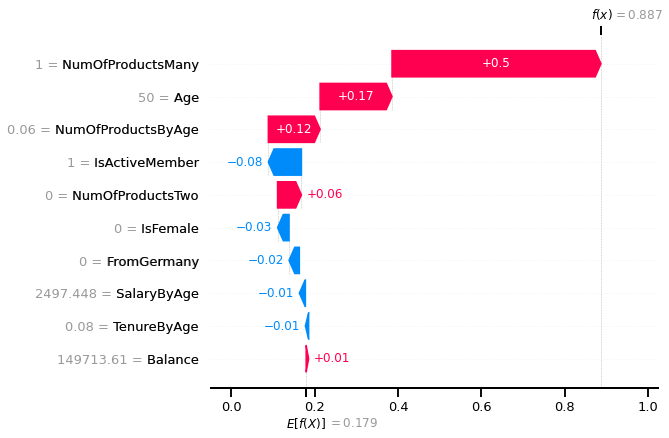

Impact of features on model's decision for customer 2


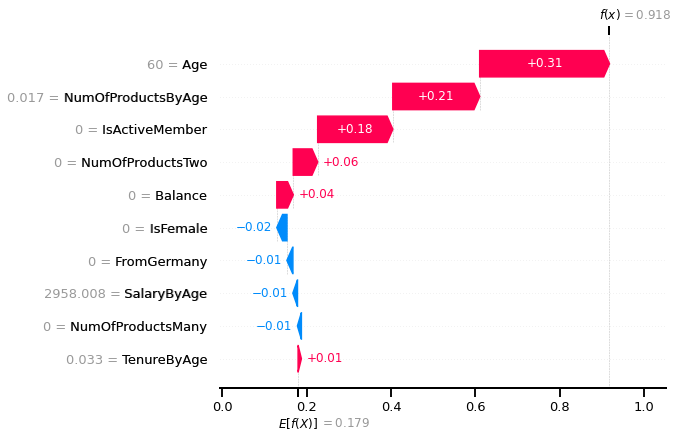

Impact of features on model's decision for customer 3


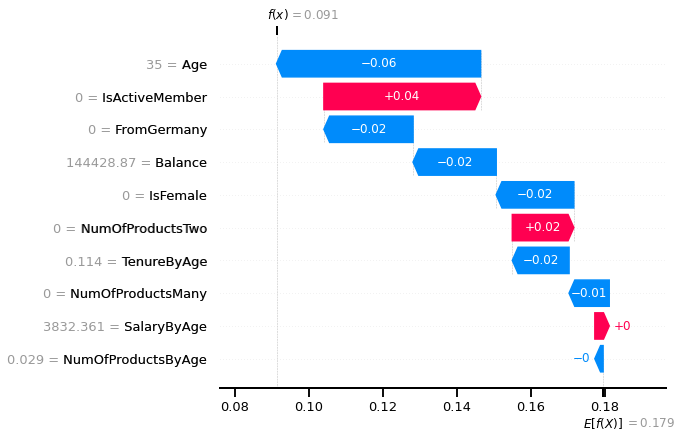

Impact of features on model's decision for customer 4


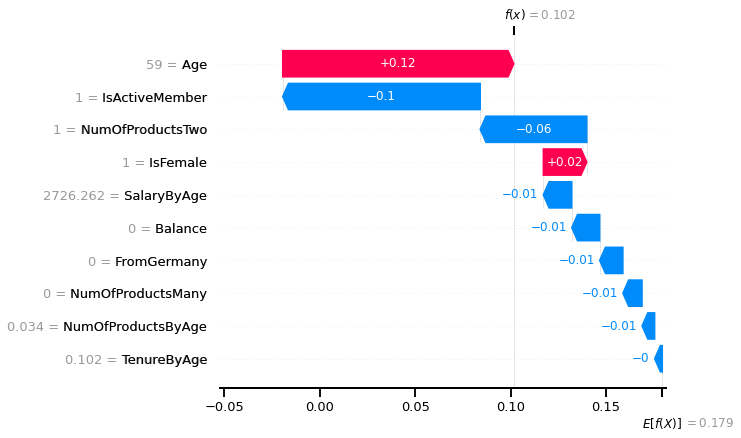

In [214]:
for i, _ in enumerate(cust.columns):
    ind = int(cust.loc["cust_no"][i])
    shap_values_transformed = xgb_shap_transform_scale(explained_vals, X_test_plus_prediction.prob, ind)
    print("Impact of features on model's decision for customer", i+1)
    shap.plots.waterfall(shap_values_transformed[ind])

Not only we see all features' values for a given customer, we also can get an idea how these values contributed to the final probability. For example:
* for customer 1 we see that the fact that he/she has more than 2 products was definitely the main driver (according to the model and the data we fitted it to) of customer's decision to leave. We can surely talk about it during the conversation with customer
* one of the important factors identified for customer 2 is his inactivity. We can discuss the resons during the call. We can try to adjust our arguments and vocabulary considering customer's age
* customers 3 and 4 has low risk of churning - below our cut-off. We do not need to take any actions to prevent their churn but now we better now why

In general - the more interested and complicated features we have, the more useful insights and hints for our preventive actions we can gather from such plots. These plots would definitely provide added value if they were implemented along with our model in the applications used by people potentially calling to customers (for example their private advisors).

# Final thoughts
<a href="#Contents"><button type="button";>Back to ToC</button></a>

During described analyses we covered most steps usually taken during successful model development projects. Typically though:
* we analyse much more data from various data sources
* we spend quite a lot of time cleaning the data (we even had no missing values in our dataset which is really rare in real world projects)
* we have much more possibilities in terms of feature engineering having more data to begin with
* (if we can) we meet several times with people with domain knowledge from our company (for example credit advisors of potentially churning customers) to discuss our findings and confront them with their business knowledge and intuition. This can often result in sharp turns when it comes to project direction. It is especially useful in the context of feature engineering
* we may spend even more time analysing various possible models and tuning their parameters. Instead of grid and random search we can use more sophisticated methods (like Bayesian optimization with _hyperopt_ library)
* we may play a role in implementation of the model especially in terms of verifying the results from implementation on test environment with results from our development
* life of the model just begins with its implementation - there is a need to closly track the model's performance over time and stability of the population for which it is used

# Appendix - neural network tuning
<a href="#Contents"><button type="button";>Back to ToC</button></a>

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.utils import to_categorical
# import keras_tuner
# from keras_tuner.tuners import RandomSearch, BayesianOptimization
# import os

In [5]:
print("Versions of additional libraries we will use here:")
!pip3 list | find "tensorflow "
!pip3 list | find "keras"
import sys 
print("User Current Version:-", sys.version)

Versions of additional libraries we will use here:
tensorflow                         2.6.2
keras                              2.6.0
keras-tuner                        1.1.0
User Current Version:- 3.6.3 |Anaconda custom (64-bit)| (default, Oct 27 2017, 12:22:41) [MSC v.1900 64 bit (AMD64)]


As an additional exercise we will try using deep learning for classification on our dataset. While neural networks are typically used for much more complicated problems and data (like images, texts, audio) we will see what results we can obtain. To remind - we have only 10 features we decided are worth using and only 7000 observations in training set. With these numbers we will definitely not aim for overly complicated neural network but we will test many architectures to see what works best for our data. Our search for best architecture can be thought of as hyperparameters tuning.

In [6]:
# loading the saved, prepared data for modelling and evaluation
[X_train, X_test, y_train, y_test] = load_data("train_test_split_list")

We will keep test set completly out ouf our architecture tuning process and do additional split of the train set for that purpose. We will take 3/7 of our original train set (so 3000 observations) as validation set for tuning and the remaining 4000 observations we will use for training models (for differentiation we will call it a learn set). Both sets are summarised below:

In [7]:
# split of train set with stratification on target variable
X_learn, X_valid, y_learn, y_valid = train_test_split(X_train, y_train, test_size = 3/7, 
                                                   stratify = y_train, random_state = 3103)

print("learn set: ")
display(y_learn.value_counts().to_frame("cnt").assign(pr = lambda x: ['{:.2%}'.format(p) for p in x.cnt / sum(x.cnt)]))
print("valid set: ")
display(y_valid.value_counts().to_frame("cnt").assign(pr = lambda x: ['{:.2%}'.format(p) for p in x.cnt / sum(x.cnt)]))

learn set: 


cnt      pr
0  3185  79.62%
1   815  20.38%

valid set: 


cnt      pr
0  2389  79.63%
1   611  20.37%

We performed tuning using our custom function designed to fit our binary classification problem. Our base model will be simple - 10 input nodes (for each feature), BatchNormalization layer (to normalize our features - similarily as we did in case of Logistic Regression and SVM) and output layer with one node with sigmoid activation function to return probabilities of class 1. In fact such architecture is basically a logistic regression classifier if we put aside how the parameters are being calculated. 

Besides this initial architecture we will also test 1000 other randomly constructed architectures.

In [59]:
# Unfortunately, while the keras_tuner seems to be a great library, I cannot get rid off errors like this
# "UnicodeDecodeError: 'utf-8' codec can't decode byte 0xea in position 280: invalid continuation byte"
# keras_tuner saves some checkpoints on hard drive and this error can randomly occur during some saves
# ("self._trackable_saver.save(filepath, session=session, options=options)")
# It is probably rare and has something to do with my Python and its libraries configuration because I could not 
# google sensible solution (there was only one to keep the directory path short in order not to exceed to max path length
# but as it can be seen below I supplied the shortest path possible)
# Either way we will leave commented code here to showcase how to use keras_tuner

# def mod_arch(hp):
#     model = keras.Sequential()
#     model.add(layers.BatchNormalization())
#     model.add(layers.InputLayer(input_shape=(10,)))
#     for i in range(hp.Int('layers', 1, 5)):
#         model.add(layers.Dense(units=hp.Int('units_' + str(i), 10, 100, step=30),
#                                         activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid'])))
#     #model.add(layers.Dense(2, activation='softmax'))
#     model.add(layers.Dense(1, activation='sigmoid'))
#     model.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])), 
#                   loss = 'binary_crossentropy', metrics=[keras.metrics.AUC(num_thresholds = 100)])
#     return model

# tune_nn = RandomSearch(
#     mod_arch,
#     objective = keras_tuner.Objective("val_auc", direction="max"),
#     max_trials = 50,
#     executions_per_trial = 1,
#     directory = os.path.normpath('C:/'),
#     project_name = 't',
#     overwrite = True
# )

# tune_nn.search_space_summary()

# tune_nn.search(X_learn, y_learn, epochs=20, validation_data=(X_valid, y_valid), batch_size = X_learn.shape[0])

# Get the optimal hyperparameters
# best_hps=tune_nn.get_best_hyperparameters(num_trials=1)[0]
# best_hps.get_config()['values']

# hypermodel = tune_nn.hypermodel.build(best_hps)
# hypermodel.fit(X_learn, y_learn, epochs=100, batch_size = X_learn.shape[0])

# hypermodel.summary()

# hypermodel.evaluate(X_test, y_test, return_dict = True, batch_size = X_learn.shape[0])

In [8]:
def custom_nn_random_tuner(X_learn, y_learn, X_valid, y_valid,
                    activation_function_options, dense_layers_number_options, units_options, learning_rate_options,
                    normalize_each_layer, search_runs, epochs, batch_size, early_stop_patience): 
    '''Custom function for tuning deep learning model architecture. It is designed for binary classification problem
    (final layer has 1 unit with sigmoid activation function to interpret the results as probabilities for class 1 and
    the loss function is binary_crossentropy)
    
     Args:
         X_learn, dataframe: dataframe with features on which the models will be trained
         y_learn, series with 0/1 values: list with values of target variable (for corresponding rows of X_learn)
         X_valid, dataframe: dataframe with features for which we will collect the validation metrics (AUC)
         y_valid, series with 0/1 values: list with values of target variable (for corresponding rows of X_valid)         
         activation_function_options, list: list of names of activation functions we want to test for hidden layers.
             For each hidden layer its activation function will be independently drawn from this list
         dense_layers_number_options, list: list of possible numbers of hidden layers we want to test. Drawn separately
             for each of the search_runs
         units_options, list: list of possible numbers of nodes in given hidden layer (number of nodes is drawn from
             this list independently for each hidden layer)
         learning_rate_options, list: list of possible learning rates for Adam optimizer
         normalize_each_layer, list: list of True / False values. For each tested model one bool value will be drawn
             from this list and in case of True - after each hidden layer a BatchNormalizationLayer will be added
         search_runs, integer: number of random architectures to be tested. Note that there is no verification if
             particular combination of parameters has already been tested
         epochs, integer: maximum number of epochs the models will be fitted (note - early stopping is used)
         batch_size, integer: batch size for fitting the models
         early_stop_patience, integer: after how many epochs of no improvement in validation AUC the fitting process
             should be stopped
         
     Returns:
         res_dict, dictionary: dictionary specifying the drawn and tested architectures along with achieved validation
             AUC values and number of epochs after which the fitting process has been early stopped
    '''
    
    # idea is to run many epochs but stop while for a long time there is no improvement in validation AUC
    monitor_val_auc = keras.callbacks.EarlyStopping(monitor='val_auc', patience=early_stop_patience, mode = 'max')
    
    # start with simple network 
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_learn.shape[1],)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01), 
                  loss = 'binary_crossentropy', metrics=['AUC'])
    h = model.fit(X_learn, y_learn, epochs = epochs, batch_size = batch_size, 
                  validation_data = (X_valid, y_valid), verbose = 0,
                  callbacks = monitor_val_auc)
    
    # initialize dictionary for model specification and validation AUC
    res_dict = dict({"model_init" : {"last_val_auc" : h.history['val_auc'][-1],
                                     "best_val_auc" : max(h.history['val_auc']),
                                     "deep_layers" : 0, 
                                     "learn_rate" : 0.01,
                                     "epochs" : len(h.history['val_auc'])
                                     }
                    })
    
    # random tuning loop
    for i in range(search_runs):
        # occiasionally let know about the progress
        if (i % 100) == 0:
            print("{} models tested ({:.2%})".format(i, i / search_runs))
        
        # initialize dictionary for model i specification
        d = dict()
        
        # create a new model
        model = keras.Sequential()
        # add input layer and normalize features
        model.add(layers.InputLayer(input_shape=(10,)))
        model.add(layers.BatchNormalization())
        
        # draw number of hidden layers
        d["deep_layers"] = np.random.choice(dense_layers_number_options)
        
        # draw whether add normalization layer after each hidden layer
        d["normalize"] = np.random.choice(normalize_each_layer)
        
        # go through hidden layers
        for dl in range(d["deep_layers"]):
            
            # draw number of units for layer dl
            d["units_"+str(dl)] = np.random.choice(units_options)
            
            # draw activation function for layer dl
            d["act"+str(dl)] = np.random.choice(activation_function_options)
            
            # add hidden layer with specified parameters
            model.add(layers.Dense(d["units_"+str(dl)], 
                                   activation = d["act"+str(dl)]))
            
            # conditionally add normalization layer
            if (d["normalize"] == True):
                model.add(layers.BatchNormalization())
                
        # add final layer with sigmoid activation to obtain probability of class 1
        model.add(layers.Dense(1, activation='sigmoid'))
        
        # draw learning rate for Adam optimizer
        d["learn_rate"] = np.random.choice(learning_rate_options)
        
        # compile the model
        model.compile(optimizer = keras.optimizers.Adam(learning_rate = d["learn_rate"]), 
                      loss = 'binary_crossentropy', metrics=['AUC'])
        
        # fit the model
        h = model.fit(X_learn, y_learn, epochs = epochs, batch_size = batch_size, 
                      validation_data = (X_valid, y_valid), verbose = 0,
                      callbacks = monitor_val_auc)
        
        # add info about AUC on validation data and number of epochs training lasted before early stopped
        d["last_val_auc"] = h.history['val_auc'][-1]
        d["best_val_auc"] = max(h.history['val_auc'])
        d["epochs"] = len(h.history['val_auc'])
        
        # add model's i specification to final dictionary
        res_dict["model_" + str(i)] = d
    
    return(res_dict)

In [9]:
tuning_results = custom_nn_random_tuner(X_learn, y_learn, X_valid, y_valid,
                    ['relu','sigmoid','softplus'], [1,2,3,4,5], 
                    [10,20,50,100], [0.1,0.01,0.001,0.0001], [True,False],
                    search_runs = 1000, epochs = 5000, batch_size = X_learn.shape[0], early_stop_patience = 50)

0 models tested (0.00%)
100 models tested (10.00%)
200 models tested (20.00%)
300 models tested (30.00%)
400 models tested (40.00%)
500 models tested (50.00%)
600 models tested (60.00%)
700 models tested (70.00%)
800 models tested (80.00%)
900 models tested (90.00%)


The tunning process took about 4 hours 10 minutes on our mediocre computer. 20 best architectures in terms of AUC on our validation set are summarised in the table below. Below them we presented which place in this ranking took our simplest architecture without hidden layers. We can see that over a quarter of tested 1000 random architectures were better by up to 0.035 AUC which is a visible improvement.

In [11]:
tuning_results_df = pd.DataFrame(tuning_results).T.drop("best_val_auc", axis = 1). \
    sort_values('last_val_auc', ascending = False).fillna("")
tuning_results_df.head(20)

last_val_auc  deep_layers  learn_rate  epochs normalize units_0  \
model_582      0.865405          1.0      0.0010  1586.0      True     100   
model_668      0.864923          1.0      0.0010  1651.0      True     100   
model_376      0.864605          1.0      0.0010  1731.0      True      50   
model_503      0.863822          4.0      0.0010  1109.0     False      10   
model_366      0.863529          5.0      0.0010  1323.0     False      10   
model_335      0.863030          1.0      0.0010  1656.0     False     100   
model_553      0.862900          2.0      0.0010  1518.0     False      50   
model_735      0.862720          5.0      0.0010  1160.0     False      10   
model_240      0.862701          3.0      0.0001  1720.0      True     100   
model_877      0.862673          4.0      0.0001  2922.0     False     100   
model_256      0.861974          3.0      0.0010  1192.0     False      20   
model_629      0.861859          2.0      0.0010  1563.0     False      20   
model_609      0.861350          5.0      0.0010   917.0     False      20   
model_72       0.860626          3.0      0.0010  1159.0     False      50   
model_88       0.859575          2.0      0.0010  1134.0      True      50   
model_806      0.859543          2.0      0.0001  1522.0      True     100   
model_927      0.859467          3.0      0.0010  1093.0     False      20   
model_977      0.859348          4.0      0.0010   825.0     False      10   
model_94       0.859286          2.0      0.0010   641.0      True      20   
model_302      0.859267          3.0      0.0010  1015.0     False      50   

               act0 units_1      act1 units_2      act2 units_3      act3  \
model_582   sigmoid                                                         
model_668  softplus                                                         
model_376   sigmoid                                                         
model_503  softplus      50  softplus      20   sigmoid     100      relu   
model_366  softplus      10  softplus     100  softplus      50  softplus   
model_335  softplus                                                         
model_553  softplus      10  softplus                                       
model_735  softplus      10  softplus      20  softplus      20   sigmoid   
model_240  softplus      20  softplus     100  softplus                     
model_877  softplus     100  softplus      50      relu     100   sigmoid   
model_256  softplus      20  softplus      20   sigmoid                     
model_629  softplus     100   sigmoid                                       
model_609   sigmoid      10  softplus      50   sigmoid      10   sigmoid   
model_72   softplus      20  softplus      10      relu                     
model_88    sigmoid      10  softplus                                       
model_806  softplus     100      relu                                       
model_927  softplus     100  softplus      20  softplus                     
model_977      relu     100   sigmoid      20   sigmoid     100  softplus   
model_94   softplus     100   sigmoid                                       
model_302  softplus      20  softplus     100  softplus                     

          units_4      act4  
model_582                    
model_668                    
model_376                    
model_503                    
model_366     100      relu  
model_335                    
model_553                    
model_735      20      relu  
model_240                    
model_877                    
model_256                    
model_629                    
model_609      10  softplus  
model_72                     
model_88                     
model_806                    
model_927                    
model_977                    
model_94                     
model_302

In [17]:
tuning_results_df.assign(rank_no = np.arange(len(tuning_results_df))).loc["model_init", ["rank_no","last_val_auc"]].to_frame()

model_init
rank_no             266
last_val_auc   0.830571

In [18]:
def build_best_nn(X, y, batch_size, model_dict, epochs = None):
    '''Custom function fitting a deep learning model based on architecture supplied in dictionary model_dict.
    It requires the dictionary with the same format as in function custom_nn_random_tuner for each tested architecture
    
     Args:
         X, dataframe: dataframe with features on which the model will be trained
         y, series with 0/1 values: list with values of target variable (for corresponding rows of X)
         batch_size, integer: batch size for fitting the model
         model_dict, dictionary: dictionary specifying model's architecture. Must have the same format 
             as in function custom_nn_random_tuner for each tested architecture
         epochs, integer (optional): if None, the model will be fitted the number of epochs specified in model_dict. 
             Providing a number will override the epochs value from model_dict and allow fitting the model for as
             many epochs as required.
         
     Returns:
         dictionary: dictionary with model of specified architecture fitted to supplied data (key = "model") and
             history of fitting (key = "history")
    '''
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(10,)))
    model.add(layers.BatchNormalization())

    # add specified number of hidden layers
    for dl in range(model_dict["deep_layers"]):
        model.add(layers.Dense(model_dict["units_"+str(dl)], 
                               activation = model_dict["act"+str(dl)]))
        if (model_dict["normalize"] == True):
            model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = model_dict["learn_rate"]), 
                  loss = 'binary_crossentropy', metrics=['AUC'])
    
    h = model.fit(X, y, epochs = model_dict["epochs"] if epochs is None else epochs, 
                  batch_size = batch_size, verbose = 0)    
    
    return(dict({"model" : model, "history" : h}))

We will train several models with architecture which turned out to be the most promising according to our tuning. They will differ in terms of the set to which they will be fitted (either full train set saved in the [Train / Test split](#Train-/-Test-split) section of this project or the 4/7 of it - on which we fitted models during architecture tuning) and the number of training epochs (either 10000 or the number of epochs after which the training early stopped during architecture tuning)

We will verify the models on the test set which up to this point has not been seen during tuning (we used there validation set drawn from the original train set).

Summary of the best architecture from tuning:
Model: "sequential_1009"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2512 (Ba (None, 10)                40        
_________________________________________________________________
dense_3949 (Dense)           (None, 100)               1100      
_________________________________________________________________
batch_normalization_2513 (Ba (None, 100)               400       
_________________________________________________________________
dense_3950 (Dense)           (None, 1)                 101       
Total params: 1,641
Trainable params: 1,421
Non-trainable params: 220
_________________________________________________________________
Performance of models with this architecture on the test set: 


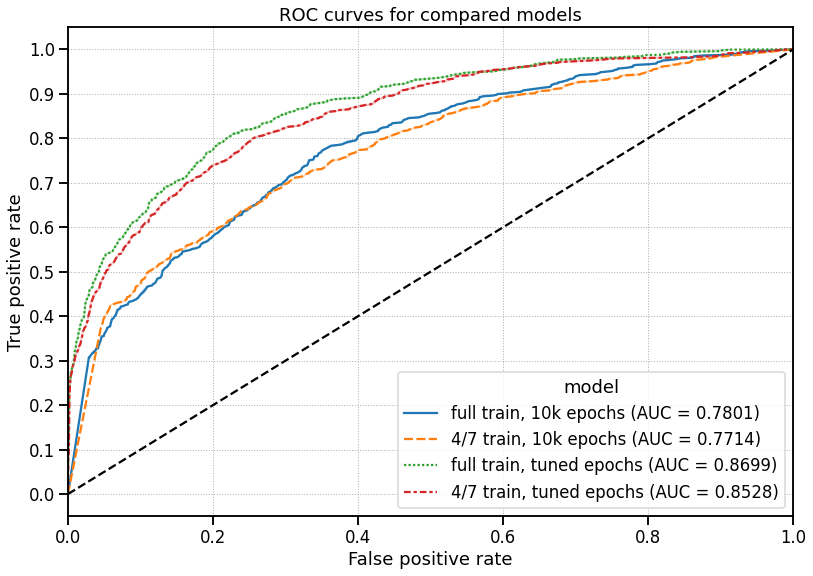

In [21]:
chosen_arch = "model_582"
best_arch_models = {
    "full train, 10k epochs": build_best_nn(X_train, y_train, X_train.shape[0], 
                                            tuning_results[chosen_arch], 10000)["model"],
    "4/7 train, 10k epochs": build_best_nn(X_learn, y_learn, X_learn.shape[0],
                                           tuning_results[chosen_arch], 10000)["model"],
    "full train, tuned epochs": build_best_nn(X_train, y_train, X_train.shape[0],
                                              tuning_results[chosen_arch])["model"],
    "4/7 train, tuned epochs": build_best_nn(X_learn, y_learn, X_learn.shape[0],
                                             tuning_results[chosen_arch])["model"]
}

print("Summary of the best architecture from tuning:")
best_arch_models["full train, 10k epochs"].summary()

print("Performance of models with this architecture on the test set: ")
compare_ROC_curve([best_arch_models["full train, 10k epochs"],
                   best_arch_models["4/7 train, 10k epochs"],
                   best_arch_models["full train, tuned epochs"],
                   best_arch_models["4/7 train, tuned epochs"]], 
                  ["full train, 10k epochs",
                   "4/7 train, 10k epochs",
                   "full train, tuned epochs",
                   "4/7 train, tuned epochs"], X_test,y_test)

The obtained results are really interesting. For models trained for number of epochs after which the training early stopped during architecture tuning we see definitely satisfactory results on the independent test set. Comparing with [ROC curve and AUC](#ROC-curve-and-AUC) section, we can see that the model trained on the full train set performed very close to our best XGBoost model in terms of test AUC. For models trained on 10000 epochs (instead of 1586 from tuning) we can see visibly worse performance which is a sign that these models started to overfit to the training data which hindered their performance on never seen before sample.

We did the same excersise with the simplest architecture with no hidden layers

Summary of the initial architecture:
Model: "sequential_1278"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2905 (Ba (None, 10)                40        
_________________________________________________________________
dense_6273 (Dense)           (None, 1)                 11        
Total params: 51
Trainable params: 31
Non-trainable params: 20
_________________________________________________________________
Performance of models with initial architecture on the test set: 


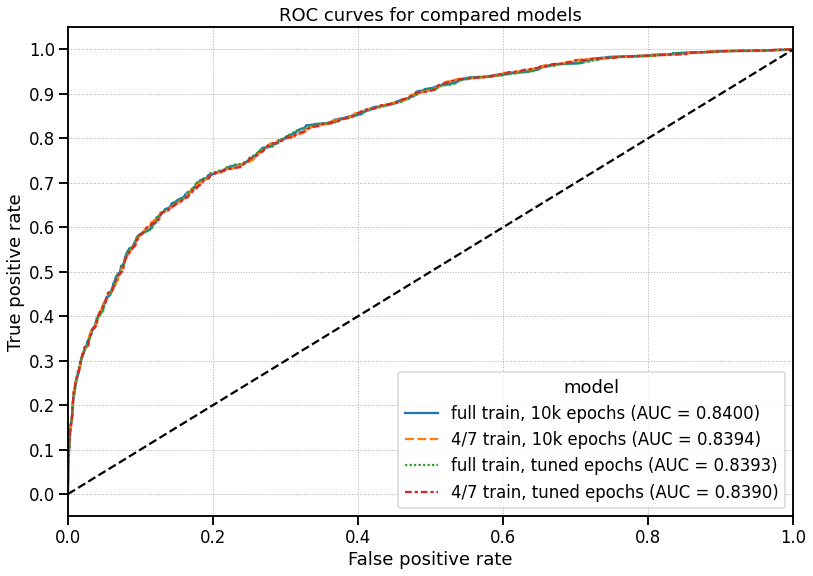

In [132]:
chosen_arch = "model_init"
init_arch_models = {
    "full train, 10k epochs": build_best_nn(X_train, y_train, X_train.shape[0], 
                                            tuning_results[chosen_arch], 10000)["model"],
    "4/7 train, 10k epochs": build_best_nn(X_learn, y_learn, X_learn.shape[0],
                                           tuning_results[chosen_arch], 10000)["model"],
    "full train, tuned epochs": build_best_nn(X_train, y_train, X_train.shape[0],
                                              tuning_results[chosen_arch])["model"],
    "4/7 train, tuned epochs": build_best_nn(X_learn, y_learn, X_learn.shape[0],
                                             tuning_results[chosen_arch])["model"]
}

print("Summary of the initial architecture:")
init_arch_models["full train, 10k epochs"].summary()

print("Performance of models with initial architecture on the test set: ")
compare_ROC_curve([init_arch_models["full train, 10k epochs"],
                   init_arch_models["4/7 train, 10k epochs"],
                   init_arch_models["full train, tuned epochs"],
                   init_arch_models["4/7 train, tuned epochs"]], 
                  ["full train, 10k epochs",
                   "4/7 train, 10k epochs",
                   "full train, tuned epochs",
                   "4/7 train, tuned epochs"], X_test,y_test)

As we see, the results for each of these much smaller networks are very comparable. Comparing with [ROC curve and AUC](#ROC-curve-and-AUC) section we can notice that obtained AUC values are very similar to AUC scored by logistic regression. It should not be a surprise because as we already mentioned this is basically the same model (linear combination of normalized features with sigmoid transformation) but with parameters calculated differently.

One final note from our appendix is that we presented simple approach to tuning - with one validation set. Better approach (and more time consuming) would be to perform cross-validation to obtain more than one test AUC (and thus more reliable results and ranking of tested architectures), similarly as we did in [Modelling](#Modelling) section. Our main goal, however, was to present general idea how to tune the architecture of deep learning models.

In [135]:
# Saving our tuning results
save_data(tuning_results, "nn_tuning_results")

# Saving two final models
best_arch_models["full train, tuned epochs"].save("nn_best_arch_model.h5")
init_arch_models["full train, tuned epochs"].save("nn_init_arch_model.h5")

# Appendix II - costs based cut-off selection
<a href="#Contents"><button type="button";>Back to ToC</button></a>

In this appendix we will show how to select optimal cut-off for our model (we will use our XGBoost which proved to be the best out of tested models) if we estimated costs of our potential preventive actions, costs of not identifying churning customer as well as the effectiveness of our potential actions

In [3]:
def minimize_costs(model, X, y, thresholds, action_cost, missed_positive_cost, action_effectiveness, population_size):
    '''Produce cost assesment for given model, probability thresholds, costs and population size
    
     Args:
         models, model object: model for which we want to choose cut-off
         X, dataframe: dataframe with features used by supplied model. It should be a dataset which was not used in 
             any way during the fitting of the model.
         y, series with 0/1 values: list with values of target variable (for corresponding rows of X)
         thresholds, array: list of probability thresholds above which we will predict positive class
         action_cost, float: our cost for each positive predicted by the model (for example cost of phone call, 
             cost of working time of calling employee and cost of potential actions to keep a customer in churn problem)
         missed_positive_cost, float: cost of each from positive class who was not identified or our actions were
             ineffective (for example cost of acquiring a new customer instead of the one who is leaving in churn problem)
         action_effectiveness, float: between 0 and 1 - estimated effectiveness of our action preventing predicted 
             event (for example churn)
         population_size, int: size of the population on which we want to assess costs. Does not impact the cut-off
             selection, only scales the estimated costs
         
     Returns:
         cost_assesment, dataframe: dataframe with row for each threshold with cost calculations and indicator of 
             threshold minimizing costs for given parameters
    '''  
    # predict and gather probabilities for class 1
    y_pred_proba = model.predict_proba(X)[:,1]
    # dataframe with column for each threshold and row for each observation 
    # with True if predicted probability > threshold and False otherwise
    preds_matrix = pd.DataFrame(np.array([(y_pred_proba > x) for x in thresholds]), index = thresholds).T
    # dataframe with row for each threshold and classification diagnostics in columns
    cost_assesment = pd.concat(
        [pd.DataFrame({"cut_off" : x,
                       "action_cost" : action_cost,
                       "missed_positive_cost" : missed_positive_cost,
                       "action_effectiveness" : action_effectiveness,
                       "population_size" : population_size,
                       # show as percentages to be able to apply to specified size population
                        "TP" : [sum(np.array(preds_matrix[x] == True)*np.array(y == 1)) / X.shape[0]],
                        "FN" : [sum(np.array(preds_matrix[x] == False)*np.array(y == 1)) / X.shape[0]],
                        "FP" : [sum(np.array(preds_matrix[x] == True)*np.array(y == 0)) / X.shape[0]],
                        "TN" : [sum(np.array(preds_matrix[x] == False)*np.array(y == 0)) / X.shape[0]]}) 
        for x in preds_matrix]
    ).reset_index(drop = True).assign(
        # model says positive -> we take action costs + if the action is not effective a customer will churn
        TP_costs = lambda x: population_size * x.TP * (action_cost + (1-action_effectiveness) * missed_positive_cost),
        # model says negative -> we have no action costs but the customers are churning
        FN_costs = lambda x: population_size * x.FN * missed_positive_cost,
        # model says positive -> we take action costs but the actions do not matter as a customer would not churn
        FP_costs = lambda x: population_size * x.FP * action_cost,
        # TN = 0: model says negative -> we have no costs and customers are not churning
        total_costs = lambda x: x.TP_costs + x.FN_costs + x.FP_costs,
        min_costs = lambda x: x.total_costs == np.min(x.total_costs)
    )            
    return cost_assesment

The optimal cut-offs (minimizing our total costs) are presented below for some possible costs and effectiveness estimations (also shown in the table):

In [4]:
# loading the saved, prepared data for modelling and evaluation
[X_train, X_test, y_train, y_test] = load_data("train_test_split_list")
# loading our best model
final_model = load_data("final_model")

params_to_test = pd.DataFrame(
    {
        "action_cost" : [1000,1000,2000,2000,5000,5000,10000,10000,20000,20000],
        "missed_positive_cost" : [10000] * 10,
        "action_effectiveness": [0.3,0.8] * 5
    }
)

best_cutoffs = pd.DataFrame()
for i in range(params_to_test.shape[0]):
    best_cutoffs = best_cutoffs.append(
        minimize_costs(final_model, X_test, y_test, np.linspace(0,1,1000), 
                      params_to_test.action_cost[i], params_to_test.missed_positive_cost[i], 
                      params_to_test.action_effectiveness[i], 10000).query("min_costs == True")
    )

display(
    best_cutoffs.drop_duplicates(subset = ['action_cost', 'action_effectiveness']).assign(
        TP_costs = lambda x: ['{:.0f}'.format(l) for l in x.TP_costs],
        FN_costs = lambda x: ['{:.0f}'.format(l) for l in x.FN_costs],
        FP_costs = lambda x: ['{:.0f}'.format(l) for l in x.FP_costs],
        total_costs = lambda x: ['{:.0f}'.format(l) for l in x.total_costs]
    ))

cut_off  action_cost  missed_positive_cost  action_effectiveness  \
357  0.357357         1000                 10000                   0.3   
119  0.119119         1000                 10000                   0.8   
714  0.714715         2000                 10000                   0.3   
279  0.279279         2000                 10000                   0.8   
984  0.984985         5000                 10000                   0.3   
714  0.714715         5000                 10000                   0.8   
984  0.984985        10000                 10000                   0.3   
984  0.984985        10000                 10000                   0.8   
984  0.984985        20000                 10000                   0.3   
984  0.984985        20000                 10000                   0.8   

     population_size        TP        FN     FP        TN TP_costs  FN_costs  \
357            10000  0.124333  0.079333  0.062  0.734333  9946667   7933333   
119            10000  0.177000  0.026667  0.262  0.534333  5310000   2666667   
714            10000  0.067667  0.136000  0.008  0.788333  6090000  13600000   
279            10000  0.139333  0.064333  0.097  0.699333  5573333   6433333   
984            10000  0.000000  0.203667  0.000  0.796333        0  20366667   
714            10000  0.067667  0.136000  0.008  0.788333  4736667  13600000   
984            10000  0.000000  0.203667  0.000  0.796333        0  20366667   
984            10000  0.000000  0.203667  0.000  0.796333        0  20366667   
984            10000  0.000000  0.203667  0.000  0.796333        0  20366667   
984            10000  0.000000  0.203667  0.000  0.796333        0  20366667   

    FP_costs total_costs  min_costs  
357   620000    18500000       True  
119  2620000    10596667       True  
714   160000    19850000       True  
279  1940000    13946667       True  
984        0    20366667       True  
714   400000    18736667       True  
984        0    20366667       True  
984        0    20366667       True  
984        0    20366667       True  
984        0    20366667       True

Below we looked at relation between our total costs and chosen cut-off for these particular parameters:
* cost of our action per each customer predicted as churning = 1000
* cost of allowing the customer to leave (either by predicting him as not churning or by ineffective preventive action) = 10000
* effectiveness of our actions preventing churn = 70%
* size of the population = 10000 (assumed similar churn rate and effectiveness of our model as on the test set)

The results are shown on the figure below. Interestingly - this is basically the exact cut-off we finally selected in the [Selected model](#Selected-model) section

In [94]:
def plot_cutoff_justification(minimize_costs_df):
    '''Produce plot with summary of the cut-off selection. We can analyze the costs + their composition for range of cut-offs
    and see which one minimizes the costs
    
     Args:
         minimize_costs_df, dataframe: dataframe produced by the minimize_costs function. 
             Note: for proper estimation how much money our model saves with optimial cut-off it is assumed that
             in the minimize_costs_df we also tested cut-off for which model predicts no positive class 
             (so ~ 100% probability).
         
     Returns:
         Nothing
    '''  
    best_cutoff = minimize_costs_df.query("min_costs == True").drop_duplicates(subset = ['action_cost'])

    ax = minimize_costs_df[['cut_off','TP_costs', 'FN_costs', 'FP_costs']].set_index("cut_off").plot.area(
        stacked = True, figsize=(15,12), colormap = "viridis")
    plt.ylabel("costs")
    plt.axvline(x=best_cutoff.cut_off.iloc[0], color='g', linestyle='--')
    plt.axhline(y=minimize_costs_df.total_costs.iloc[-1], color='r', linestyle='--')
    plt.title("Costs estimation for various cut-offs")
    ax.annotate(
    """
    best cut_off = {:.4f}
    TP = {:.2%}
    FN = {:.2%}
    FP = {:.2%}
    TN = {:.2%}
    TP costs = {:.1f} M
    FN costs = {:.1f} M
    FP costs = {:.1f} M
    total costs = {:.1f} M
    """.format(best_cutoff.cut_off.iloc[0], best_cutoff.TP.iloc[0], best_cutoff.FN.iloc[0], 
                   best_cutoff.FP.iloc[0], best_cutoff.TN.iloc[0], best_cutoff.TP_costs.iloc[0]/1e6,
                  best_cutoff.FN_costs.iloc[0]/1e6, best_cutoff.FP_costs.iloc[0]/1e6, best_cutoff.total_costs.iloc[0]/1e6), 
        xy=(best_cutoff.cut_off.iloc[0], best_cutoff.total_costs.iloc[0]),
        xytext =(0.5,best_cutoff.total_costs.iloc[0]/2),
        arrowprops = {'facecolor':'black', 'width': 2}
    )
    ax.annotate(
        "our model saves {:.1f} M".format((minimize_costs_df.total_costs.iloc[-1]-best_cutoff.total_costs.iloc[0])/1e6),
        xy=(best_cutoff.cut_off.iloc[0]+0.01, 
            best_cutoff.total_costs.iloc[0]+0.5*(minimize_costs_df.total_costs.iloc[-1] - best_cutoff.total_costs.iloc[0]))
    )
    plt.legend(loc = "center right")
    ax.set(xlim=(0,1))
    plt.show()

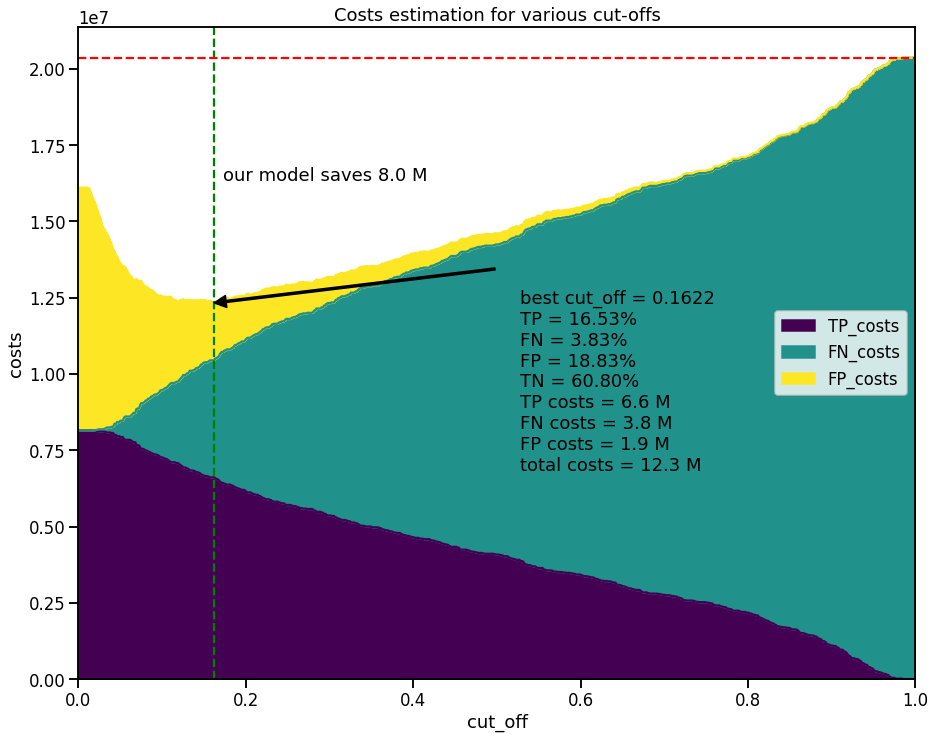

In [96]:
action_cost = 1000
missed_positive_cost = 10000
action_effectiveness = 0.7
population_size = 10000

plot_results = minimize_costs(final_model, X_test, y_test, np.linspace(0,1,1000), 
                              action_cost, missed_positive_cost, action_effectiveness, population_size)
plot_cutoff_justification(plot_results)